In [361]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import pandas as pd
import numpy as np

import scipy as scp
import sklearn
import sys, os, pickle

sys.path.append(os.path.join('..'))

from FACT.helper import *
from FACT.fairness import *
from FACT.data_util import *
from FACT.plot import *
from FACT.lin_opt import *
from FACT.utils import *

from FACT.parser import * 
from FACT.model import *
from FACT.metric_util import *

from FACT.image_dataloader import *

# import FACT.dataloader

from sklearn.model_selection import train_test_split
from scipy.io import savemat

import torch, torchvision

from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision.utils as vutils

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# file_path y a
train_path = '/data/celebA/CelebA/Anno/train_data.txt'
valid_path = '/data/celebA/CelebA/Anno/val_data.txt'
test_path = '/data/celebA/CelebA/Anno/test_data.txt'

In [11]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# mean = [0.5, 0.5, 0.5]
# std = [0.5, 0.5, 0.5]
normalize = transforms.Normalize(mean=mean, std=std)
        
ts = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize,
       ])

train_data = CelebADataset(train_path, transform = ts)
valid_data = CelebADataset(valid_path, transform = ts)
test_data = CelebADataset(test_path, transform = ts)

In [12]:
batch_size = 64
workers = 12


trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

validloader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

In [13]:
opt = {'cuda':'1', 'random_seed':0, 'experiment':'celeba', 'print_freq':50, 'batch_size':32, 'total_epochs':50, 
      'output_dim':1, 'save_log':True}

opt['save_folder'] = os.path.join('../experiments/', opt['experiment'])
opt['device'] = torch.device('cuda:' + opt['cuda'])

if not os.path.exists(opt['save_folder']):
    os.makedirs(opt['save_folder'])

optimizer_setting = {
    'optimizer':torch.optim.Adam,
    'lr':1e-4,
    'weight_decay': 0
}
opt['optimizer_setting']=optimizer_setting
opt['dropout']=0.5

In [14]:
GSTAR_model = ImageModel(opt)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


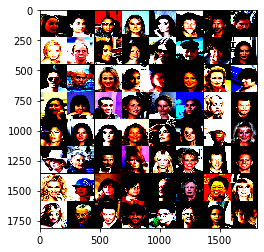

In [15]:
x, s, y = iter(trainloader).next()
x, s, y = x.to(opt['device']), s.to(opt['device']), y.to(opt['device'])
show_img(x)

In [65]:
per_dict = GSTAR_model.test(testloader, 'best.pth')

ACC : 0.820, Priv ACC : 0.826, Unpriv ACC : 0.815
TPR : 0.809, Priv TPR : 0.613, Unpriv TPR : 0.890
FPR : 0.169, Priv FPR : 0.092, Unpriv FPR : 0.341


In [66]:
complete_dict(per_dict)
per_dict

{'TP_priv': 1704.0,
 'FN_priv': 1077.0,
 'FP_priv': 665.0,
 'TN_priv': 6554.0,
 'TP_unpriv': 6006.0,
 'FN_unpriv': 745.0,
 'FP_unpriv': 665.0,
 'TN_unpriv': 2142.0,
 'FP': 1330.0,
 'TP': 7710.0,
 'FN': 1822.0,
 'TN': 8696.0}

In [67]:
trainloader_GSTAR = torch.utils.data.DataLoader(train_data, batch_size=64,
                                         shuffle=True, num_workers=workers)
validloader_GSTAR = torch.utils.data.DataLoader(valid_data, batch_size=64,
                                         shuffle=True, num_workers=workers)
testloader_GSTAR = torch.utils.data.DataLoader(test_data, batch_size=64,
                                         shuffle=True, num_workers=workers)

In [137]:
def gen_samples(trainloader, validloader, testloader):
    train_logit = []
    train_sens = []
    train_label = []

    num_batch = 70

    GSTAR_model.load_model('best.pth')

    i=0
    for x,s,y in trainloader:
        x, s, y = x.to(opt['device']), s.to(opt['device']), y.to(opt['device'])

        logit = GSTAR_model.test_batch(x)
        train_logit.append(logit)
        train_sens.append(s)
        train_label.append(y)


        if i>=num_batch - 1:
            break

        i += 1

    valid_logit = []
    valid_sens = []
    valid_label = []

    num_batch = 30

    GSTAR_model.load_model('best.pth')

    i=0
    for x,s,y in validloader:
        x, s, y = x.to(opt['device']), s.to(opt['device']), y.to(opt['device'])

        logit = GSTAR_model.test_batch(x)
        valid_logit.append(logit)
        valid_sens.append(s)
        valid_label.append(y)


        if i>=num_batch - 1:
            break

        i += 1
    test_logit = []
    test_sens = []
    test_label = []

    num_batch = 30

    GSTAR_model.load_model('best.pth')

    i=0
    for x,s,y in testloader:
        x, s, y = x.to(opt['device']), s.to(opt['device']), y.to(opt['device'])

        logit = GSTAR_model.test_batch(x)
        test_logit.append(logit)
        test_sens.append(s)
        test_label.append(y)


        if i>=num_batch - 1:
            break

        i += 1
        
    train_logit = torch.cat(train_logit).detach().cpu().numpy().reshape(-1)
    train_sens = torch.cat(train_sens).detach().cpu().numpy()
    train_label = torch.cat(train_label).detach().cpu().numpy()

    valid_logit = torch.cat(valid_logit).detach().cpu().numpy().reshape(-1)
    valid_sens = torch.cat(valid_sens).detach().cpu().numpy()
    valid_label = torch.cat(valid_label).detach().cpu().numpy()

    test_logit = torch.cat(test_logit).detach().cpu().numpy().reshape(-1)
    test_sens = torch.cat(test_sens).detach().cpu().numpy()
    test_label = torch.cat(test_label).detach().cpu().numpy()
    
    
    return train_logit, train_sens, train_label, \
            valid_logit, valid_sens, valid_label, \
            test_logit, test_sens, test_label

In [73]:
DATANAME = 'CelebA'

In [426]:
def gen_config(logit, sens, label, logit_shape = True, verbose = True, save_fig = False):
    if logit_shape:
        theta_0 = np.zeros((2,1))
    else:
        theta_0 = np.zeros((2,1))+0.5

    idx_a = sens == 1
    idx_y = label == 1

    n00 = sum(~idx_a*~idx_y)
    n10 = sum(~idx_a*idx_y)
    n01 = sum(idx_a*~idx_y)
    n11 = sum(idx_a*idx_y)
    N = n00 + n10 + n01 + n11

    sample_config = {'n00':n00, 'n01':n01, 'n10':n10, 'n11':n11}
    print(sample_config)
    dist_config = {}

    A_EOp =  N * np.array([1/n11,0,0,0,-1/n10,0,0,0]).reshape(-1,1)
    A_PE =  N * np.array([0,0,1/n01,0, 0,0,-1/n00,0]).reshape(-1,1)
    A_EOd = np.concatenate((A_EOp, A_PE), axis = 1)
    A_DP =  N * np.array([1/(n11+n01), 0, 1/(n11+n01), 0, -1/(n10+n00), 0, -1/(n10+n00), 0]).reshape(-1,1)
    
    A_config = {'A_EOp': A_EOp, 'A_PE': A_PE, 'A_EOd': A_EOd, 'A_DP': A_DP}

    c = np.array([0, 1, 1, 0, 0, 1, 1, 0]).reshape(-1,1)

    dist_estimate(logit, label, sens, '0', theta_0, DATANAME, sample_config, dist_config, \
                  logit_form = logit_shape, verbose = verbose, save_fig = save_fig);
    dist_estimate(logit, label, sens, '1', theta_0, DATANAME, sample_config, dist_config, \
                  logit_form = logit_shape, verbose = verbose, save_fig = save_fig);

    return A_config, sample_config, dist_config


{'n00': 848, 'n01': 1344, 'n10': 1778, 'n11': 510}
t Y=0, A=0 : -2.090542
gamma Y=0, A=0 : -2.359794
normal Y=0, A=0 : -2.131938
exp Y=0, A=0 : -3.092294
t Y=1, A=0 : -2.445631
gamma Y=1, A=0 : -2.402858
normal Y=1, A=0 : -2.467063
exp Y=1, A=0 : -3.052563


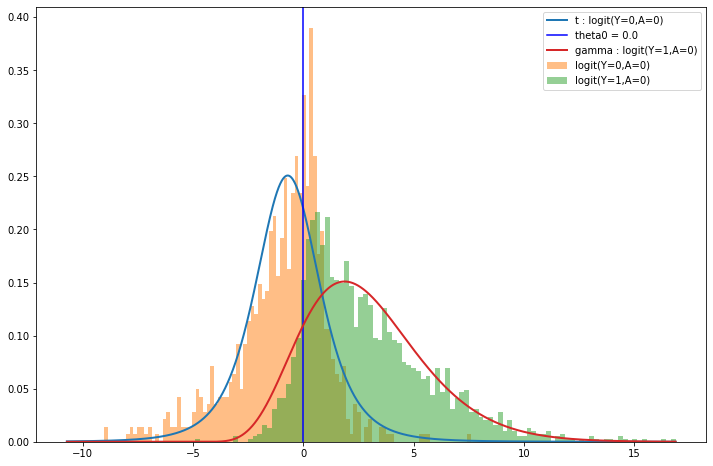


number of samples in A = 0
positive samples : 1778
negative samples : 848

Actual Performance: on A = 0
 TPR : 0.896
 FPR : 0.363
 ACC : 0.812

estimated distribution
t Y=0, A=1 : -2.327855
gamma Y=0, A=1 : -2.424932
normal Y=0, A=1 : -2.327758
exp Y=0, A=1 : -3.018734
t Y=1, A=1 : -2.078301
gamma Y=1, A=1 : -2.162002
normal Y=1, A=1 : -2.145797
exp Y=1, A=1 : -2.706287


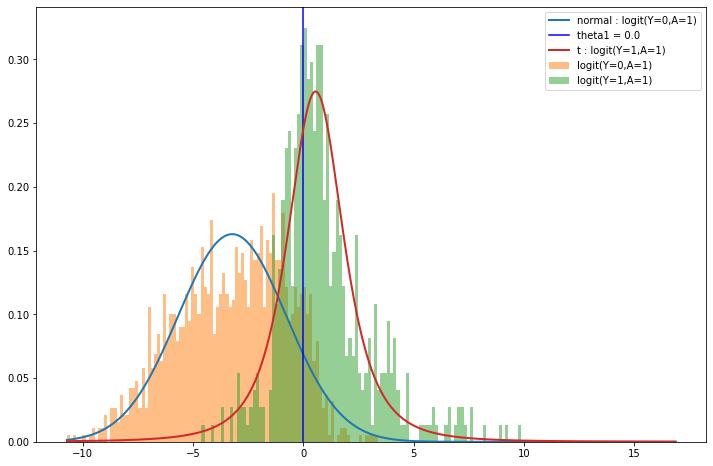


number of samples in A = 1
positive samples : 510
negative samples : 1344

Actual Performance: on A = 1
 TPR : 0.663
 FPR : 0.095
 ACC : 0.838

estimated distribution
 TPR : 0.648
 FPR : 0.094
 ACC : 0.835

{'n00': 379, 'n01': 511, 'n10': 854, 'n11': 176}
t Y=0, A=0 : -2.063219
gamma Y=0, A=0 : -2.342573
normal Y=0, A=0 : -2.075229
exp Y=0, A=0 : -2.931540
t Y=1, A=0 : -2.489585
gamma Y=1, A=0 : -2.460283
normal Y=1, A=0 : -2.500230
exp Y=1, A=0 : -2.931190


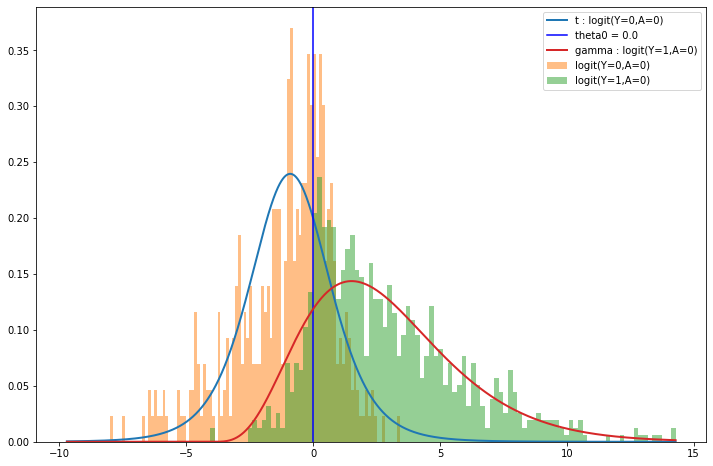


number of samples in A = 0
positive samples : 854
negative samples : 379

Actual Performance: on A = 0
 TPR : 0.879
 FPR : 0.325
 ACC : 0.817

estimated distribution
t Y=0, A=1 : -2.291154
gamma Y=0, A=1 : -2.467928
normal Y=0, A=1 : -2.290800
exp Y=0, A=1 : -2.877207
t Y=1, A=1 : -2.070083
gamma Y=1, A=1 : -2.442353
normal Y=1, A=1 : -2.142760
exp Y=1, A=1 : -2.992796


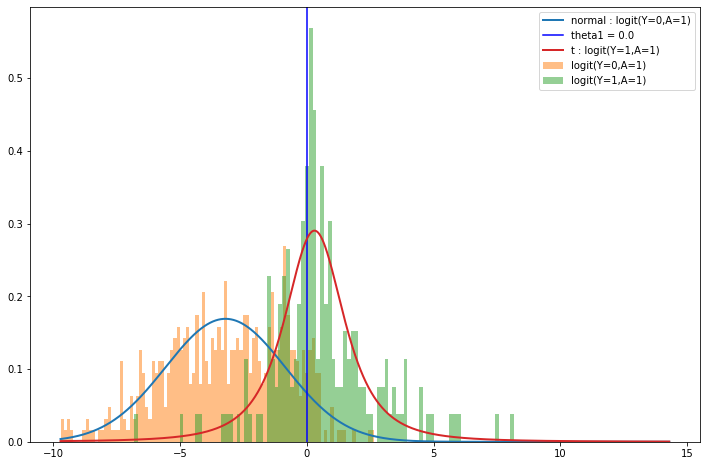


number of samples in A = 1
positive samples : 176
negative samples : 511

Actual Performance: on A = 1
 TPR : 0.614
 FPR : 0.082
 ACC : 0.840

estimated distribution
 TPR : 0.587
 FPR : 0.087
 ACC : 0.829



In [381]:
A_config, sample_config, dist_config = gen_config(train_logit, train_sens, train_label)
A_config_valid, sample_valid, dist_valid = gen_config(valid_logit, valid_sens, valid_label)

In [ ]:
lr = 1e-1
iter_num = 1e5

lamda = 0

theta = np.array([[ 0.87737922],
       [-0.47554275]])

    #GSTAR
    overall TPR : 0.882
    priv TPR : 0.637
    unpriv TPR : 0.937
    Eq. Opp : 0.300

    overall FPR : 0.249
    priv FPR : 0.107
    unpriv FPR : 0.447
    diff FPR : 0.340

    overall ACC : 0.821
    priv ACC : 0.824
    unpriv ACC : 0.820
    diff ACC : 0.004

    #baseline
    overall TPR : 0.881
    priv TPR : 0.744
    unpriv TPR : 0.936
    Eq. Opp : 0.192

    overall FPR : 0.247
    priv FPR : 0.149
    unpriv FPR : 0.469
    diff FPR : 0.321

    overall ACC : 0.812
    priv ACC : 0.823
    unpriv ACC : 0.802
    diff ACC : 0.021
        
lr = 1e-2
iter_num = int(3e3)
verbose_iter = 1e3

A = A_EOp
lamda = 1e1
theta = np.array([[-0.81117384],
       [ 0.44978534]])       
    
    #GSTAR
    overall TPR : 0.793
    priv TPR : 0.760
    unpriv TPR : 0.800
    Eq. Opp : 0.040

    overall FPR : 0.196
    priv FPR : 0.186
    unpriv FPR : 0.210
    diff FPR : 0.023

    overall ACC : 0.798
    priv ACC : 0.800
    unpriv ACC : 0.797
    diff ACC : 0.003


    #baseline
    overall TPR : 0.823
    priv TPR : 0.579
    unpriv TPR : 0.876
    Eq. Opp : 0.297

    overall FPR : 0.186
    priv FPR : 0.067
    unpriv FPR : 0.353
    diff FPR : 0.286

    overall ACC : 0.819
    priv ACC : 0.842
    unpriv ACC : 0.805
    diff ACC : 0.037

lr = 5e-3
iter_num = int(1e4)
verbose_iter = 1e4

lamda = 1e1
A = A_EOd
theta = np.array([[-0.49468307],
       [ 0.94041321]])
        
     #GSTAR   
    overall TPR : 0.696
    priv TPR : 0.716
    unpriv TPR : 0.692
    Eq. Opp : 0.024

    overall FPR : 0.126
    priv FPR : 0.143
    unpriv FPR : 0.103
    diff FPR : 0.039

    overall ACC : 0.780
    priv ACC : 0.821
    unpriv ACC : 0.756
    diff ACC : 0.065


    #baseline
    A_EOd : [0.15558866]
    overall TPR : 0.823
    priv TPR : 0.579
    unpriv TPR : 0.876
    Eq. Opp : 0.297

    overall FPR : 0.186
    priv FPR : 0.067
    unpriv FPR : 0.353
    diff FPR : 0.286

    overall ACC : 0.819
    priv ACC : 0.842
    unpriv ACC : 0.805
    diff ACC : 0.037

In [158]:
optim_dict = {'lr' : [2e-1, 1e-1, 5e-2, 1e-2, 1e-2, 5e-4], 'lamda' : [0, 1e-2, 1e-1, 5e-1, 1, 1e1], \
             'epoch' : [1e4, 1e4, 2e4, 5e3, 1e4, 3e4]}

In [126]:
len(optim_dict['lr'])

6

In [121]:
for i in (optim_dict.items()):
    print(i[0])

lr
lamda
epoch


{'n00': 826, 'n01': 1336, 'n10': 1805, 'n11': 513}
t Y=0, A=0 : -2.013167
gamma Y=0, A=0 : -2.271699
normal Y=0, A=0 : -2.038856
exp Y=0, A=0 : -2.999956
t Y=1, A=0 : -2.452249
gamma Y=1, A=0 : -2.406375
normal Y=1, A=0 : -2.466996
exp Y=1, A=0 : -2.979505


../FACT/utils.py:67: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  plt.hist(d, bins = 100, normed = True, label = 'logit(Y={},A={})'.format(group[0], group[1]), alpha = 0.5)
../FACT/utils.py:79: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  plt.hist(d, bins = 100, normed = True, label = 'logit(Y={},A={})'.format(group[0], group[1]), alpha = 0.5)


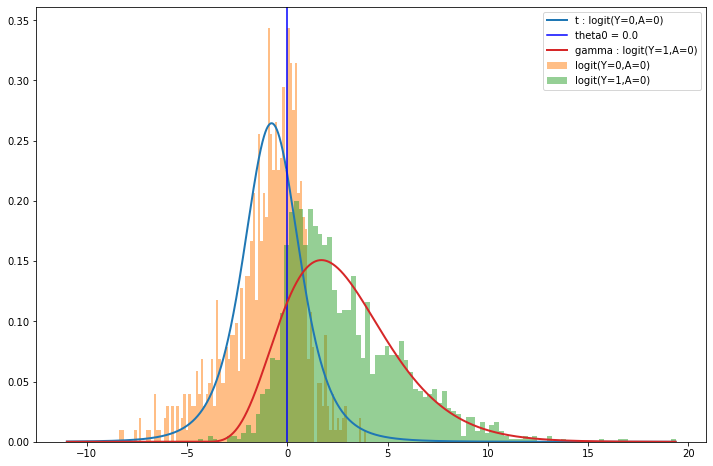


number of samples in A = 0
positive samples : 1805
negative samples : 826

Actual Performance: on A = 0
 TPR : 0.884
 FPR : 0.333
 ACC : 0.816

estimated distribution
t Y=0, A=1 : -2.300505
gamma Y=0, A=1 : -2.424198
normal Y=0, A=1 : -2.300369
exp Y=0, A=1 : -3.084506
t Y=1, A=1 : -2.095200
gamma Y=1, A=1 : -2.261314
normal Y=1, A=1 : -2.149874
exp Y=1, A=1 : -2.897906


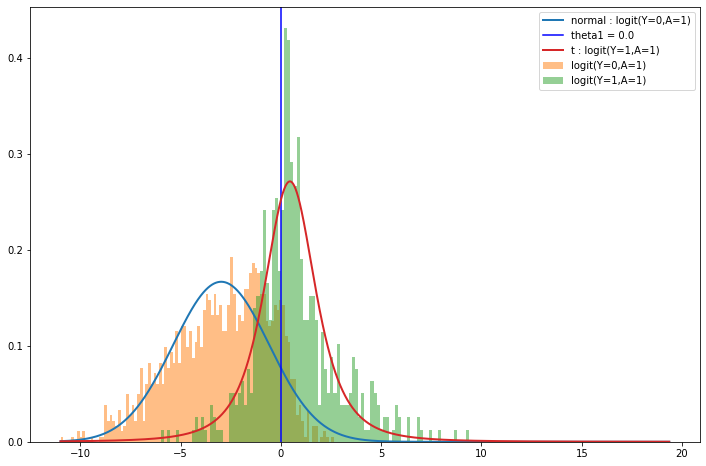


number of samples in A = 1
positive samples : 513
negative samples : 1336

Actual Performance: on A = 1
 TPR : 0.647
 FPR : 0.100
 ACC : 0.830

estimated distribution
 TPR : 0.619
 FPR : 0.107
 ACC : 0.817

[0/10000] loss : 0.037, dldt norm : 0.002
[[-0.00022799]
 [-0.00022315]]
[[0.00113993]
 [0.00111429]]



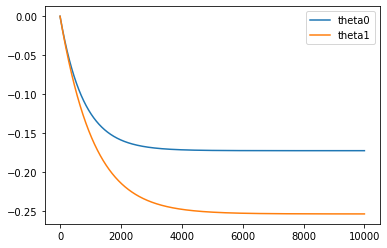

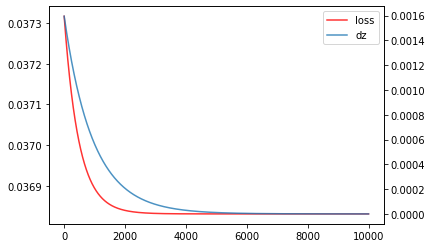

overall TPR : 0.842
priv TPR : 0.683
unpriv TPR : 0.878
Eq. Opp : 0.196

overall FPR : 0.206
priv FPR : 0.112
unpriv FPR : 0.358
diff FPR : 0.246

overall ACC : 0.819
priv ACC : 0.837
unpriv ACC : 0.808
diff ACC : 0.029



A_EOd : [0.59876291]
overall TPR : 0.815
priv TPR : 0.602
unpriv TPR : 0.864
Eq. Opp : 0.262

overall FPR : 0.173
priv FPR : 0.075
unpriv FPR : 0.332
diff FPR : 0.258

overall ACC : 0.821
priv ACC : 0.845
unpriv ACC : 0.805
diff ACC : 0.040



A_EOd : [0.66272949]
result celebA 
 0.5193742892589761 0.5382085446936059 0.8208333333333333 
 0.44181545611079154 0.46964184526137337 0.8192708333333333
[0/10000] loss : 0.038, dldt norm : 0.002
[[-1.86700718e-04]
 [-4.11491121e-05]]
[[0.00186701]
 [0.00041122]]



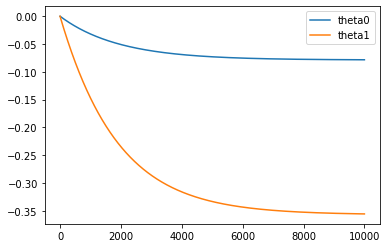

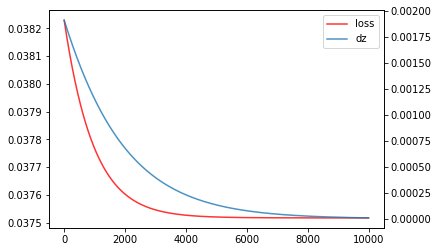

overall TPR : 0.838
priv TPR : 0.694
unpriv TPR : 0.871
Eq. Opp : 0.177

overall FPR : 0.205
priv FPR : 0.121
unpriv FPR : 0.341
diff FPR : 0.220

overall ACC : 0.818
priv ACC : 0.833
unpriv ACC : 0.808
diff ACC : 0.025



A_EOd : [0.55622818]
overall TPR : 0.815
priv TPR : 0.602
unpriv TPR : 0.864
Eq. Opp : 0.262

overall FPR : 0.173
priv FPR : 0.075
unpriv FPR : 0.332
diff FPR : 0.258

overall ACC : 0.821
priv ACC : 0.845
unpriv ACC : 0.805
diff ACC : 0.040



A_EOd : [0.66272949]
result celebA 
 0.5193742892589761 0.5382085446936059 0.8208333333333333 
 0.39769052611698863 0.4500483992890037 0.8177083333333334
[0/20000] loss : 0.046, dldt norm : 0.010
[[-0.00042054]
 [ 0.00029634]]
[[ 0.00841073]
 [-0.00592462]]

[10000/20000] loss : 0.040, dldt norm : 0.000
[[-0.64373665]
 [ 0.22393035]]
[[6.73470631e-05]
 [4.50028385e-05]]



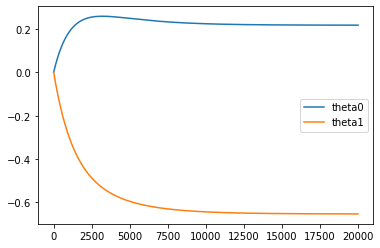

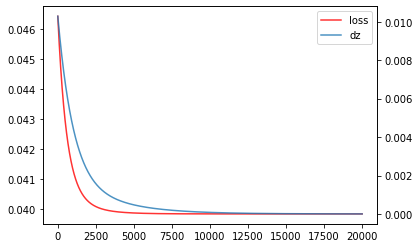

overall TPR : 0.809
priv TPR : 0.758
unpriv TPR : 0.820
Eq. Opp : 0.062

overall FPR : 0.201
priv FPR : 0.165
unpriv FPR : 0.258
diff FPR : 0.093

overall ACC : 0.804
priv ACC : 0.816
unpriv ACC : 0.797
diff ACC : 0.019



A_EOd : [0.32177007]
overall TPR : 0.815
priv TPR : 0.602
unpriv TPR : 0.864
Eq. Opp : 0.262

overall FPR : 0.173
priv FPR : 0.075
unpriv FPR : 0.332
diff FPR : 0.258

overall ACC : 0.821
priv ACC : 0.845
unpriv ACC : 0.805
diff ACC : 0.040



A_EOd : [0.66272949]
result celebA 
 0.5193742892589761 0.5382085446936059 0.8208333333333333 
 0.1545799773428401 0.3400172618430038 0.8041666666666667
[0/5000] loss : 0.083, dldt norm : 0.051
[[-0.00037494]
 [ 0.00034097]]
[[ 0.03749393]
 [-0.03409336]]



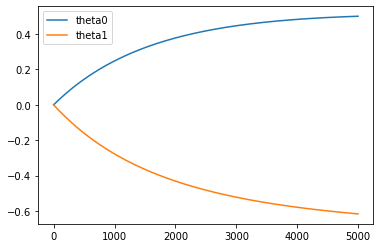

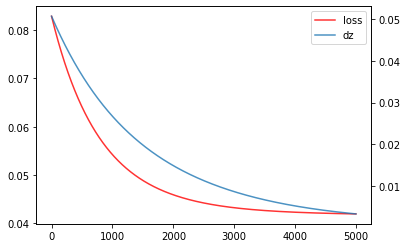

overall TPR : 0.762
priv TPR : 0.737
unpriv TPR : 0.768
Eq. Opp : 0.031

overall FPR : 0.156
priv FPR : 0.158
unpriv FPR : 0.152
diff FPR : 0.006

overall ACC : 0.801
priv ACC : 0.816
unpriv ACC : 0.792
diff ACC : 0.024



A_EOd : [0.19828684]
overall TPR : 0.815
priv TPR : 0.602
unpriv TPR : 0.864
Eq. Opp : 0.262

overall FPR : 0.173
priv FPR : 0.075
unpriv FPR : 0.332
diff FPR : 0.258

overall ACC : 0.821
priv ACC : 0.845
unpriv ACC : 0.805
diff ACC : 0.040



A_EOd : [0.66272949]
result celebA 
 0.5193742892589761 0.5382085446936059 0.8208333333333333 
 0.03730000385904861 0.28238049252119835 0.8010416666666667
[0/10000] loss : 0.128, dldt norm : 0.101
[[-0.00073848]
 [ 0.0006931 ]]
[[ 0.07384792]
 [-0.06929888]]



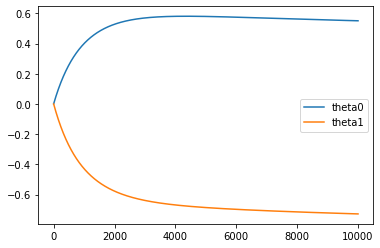

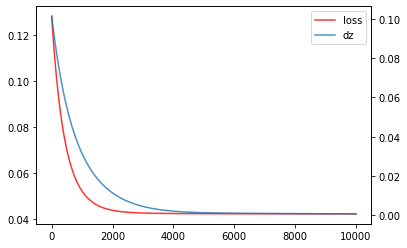

overall TPR : 0.753
priv TPR : 0.769
unpriv TPR : 0.749
Eq. Opp : 0.019

overall FPR : 0.166
priv FPR : 0.178
unpriv FPR : 0.146
diff FPR : 0.031

overall ACC : 0.792
priv ACC : 0.809
unpriv ACC : 0.781
diff ACC : 0.029



A_EOd : [0.17646711]
overall TPR : 0.815
priv TPR : 0.602
unpriv TPR : 0.864
Eq. Opp : 0.262

overall FPR : 0.173
priv FPR : 0.075
unpriv FPR : 0.332
diff FPR : 0.258

overall ACC : 0.821
priv ACC : 0.845
unpriv ACC : 0.805
diff ACC : 0.040



A_EOd : [0.66272949]
result celebA 
 0.5193742892589761 0.5382085446936059 0.8208333333333333 
 0.050913565077628814 0.2451660568774307 0.7916666666666666
[0/30000] loss : 0.949, dldt norm : 1.012
[[-0.00036411]
 [ 0.00035157]]
[[ 0.72821989]
 [-0.7031079 ]]

[10000/30000] loss : 0.044, dldt norm : 0.010
[[-0.66552257]
 [ 0.67279219]]
[[ 0.00527209]
 [-0.00852223]]

[20000/30000] loss : 0.044, dldt norm : 0.002
[[-0.66613022]
 [ 0.688386  ]]
[[-0.00129991]
 [-0.00150191]]



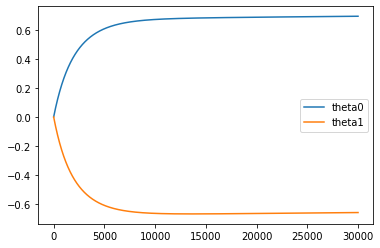

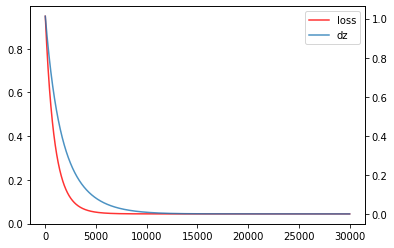

overall TPR : 0.718
priv TPR : 0.758
unpriv TPR : 0.709
Eq. Opp : 0.049

overall FPR : 0.154
priv FPR : 0.165
unpriv FPR : 0.135
diff FPR : 0.031

overall ACC : 0.779
priv ACC : 0.816
unpriv ACC : 0.756
diff ACC : 0.060



A_EOd : [0.14197853]
overall TPR : 0.815
priv TPR : 0.602
unpriv TPR : 0.864
Eq. Opp : 0.262

overall FPR : 0.173
priv FPR : 0.075
unpriv FPR : 0.332
diff FPR : 0.258

overall ACC : 0.821
priv ACC : 0.845
unpriv ACC : 0.805
diff ACC : 0.040



A_EOd : [0.66272949]
result celebA 
 0.5193742892589761 0.5382085446936059 0.8208333333333333 
 0.07933478781865702 0.2255851525347204 0.7791666666666667
{'n00': 858, 'n01': 1323, 'n10': 1790, 'n11': 509}
t Y=0, A=0 : -2.015471
gamma Y=0, A=0 : -2.324685
normal Y=0, A=0 : -2.073829
exp Y=0, A=0 : -3.229237
t Y=1, A=0 : -2.411008
gamma Y=1, A=0 : -2.368185
normal Y=1, A=0 : -2.420855
exp Y=1, A=0 : -2.893044


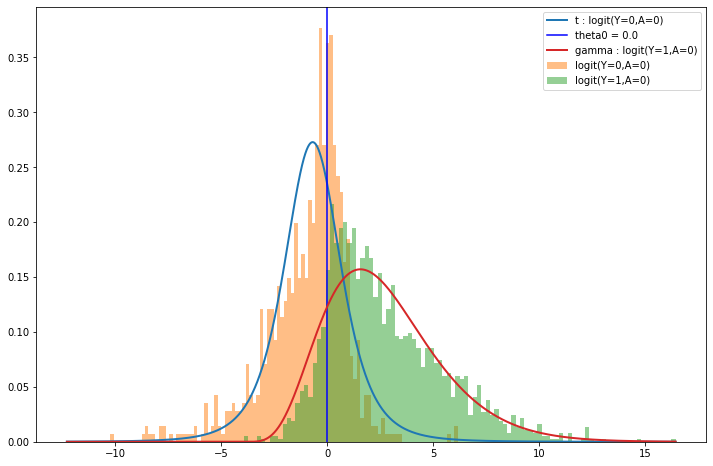


number of samples in A = 0
positive samples : 1790
negative samples : 858

Actual Performance: on A = 0
 TPR : 0.882
 FPR : 0.344
 ACC : 0.809

estimated distribution
t Y=0, A=1 : -2.317703
gamma Y=0, A=1 : -2.421623
normal Y=0, A=1 : -2.317593
exp Y=0, A=1 : -3.216855
t Y=1, A=1 : -2.078025
gamma Y=1, A=1 : -2.177378
normal Y=1, A=1 : -2.148435
exp Y=1, A=1 : -2.767093


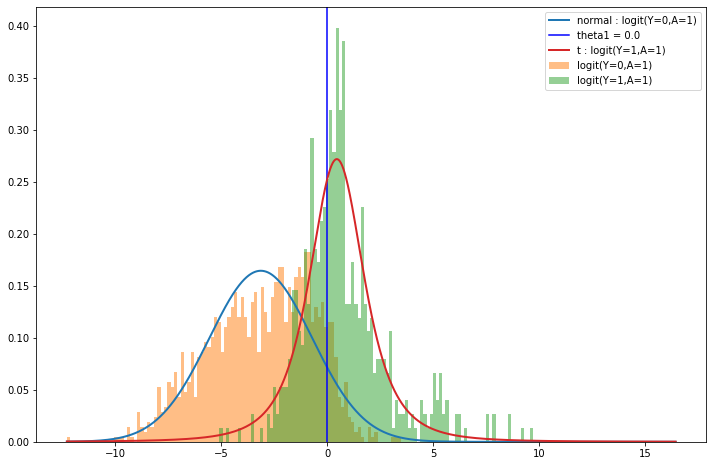


number of samples in A = 1
positive samples : 509
negative samples : 1323

Actual Performance: on A = 1
 TPR : 0.640
 FPR : 0.092
 ACC : 0.834

estimated distribution
 TPR : 0.620
 FPR : 0.098
 ACC : 0.823

[0/10000] loss : 0.038, dldt norm : 0.002
[[-0.00029587]
 [-0.00016418]]
[[0.00147936]
 [0.00081975]]



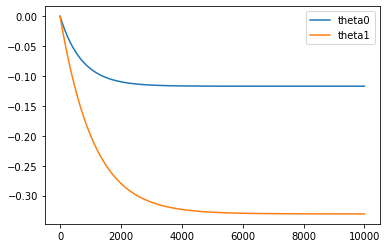

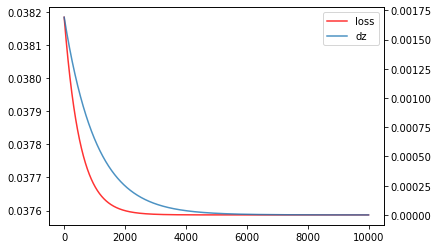

overall TPR : 0.861
priv TPR : 0.725
unpriv TPR : 0.891
Eq. Opp : 0.165

overall FPR : 0.237
priv FPR : 0.149
unpriv FPR : 0.349
diff FPR : 0.200

overall ACC : 0.814
priv ACC : 0.818
unpriv ACC : 0.812
diff ACC : 0.006



A_EOd : [0.59979651]
overall TPR : 0.834
priv TPR : 0.637
unpriv TPR : 0.877
Eq. Opp : 0.240

overall FPR : 0.190
priv FPR : 0.100
unpriv FPR : 0.304
diff FPR : 0.205

overall ACC : 0.822
priv ACC : 0.831
unpriv ACC : 0.817
diff ACC : 0.014



A_EOd : [0.65394468]
result celebA 
 0.4445667532019264 0.531886964207971 0.8223958333333333 
 0.36565117679014913 0.41216213832350757 0.8140625
[0/10000] loss : 0.039, dldt norm : 0.002
[[-2.20859579e-04]
 [-1.90263800e-06]]
[[2.20859579e-03]
 [1.90126107e-05]]



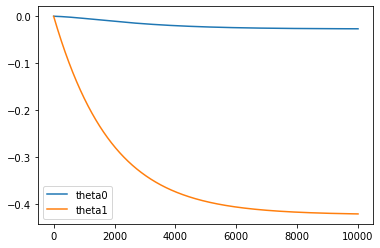

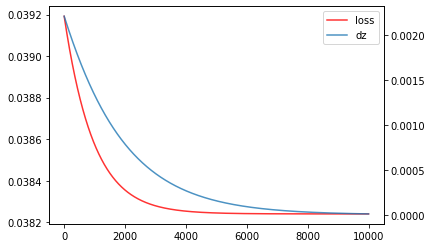

overall TPR : 0.854
priv TPR : 0.736
unpriv TPR : 0.880
Eq. Opp : 0.143

overall FPR : 0.228
priv FPR : 0.159
unpriv FPR : 0.317
diff FPR : 0.158

overall ACC : 0.815
priv ACC : 0.814
unpriv ACC : 0.815
diff ACC : 0.001



A_EOd : [0.53472449]
overall TPR : 0.834
priv TPR : 0.637
unpriv TPR : 0.877
Eq. Opp : 0.240

overall FPR : 0.190
priv FPR : 0.100
unpriv FPR : 0.304
diff FPR : 0.205

overall ACC : 0.822
priv ACC : 0.831
unpriv ACC : 0.817
diff ACC : 0.014



A_EOd : [0.65394468]
result celebA 
 0.4445667532019264 0.531886964207971 0.8223958333333333 
 0.30176361070914265 0.3841312178720492 0.8145833333333333
[0/20000] loss : 0.048, dldt norm : 0.011
[[-0.00043859]
 [ 0.0003599 ]]
[[ 0.00877174]
 [-0.00719494]]

[10000/20000] loss : 0.041, dldt norm : 0.000
[[-0.67593771]
 [ 0.27132614]]
[[8.02047702e-05]
 [4.53618983e-05]]



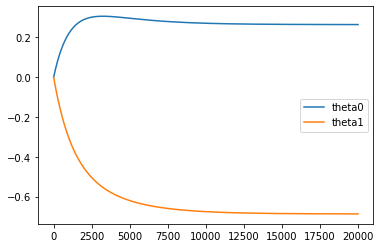

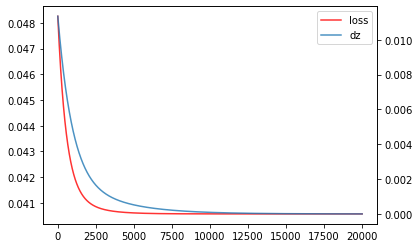

overall TPR : 0.819
priv TPR : 0.775
unpriv TPR : 0.829
Eq. Opp : 0.054

overall FPR : 0.202
priv FPR : 0.196
unpriv FPR : 0.210
diff FPR : 0.015

overall ACC : 0.809
priv ACC : 0.797
unpriv ACC : 0.816
diff ACC : 0.019



A_EOd : [0.2974385]
overall TPR : 0.834
priv TPR : 0.637
unpriv TPR : 0.877
Eq. Opp : 0.240

overall FPR : 0.190
priv FPR : 0.100
unpriv FPR : 0.304
diff FPR : 0.205

overall ACC : 0.822
priv ACC : 0.831
unpriv ACC : 0.817
diff ACC : 0.014



A_EOd : [0.65394468]
result celebA 
 0.4445667532019264 0.531886964207971 0.8223958333333333 
 0.06865162579276787 0.2773385267272799 0.8088541666666667
[0/5000] loss : 0.089, dldt norm : 0.055
[[-0.00037941]
 [ 0.00039273]]
[[ 0.03794129]
 [-0.03926814]]



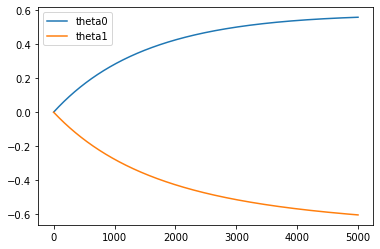

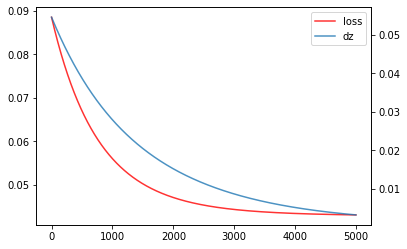

overall TPR : 0.768
priv TPR : 0.758
unpriv TPR : 0.770
Eq. Opp : 0.012

overall FPR : 0.158
priv FPR : 0.182
unpriv FPR : 0.129
diff FPR : 0.053

overall ACC : 0.803
priv ACC : 0.802
unpriv ACC : 0.804
diff ACC : 0.001



A_EOd : [0.21643726]
overall TPR : 0.834
priv TPR : 0.637
unpriv TPR : 0.877
Eq. Opp : 0.240

overall FPR : 0.190
priv FPR : 0.100
unpriv FPR : 0.304
diff FPR : 0.205

overall ACC : 0.822
priv ACC : 0.831
unpriv ACC : 0.817
diff ACC : 0.014



A_EOd : [0.65394468]
result celebA 
 0.4445667532019264 0.531886964207971 0.8223958333333333 
 0.06539382595710411 0.22575387123064394 0.803125
[0/10000] loss : 0.139, dldt norm : 0.109
[[-0.00074403]
 [ 0.00079368]]
[[ 0.07440323]
 [-0.07935209]]



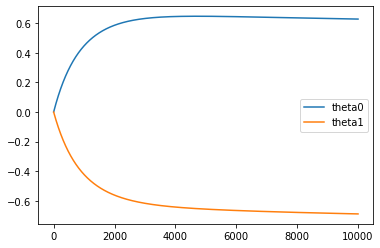

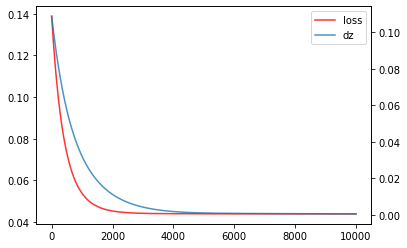

overall TPR : 0.757
priv TPR : 0.775
unpriv TPR : 0.753
Eq. Opp : 0.021

overall FPR : 0.160
priv FPR : 0.196
unpriv FPR : 0.114
diff FPR : 0.082

overall ACC : 0.797
priv ACC : 0.797
unpriv ACC : 0.797
diff ACC : 0.001



A_EOd : [0.21309796]
overall TPR : 0.834
priv TPR : 0.637
unpriv TPR : 0.877
Eq. Opp : 0.240

overall FPR : 0.190
priv FPR : 0.100
unpriv FPR : 0.304
diff FPR : 0.205

overall ACC : 0.822
priv ACC : 0.831
unpriv ACC : 0.817
diff ACC : 0.014



A_EOd : [0.65394468]
result celebA 
 0.4445667532019264 0.531886964207971 0.8223958333333333 
 0.10321717105046448 0.1950239383002219 0.796875
[0/30000] loss : 1.045, dldt norm : 1.084
[[-0.00036536]
 [ 0.00040053]]
[[ 0.73071809]
 [-0.80101218]]

[10000/30000] loss : 0.053, dldt norm : 0.013
[[-0.61888066]
 [ 0.75135978]]
[[-0.00135371]
 [-0.01323478]]

[20000/30000] loss : 0.052, dldt norm : 0.009
[[-0.59151043]
 [ 0.79051571]]
[[-0.00627631]
 [-0.00607388]]



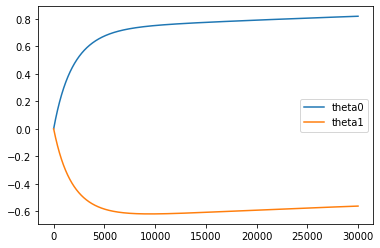

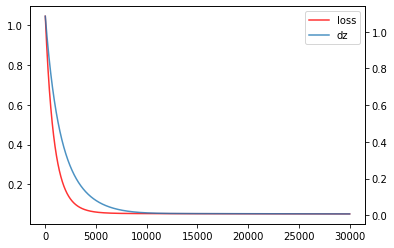

overall TPR : 0.718
priv TPR : 0.747
unpriv TPR : 0.712
Eq. Opp : 0.035

overall FPR : 0.141
priv FPR : 0.174
unpriv FPR : 0.099
diff FPR : 0.075

overall ACC : 0.785
priv ACC : 0.805
unpriv ACC : 0.774
diff ACC : 0.031



A_EOd : [0.18861509]
overall TPR : 0.834
priv TPR : 0.637
unpriv TPR : 0.877
Eq. Opp : 0.240

overall FPR : 0.190
priv FPR : 0.100
unpriv FPR : 0.304
diff FPR : 0.205

overall ACC : 0.822
priv ACC : 0.831
unpriv ACC : 0.817
diff ACC : 0.014



A_EOd : [0.65394468]
result celebA 
 0.4445667532019264 0.531886964207971 0.8223958333333333 
 0.11038198211472879 0.18551212438742992 0.7854166666666667
{'n00': 848, 'n01': 1344, 'n10': 1778, 'n11': 510}
t Y=0, A=0 : -2.090542
gamma Y=0, A=0 : -2.359794
normal Y=0, A=0 : -2.131938
exp Y=0, A=0 : -3.092294
t Y=1, A=0 : -2.445631
gamma Y=1, A=0 : -2.402858
normal Y=1, A=0 : -2.467063
exp Y=1, A=0 : -3.052563


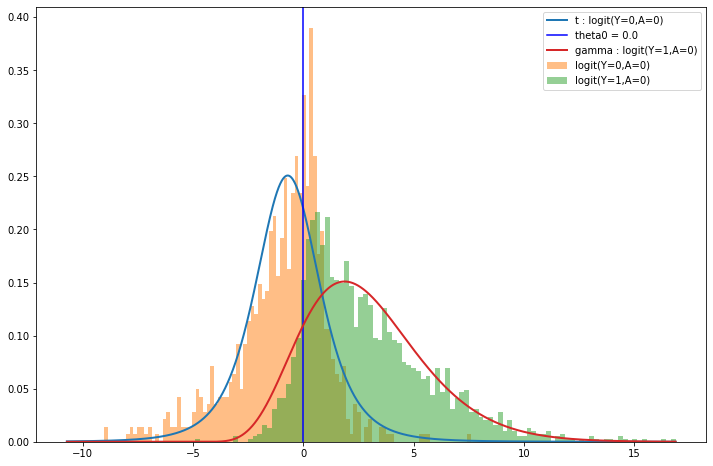


number of samples in A = 0
positive samples : 1778
negative samples : 848

Actual Performance: on A = 0
 TPR : 0.896
 FPR : 0.363
 ACC : 0.812

estimated distribution
t Y=0, A=1 : -2.327855
gamma Y=0, A=1 : -2.424932
normal Y=0, A=1 : -2.327758
exp Y=0, A=1 : -3.018734
t Y=1, A=1 : -2.078301
gamma Y=1, A=1 : -2.162002
normal Y=1, A=1 : -2.145797
exp Y=1, A=1 : -2.706287


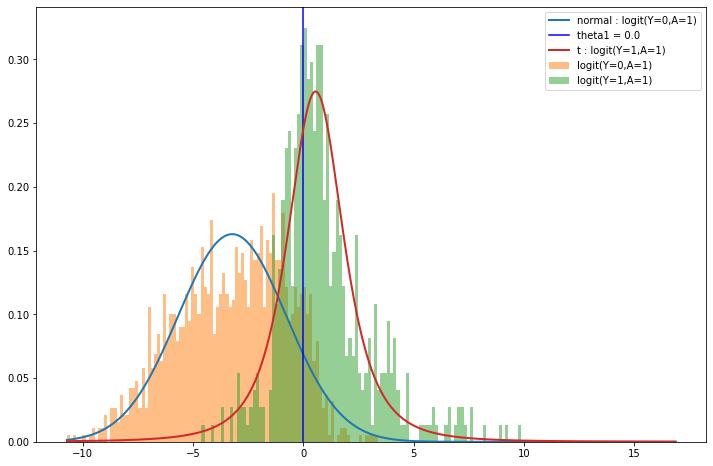


number of samples in A = 1
positive samples : 510
negative samples : 1344

Actual Performance: on A = 1
 TPR : 0.663
 FPR : 0.095
 ACC : 0.838

estimated distribution
 TPR : 0.648
 FPR : 0.094
 ACC : 0.835

[0/10000] loss : 0.035, dldt norm : 0.001
[[-2.72806138e-04]
 [-7.48950370e-05]]
[[0.00136403]
 [0.00037403]]



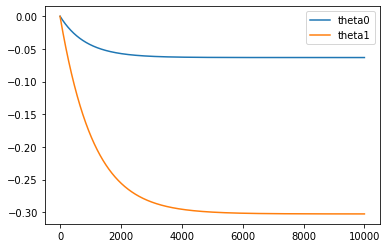

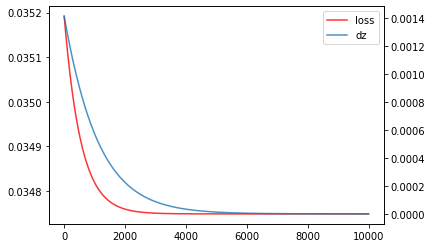

overall TPR : 0.859
priv TPR : 0.722
unpriv TPR : 0.888
Eq. Opp : 0.166

overall FPR : 0.210
priv FPR : 0.112
unpriv FPR : 0.343
diff FPR : 0.231

overall ACC : 0.827
priv ACC : 0.846
unpriv ACC : 0.817
diff ACC : 0.029



A_EOd : [0.67245097]
overall TPR : 0.834
priv TPR : 0.614
unpriv TPR : 0.879
Eq. Opp : 0.266

overall FPR : 0.185
priv FPR : 0.082
unpriv FPR : 0.325
diff FPR : 0.242

overall ACC : 0.825
priv ACC : 0.840
unpriv ACC : 0.817
diff ACC : 0.023



A_EOd : [0.75697339]
result celebA 
 0.5081012148194926 0.5878120298960441 0.825 
 0.39745884023210776 0.4523634972747267 0.8270833333333333
[0/10000] loss : 0.036, dldt norm : 0.002
[[-2.03943283e-04]
 [ 3.75543480e-05]]
[[ 0.00203943]
 [-0.00037532]]



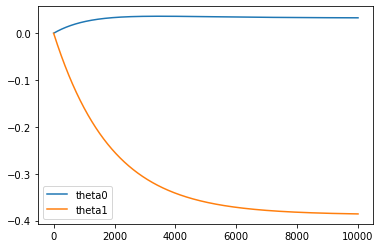

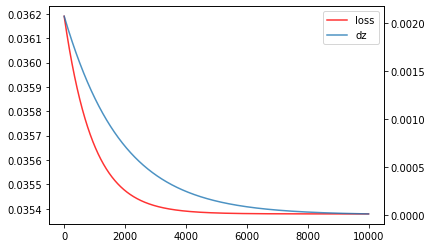

overall TPR : 0.850
priv TPR : 0.727
unpriv TPR : 0.876
Eq. Opp : 0.149

overall FPR : 0.197
priv FPR : 0.115
unpriv FPR : 0.306
diff FPR : 0.191

overall ACC : 0.829
priv ACC : 0.844
unpriv ACC : 0.820
diff ACC : 0.024



A_EOd : [0.61275822]
overall TPR : 0.834
priv TPR : 0.614
unpriv TPR : 0.879
Eq. Opp : 0.266

overall FPR : 0.185
priv FPR : 0.082
unpriv FPR : 0.325
diff FPR : 0.242

overall ACC : 0.825
priv ACC : 0.840
unpriv ACC : 0.817
diff ACC : 0.023



A_EOd : [0.75697339]
result celebA 
 0.5081012148194926 0.5878120298960441 0.825 
 0.3392142118677312 0.42853196485300526 0.8286458333333333
[0/20000] loss : 0.045, dldt norm : 0.011
[[-0.0004059 ]
 [ 0.00035629]]
[[ 0.00811805]
 [-0.00712322]]

[10000/20000] loss : 0.038, dldt norm : 0.000
[[-0.62749857]
 [ 0.35824029]]
[[7.15115490e-05]
 [4.06706112e-05]]



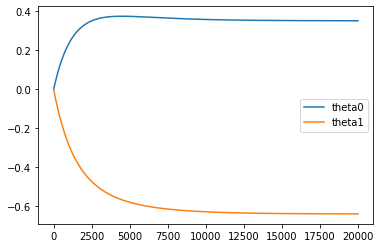

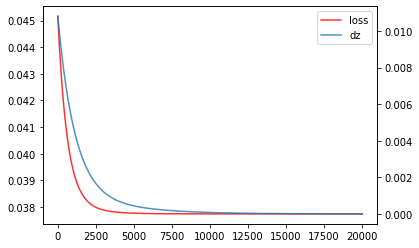

overall TPR : 0.793
priv TPR : 0.756
unpriv TPR : 0.801
Eq. Opp : 0.045

overall FPR : 0.175
priv FPR : 0.155
unpriv FPR : 0.203
diff FPR : 0.049

overall ACC : 0.808
priv ACC : 0.822
unpriv ACC : 0.800
diff ACC : 0.023



A_EOd : [0.36385935]
overall TPR : 0.834
priv TPR : 0.614
unpriv TPR : 0.879
Eq. Opp : 0.266

overall FPR : 0.185
priv FPR : 0.082
unpriv FPR : 0.325
diff FPR : 0.242

overall ACC : 0.825
priv ACC : 0.840
unpriv ACC : 0.817
diff ACC : 0.023



A_EOd : [0.75697339]
result celebA 
 0.5081012148194926 0.5878120298960441 0.825 
 0.09382235104929104 0.308605772125359 0.8078125
[0/5000] loss : 0.085, dldt norm : 0.051
[[-0.00035134]
 [ 0.00037126]]
[[ 0.03513414]
 [-0.03712233]]



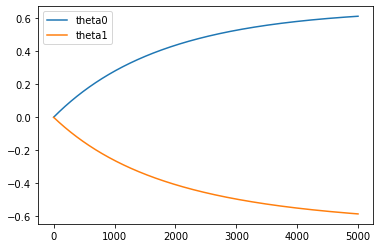

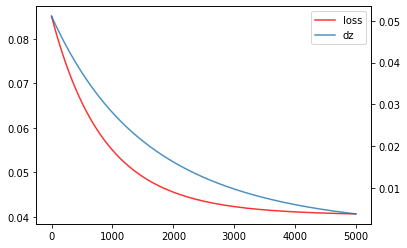

overall TPR : 0.748
priv TPR : 0.750
unpriv TPR : 0.747
Eq. Opp : 0.003

overall FPR : 0.151
priv FPR : 0.145
unpriv FPR : 0.158
diff FPR : 0.013

overall ACC : 0.795
priv ACC : 0.828
unpriv ACC : 0.776
diff ACC : 0.052



A_EOd : [0.26997089]
overall TPR : 0.834
priv TPR : 0.614
unpriv TPR : 0.879
Eq. Opp : 0.266

overall FPR : 0.185
priv FPR : 0.082
unpriv FPR : 0.325
diff FPR : 0.242

overall ACC : 0.825
priv ACC : 0.840
unpriv ACC : 0.817
diff ACC : 0.023



A_EOd : [0.75697339]
result celebA 
 0.5081012148194926 0.5878120298960441 0.825 
 0.016424656095252538 0.2662445060685586 0.7947916666666667
[0/10000] loss : 0.135, dldt norm : 0.102
[[-0.00068904]
 [ 0.00074627]]
[[ 0.06890424]
 [-0.07461525]]



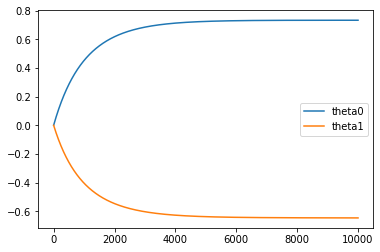

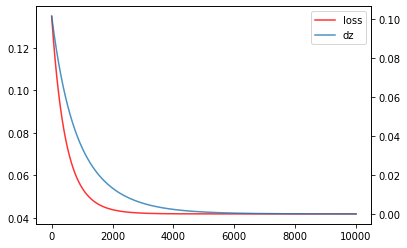

overall TPR : 0.731
priv TPR : 0.756
unpriv TPR : 0.726
Eq. Opp : 0.030

overall FPR : 0.143
priv FPR : 0.157
unpriv FPR : 0.124
diff FPR : 0.033

overall ACC : 0.790
priv ACC : 0.821
unpriv ACC : 0.772
diff ACC : 0.049



A_EOd : [0.21471655]
overall TPR : 0.834
priv TPR : 0.614
unpriv TPR : 0.879
Eq. Opp : 0.266

overall FPR : 0.185
priv FPR : 0.082
unpriv FPR : 0.325
diff FPR : 0.242

overall ACC : 0.825
priv ACC : 0.840
unpriv ACC : 0.817
diff ACC : 0.023



A_EOd : [0.75697339]
result celebA 
 0.5081012148194926 0.5878120298960441 0.825 
 0.062231720926986867 0.23091334728729945 0.7895833333333333
[0/30000] loss : 1.033, dldt norm : 1.010
[[-0.00033838]
 [ 0.00037482]]
[[ 0.67676617]
 [-0.74960337]]

[10000/30000] loss : 0.060, dldt norm : 0.021
[[-0.61607856]
 [ 0.81245884]]
[[-0.00258683]
 [-0.02058286]]

[20000/30000] loss : 0.057, dldt norm : 0.014
[[-0.57239075]
 [ 0.87495899]]
[[-0.01023254]
 [-0.00972795]]



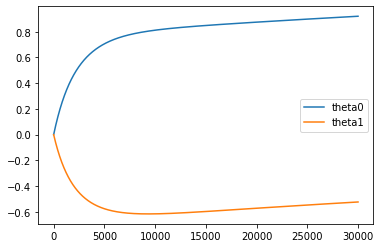

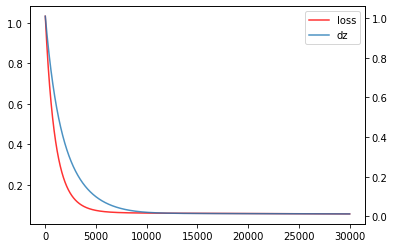

overall TPR : 0.700
priv TPR : 0.744
unpriv TPR : 0.691
Eq. Opp : 0.053

overall FPR : 0.120
priv FPR : 0.139
unpriv FPR : 0.095
diff FPR : 0.044

overall ACC : 0.783
priv ACC : 0.831
unpriv ACC : 0.757
diff ACC : 0.074



A_EOd : [0.1991391]
overall TPR : 0.834
priv TPR : 0.614
unpriv TPR : 0.879
Eq. Opp : 0.266

overall FPR : 0.185
priv FPR : 0.082
unpriv FPR : 0.325
diff FPR : 0.242

overall ACC : 0.825
priv ACC : 0.840
unpriv ACC : 0.817
diff ACC : 0.023



A_EOd : [0.75697339]
result celebA 
 0.5081012148194926 0.5878120298960441 0.825 
 0.09740811242396695 0.21367276178738265 0.7833333333333333


In [209]:
# lamda = 1e2
eval_dict = {}

lamda_hist = {}

eq_odd_hist = {}
eq_opp_hist = {}
dp_hist = {}
acc_hist = {}

repeat_num = 3

for repeat in range(repeat_num):
    train_logit, train_sens, train_label, valid_logit, valid_sens, valid_label, \
    test_logit, test_sens, test_label = gen_samples(trainloader_GSTAR, validloader_GSTAR, testloader_GSTAR)
    
    logit_shape = True

    if logit_shape:
        theta_0 = np.zeros((2,1))
    else:
        theta_0 = np.zeros((2,1))+0.5

    idx_a = (train_sens == 1)
    idx_y = train_label == 1

    n00 = sum(~idx_a*~idx_y)
    n10 = sum(~idx_a*idx_y)
    n01 = sum(idx_a*~idx_y)
    n11 = sum(idx_a*idx_y)
    N = n00 + n10 + n01 + n11

    sample_config = {'n00':n00, 'n01':n01, 'n10':n10, 'n11':n11}
    print(sample_config)
    
    dist_config = {}

    A_EOp =  N * np.array([1/n11,0,0,0,-1/n10,0,0,0]).reshape(-1,1)
    A_PE =  N * np.array([0,0,1/n01,0, 0,0,-1/n00,0]).reshape(-1,1)
    A_EOd = np.concatenate((A_EOp, A_PE), axis = 1)
    A_DP =  N * np.array([1/(n11+n01), 0, 1/(n11+n01), 0, -1/(n10+n00), 0, -1/(n10+n00), 0]).reshape(-1,1)

    c = np.array([0, 1, 1, 0, 0, 1, 1, 0]).reshape(-1,1)

    dist_estimate(train_logit, train_label, train_sens, '0', theta_0, DATANAME, sample_config, dist_config, \
                  logit_form = logit_shape, save_fig = True);
    dist_estimate(train_logit, train_label, train_sens, '1', theta_0, DATANAME, sample_config, dist_config, \
                  logit_form = logit_shape, save_fig = True);
    
    
    for i in range(len(optim_dict['lr'])):
        for cnst_name in ['eod']:
            lamda = optim_dict['lamda'][i]
            
            if repeat == 0:
                lamda_hist[lamda] = []
                eq_odd_hist[lamda] = []
                eq_opp_hist[lamda] = []
                dp_hist[lamda] = []
                acc_hist[lamda] = []

            lr = optim_dict['lr'][i]
            iter_num = int(optim_dict['epoch'][i])
            verbose_iter = 1e4

            

            if cnst_name == 'eod':
                A = A_EOd
            elif cnst_name == 'dp':
                A = A_DP
            elif cnst_name =='dp+eod':
                A = np.concatenate((A_EOd, A_DP), 1)
            elif cnst_name == 'eop':
                A = A_EOp

            theta, thet = train(theta_0.copy(), A, c, lamda, sample_config, dist_config, lr, iter_num, verbose_iter, verbose = True, show_fig = True)

            z, ACC, EOd = evaluate(valid_logit, valid_label, valid_sens, A, theta, verbose = True, logit_form = logit_shape)

            if logit_shape:
                z_orig, ACC_orig, EOd_orig =  evaluate(valid_logit, valid_label, valid_sens, A, np.zeros((2,1)), verbose = True, logit_form = logit_shape)
            else:
                z_orig, ACC_orig, EOd_orig =  evaluate(valid_logit, valid_label, valid_sens, A, np.zeros((2,1))+0.5, verbose = True, logit_form = logit_shape)

            ###### z[0+2]/(z[1+2]+z[0+2]) = z[0+2]/n11?
            eq_opps = abs(z[0+2]/(z[1+2]+z[0+2]) - z[0+2+4]/(z[1+2+4]+z[0+2+4]))
            eq_opps_orig = abs(z_orig[0+2]/(z_orig[1+2]+z_orig[0+2]) - z_orig[0+2+4]/(z_orig[1+2+4]+z_orig[0+2+4]))
            dist = abs(z[0+2]/(z[1+2]+z[0+2]) - z[0+2+4]/(z[1+2+4]+z[0+2+4])) + abs(z[0]/(z[1]+z[0]) - z[0+4]/(z[1+4]+z[0+4]))
            dist_orig = abs(z_orig[0+2]/(z_orig[1+2]+z_orig[0+2]) - z_orig[0+2+4]/(z_orig[1+2+4]+z_orig[0+2+4])) + abs(z_orig[0]/(z_orig[1]+z_orig[0]) - z_orig[0+4]/(z_orig[1+4]+z_orig[0+4]))
            dp = abs(((z[0] + z[2])/(sum(z[0:4])) - (z[0+4] + z[2+4])/(sum(z[4:8]))))
            dp_orig = abs(((z_orig[0] + z_orig[2])/(sum(z_orig[0:4])) - (z_orig[0+4] + z_orig[2+4])/(sum(z_orig[4:8]))))

            eval_dict[cnst_name] = dist.item(), dp.item(), ACC
            eval_dict['orig'] = dist_orig.item(), dp_orig.item(), ACC_orig

            print('result', DATANAME, '\n', dist_orig.item(), dp_orig.item(), ACC_orig,'\n', dist.item(), dp.item(), ACC)

        lamda_hist[lamda].append(lamda)
        eq_odd_hist[lamda].append(dist.item())
        eq_opp_hist[lamda].append(eq_opps.item())
        dp_hist[lamda].append(dp.item())

        acc_hist[lamda].append(ACC)

In [382]:
A_config, sample_config, dist_config = gen_config(train_logit, train_sens, train_label)
A_config_valid, sample_valid, dist_valid = gen_config(valid_logit, valid_sens, valid_label)

A = A_config['A_EOd']
A_valid = A_config_valid['A_EOd']

train_config = {'A' : A, 'sample_config' : sample_config, 'dist_config' : dist_config}
valid_config = {'A' : A_valid, 'sample_config' : sample_valid, 'dist_config' : dist_valid}

[[0.]
 [0.]]
0
best theta saved [[-0.92844506]
 [ 0.        ]]
[[-0.92844506]
 [ 0.        ]]
[[-0.92844506]
 [ 0.2979681 ]]
[[-0.38389145]
 [ 0.2979681 ]]
[[-0.38389145]
 [-0.11138817]]
[[-1.02431195]
 [-0.11138817]]
[[-1.02431195]
 [ 0.34235932]]
[[-0.17862253]
 [ 0.34235932]]
[[-0.17862253]
 [-0.25968805]]
4
best theta saved [[-1.07682889]
 [-0.25968805]]
[[-1.07682889]
 [-0.25968805]]
[[-1.07682889]
 [ 0.22748877]]
[[-0.18424834]
 [ 0.22748877]]
[[-0.18424834]
 [-0.4305382 ]]
6
best theta saved [[-1.14988399]
 [-0.4305382 ]]
[[-1.14988399]
 [-0.4305382 ]]
[[-1.14988399]
 [ 0.15283737]]
[[-0.09820716]
 [ 0.15283737]]
[[-0.09820716]
 [-0.62123479]]
8
best theta saved [[-1.20073241]
 [-0.62123479]]
[[-1.20073241]
 [-0.62123479]]
[[-1.20073241]
 [ 0.00409789]]
[[-0.1175258 ]
 [ 0.00409789]]
[[-0.1175258 ]
 [-0.82496581]]
[[-1.27422355]
 [-0.82496581]]
[[-1.27422355]
 [-0.05908178]]
[[ 0.008264  ]
 [-0.05908178]]
[[ 0.008264  ]
 [-1.02027872]]
[[-1.29106114]
 [-1.02027872]]
[[-1.2910611

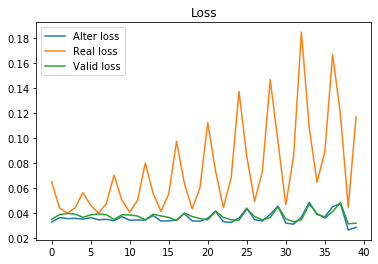

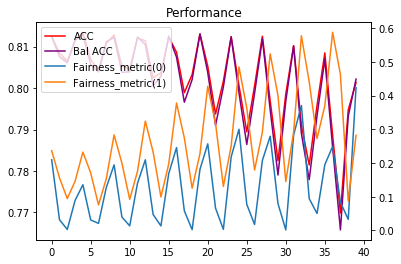

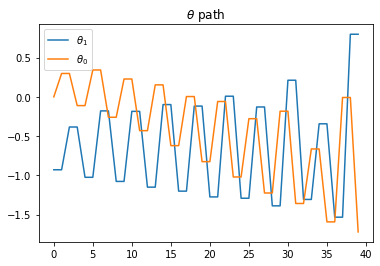

In [413]:
iter_num = 20
lamda = 0.3

theta_1, theta_2 = alternative_train(theta_0.copy(), train_config, valid_config, c, lamda, iter_num, verbose_iter, verbose = True)

{'n00': 856, 'n01': 1314, 'n10': 1801, 'n11': 509}


../FACT/utils.py:69: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  plt.hist(d, bins = 100, normed = True, label = 'logit(Y={},A={})'.format(group[0], group[1]), alpha = 0.5)
../FACT/utils.py:81: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  plt.hist(d, bins = 100, normed = True, label = 'logit(Y={},A={})'.format(group[0], group[1]), alpha = 0.5)


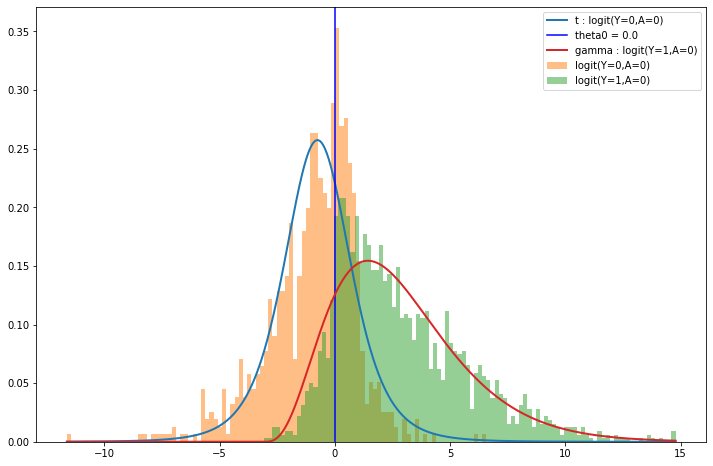

estimated distribution


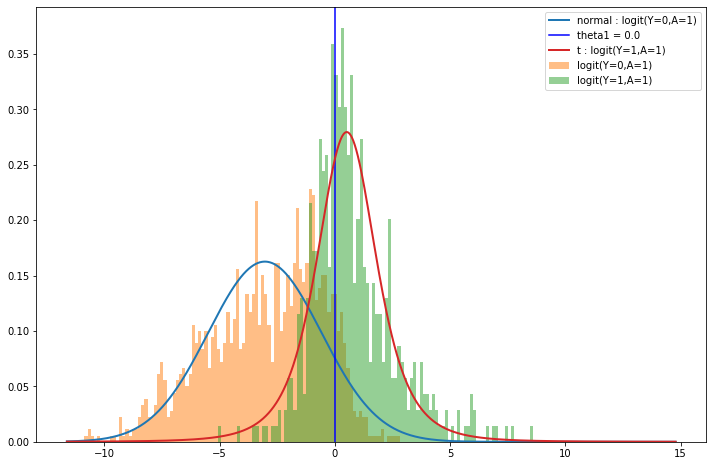

estimated distribution
{'n00': 365, 'n01': 529, 'n10': 838, 'n11': 188}


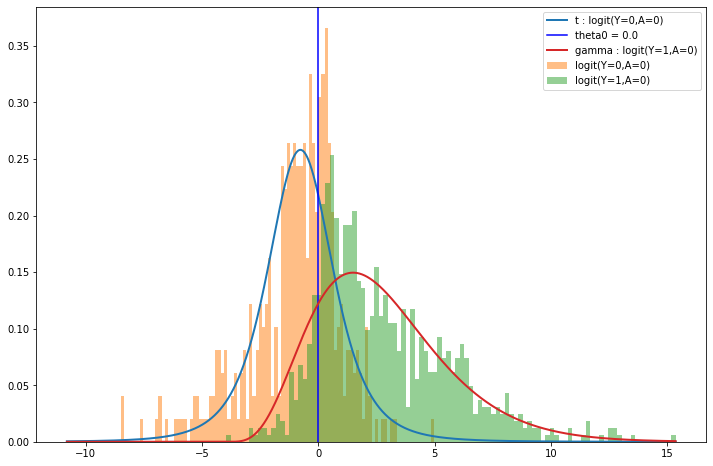

estimated distribution


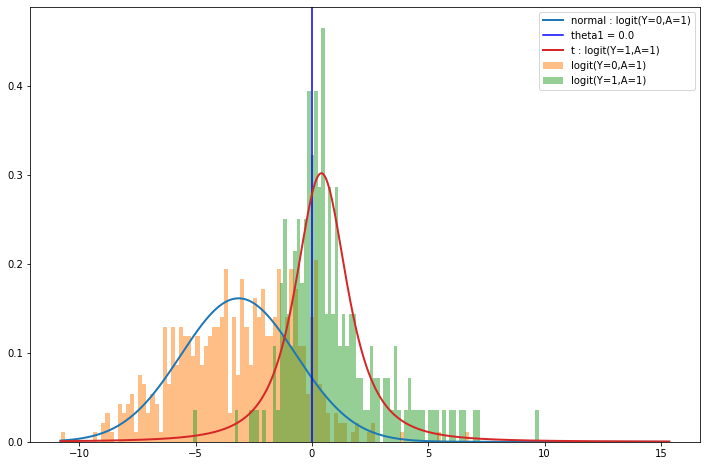

estimated distribution
[[0.]
 [0.]]
0
best theta saved [[-28.36260443]
 [  0.        ]]
[[-28.36260443]
 [  0.        ]]
[[-2.83626044e+01]
 [-1.51132825e+06]]
[[-1769576.22332231]
 [-1511328.24581568]]
[[-1.76957622e+06]
 [-3.15123010e+29]]
[[-3.1512301e+29]
 [-3.1512301e+29]]
[[-3.15123010e+029]
 [-2.89931071e+142]]
[[-2.89931071e+142]
 [-2.89931071e+142]]
[[-2.89931071e+142]
 [             nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]

../FACT/utils.py:553: RuntimeWarning: invalid value encountered in true_divide
  delta = -(a*m + lamda * b * l)/(a**2 + lamda * b**2)
../FACT/utils.py:554: RuntimeWarning: invalid value encountered in true_divide
  loss_op = lamda * (a*l-m*b)**2/(a**2 + lamda * b**2)


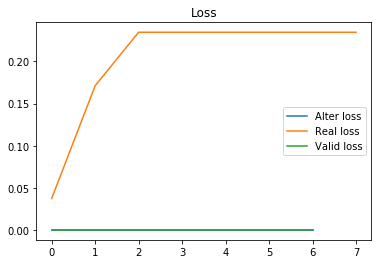

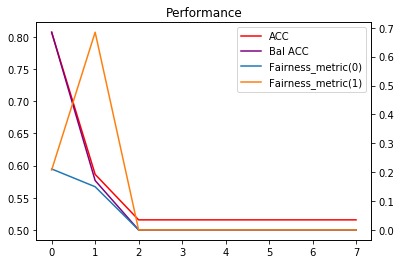

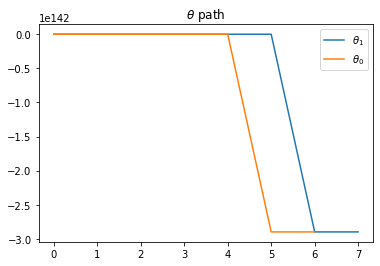

overall TPR : 0.903
priv TPR : 1.000
unpriv TPR : 0.881
Eq. Opp : 0.119

overall FPR : 0.725
priv FPR : 1.000
unpriv FPR : 0.326
diff FPR : 0.674

overall ACC : 0.610
priv ACC : 0.262
unpriv ACC : 0.818
diff ACC : 0.556



overall TPR : 0.837
priv TPR : 0.644
unpriv TPR : 0.881
Eq. Opp : 0.237

overall FPR : 0.195
priv FPR : 0.104
unpriv FPR : 0.326
diff FPR : 0.222

overall ACC : 0.822
priv ACC : 0.830
unpriv ACC : 0.818
diff ACC : 0.012



result celebA 
 0.4591088794869335 0.4669184778639178 0.8223958333333333 
 0.7933043449831626 0.28761429758935975 0.6104166666666667
[[0.]
 [0.]]
0
best theta saved [[-1.02184091]
 [ 0.        ]]
[[-1.02184091]
 [ 0.        ]]
0
best theta saved [[-1.02184091]
 [ 1.60006131]]
[[-1.02184091]
 [ 1.60006131]]
[[2.43766442]
 [1.60006131]]
[[ 2.43766442]
 [-5.18100674]]
[[-8.15238702]
 [-5.18100674]]
2
best theta saved [[-8.15238702]
 [83.73995545]]
[[-8.15238702]
 [83.73995545]]
[[123.08143766]
 [ 83.73995545]]
[[ 1.23081438e+02]
 [-2.37264322e+08]]
[[

../FACT/utils.py:553: RuntimeWarning: divide by zero encountered in true_divide
  delta = -(a*m + lamda * b * l)/(a**2 + lamda * b**2)


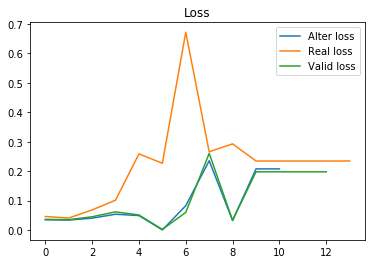

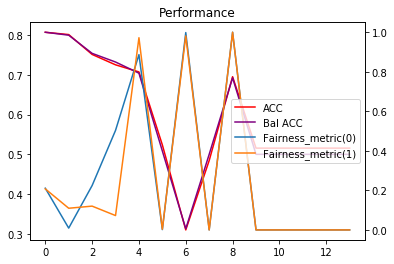

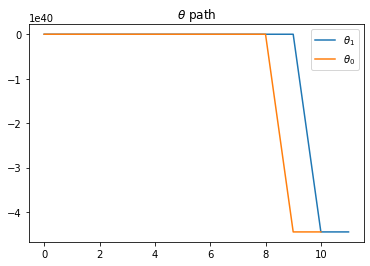

overall TPR : 0.183
priv TPR : 1.000
unpriv TPR : 0.000
Eq. Opp : 1.000

overall FPR : 0.577
priv FPR : 0.975
unpriv FPR : 0.000
diff FPR : 0.975

overall ACC : 0.295
priv ACC : 0.280
unpriv ACC : 0.303
diff ACC : 0.023



overall TPR : 0.837
priv TPR : 0.644
unpriv TPR : 0.881
Eq. Opp : 0.237

overall FPR : 0.195
priv FPR : 0.104
unpriv FPR : 0.326
diff FPR : 0.222

overall ACC : 0.822
priv ACC : 0.830
unpriv ACC : 0.818
diff ACC : 0.012



result celebA 
 0.4591088794869335 0.4669184778639178 0.8223958333333333 
 1.9754253308128544 0.9818688981868898 0.2947916666666667
[[0.]
 [0.]]
0
best theta saved [[-0.86639309]
 [ 0.        ]]
[[-0.86639309]
 [ 0.        ]]
[[-0.86639309]
 [ 0.03432566]]
[[-0.80418352]
 [ 0.03432566]]
[[-8.04183516e-01]
 [-3.29618237e-04]]
[[-8.65783302e-01]
 [-3.29618237e-04]]
[[-0.8657833 ]
 [ 0.03275165]]
[[-0.80585   ]
 [ 0.03275165]]
[[-8.05849997e-01]
 [-6.47710117e-04]]
[[-8.65238796e-01]
 [-6.47710117e-04]]
[[-0.8652388 ]
 [ 0.03130415]]
[[-0.80737006]
 [

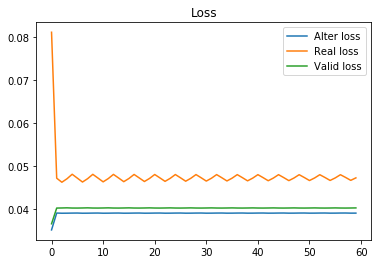

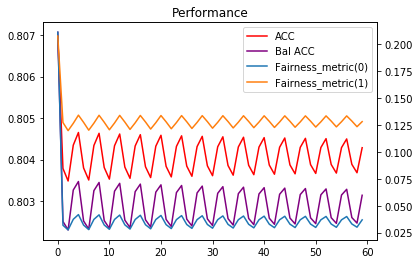

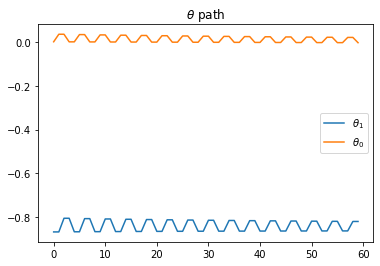

overall TPR : 0.876
priv TPR : 0.856
unpriv TPR : 0.881
Eq. Opp : 0.024

overall FPR : 0.256
priv FPR : 0.208
unpriv FPR : 0.326
diff FPR : 0.118

overall ACC : 0.815
priv ACC : 0.809
unpriv ACC : 0.818
diff ACC : 0.009



overall TPR : 0.837
priv TPR : 0.644
unpriv TPR : 0.881
Eq. Opp : 0.237

overall FPR : 0.195
priv FPR : 0.104
unpriv FPR : 0.326
diff FPR : 0.222

overall ACC : 0.822
priv ACC : 0.830
unpriv ACC : 0.818
diff ACC : 0.012



result celebA 
 0.4591088794869335 0.4669184778639178 0.8223958333333333 
 0.1423731677868169 0.33442196461426643 0.8145833333333333
[[0.]
 [0.]]
0
best theta saved [[-0.84683774]
 [ 0.        ]]
[[-0.84683774]
 [ 0.        ]]
[[-0.84683774]
 [-0.10846211]]
[[-1.04014247]
 [-0.10846211]]
[[-1.04014247]
 [-0.05202744]]
[[-0.93330767]
 [-0.05202744]]
[[-0.93330767]
 [-0.09453228]]
[[-1.0109806 ]
 [-0.09453228]]
[[-1.0109806]
 [-0.0677591]]
[[-0.96081693]
 [-0.0677591 ]]
[[-0.96081693]
 [-0.0870819 ]]
[[-0.99642918]
 [-0.0870819 ]]
[[-0.99642918]
 [-0

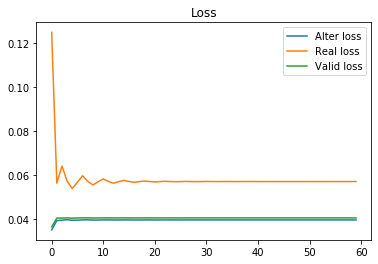

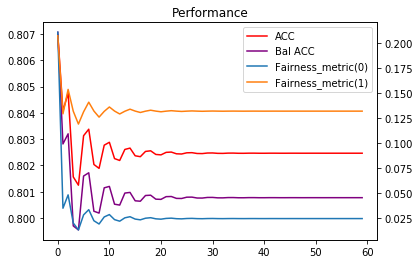

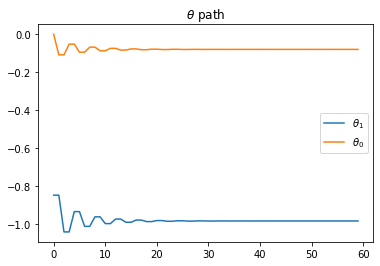

overall TPR : 0.875
priv TPR : 0.851
unpriv TPR : 0.881
Eq. Opp : 0.030

overall FPR : 0.252
priv FPR : 0.200
unpriv FPR : 0.326
diff FPR : 0.126

overall ACC : 0.816
priv ACC : 0.813
unpriv ACC : 0.818
diff ACC : 0.005



overall TPR : 0.837
priv TPR : 0.644
unpriv TPR : 0.881
Eq. Opp : 0.237

overall FPR : 0.195
priv FPR : 0.104
unpriv FPR : 0.326
diff FPR : 0.222

overall ACC : 0.822
priv ACC : 0.830
unpriv ACC : 0.818
diff ACC : 0.012



result celebA 
 0.4591088794869335 0.4669184778639178 0.8223958333333333 
 0.1552537533959549 0.3413954653116165 0.8161458333333333
[[0.]
 [0.]]
0
best theta saved [[-0.83117342]
 [ 0.        ]]
[[-0.83117342]
 [ 0.        ]]
[[-0.83117342]
 [-0.2133679 ]]
[[-1.20677914]
 [-0.2133679 ]]
[[-1.20677914]
 [-0.24423053]]
[[-1.26769452]
 [-0.24423053]]
[[-1.26769452]
 [-0.23779325]]
[[-1.25470106]
 [-0.23779325]]
[[-1.25470106]
 [-0.23960588]]
[[-1.25834194]
 [-0.23960588]]
[[-1.25834194]
 [-0.23912428]]
[[-1.25737327]
 [-0.23912428]]
[[-1.25737327]
 [-

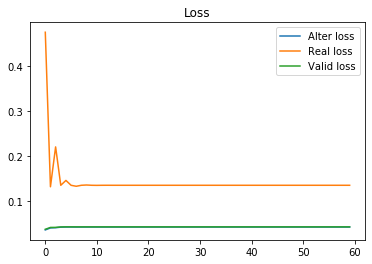

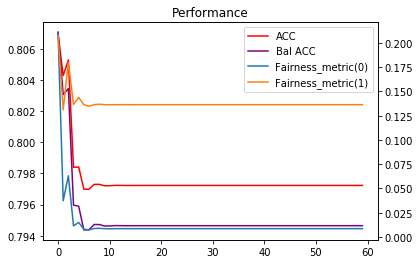

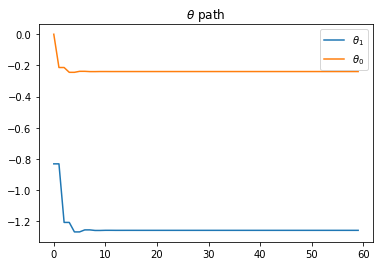

overall TPR : 0.874
priv TPR : 0.846
unpriv TPR : 0.881
Eq. Opp : 0.035

overall FPR : 0.249
priv FPR : 0.197
unpriv FPR : 0.326
diff FPR : 0.129

overall ACC : 0.817
priv ACC : 0.815
unpriv ACC : 0.818
diff ACC : 0.003



overall TPR : 0.837
priv TPR : 0.644
unpriv TPR : 0.881
Eq. Opp : 0.237

overall FPR : 0.195
priv FPR : 0.104
unpriv FPR : 0.326
diff FPR : 0.222

overall ACC : 0.822
priv ACC : 0.830
unpriv ACC : 0.818
diff ACC : 0.012



result celebA 
 0.4591088794869335 0.4669184778639178 0.8223958333333333 
 0.16435362066860906 0.3455795657300266 0.8166666666666667
[[0.]
 [0.]]
0
best theta saved [[-0.82921413]
 [ 0.        ]]
[[-0.82921413]
 [ 0.        ]]
[[-0.82921413]
 [-0.22590124]]
[[-1.22629488]
 [-0.22590124]]
[[-1.22629488]
 [-0.28261369]]
[[-1.33873264]
 [-0.28261369]]
[[-1.33873264]
 [-0.27991076]]
[[-1.33314393]
 [-0.27991076]]
[[-1.33314393]
 [-0.28036669]]
[[-1.33408457]
 [-0.28036669]]
[[-1.33408457]
 [-0.28029272]]
[[-1.33393189]
 [-0.28029272]]
[[-1.33393189]
 [

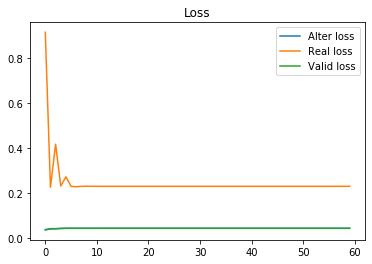

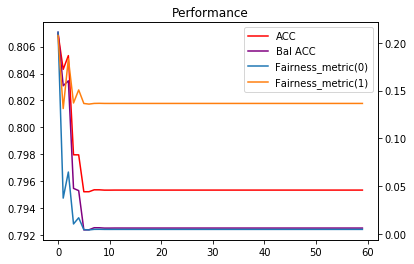

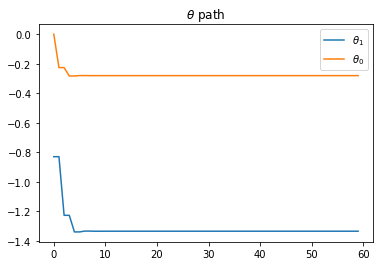

overall TPR : 0.874
priv TPR : 0.846
unpriv TPR : 0.881
Eq. Opp : 0.035

overall FPR : 0.249
priv FPR : 0.197
unpriv FPR : 0.326
diff FPR : 0.129

overall ACC : 0.817
priv ACC : 0.815
unpriv ACC : 0.818
diff ACC : 0.003



overall TPR : 0.837
priv TPR : 0.644
unpriv TPR : 0.881
Eq. Opp : 0.237

overall FPR : 0.195
priv FPR : 0.104
unpriv FPR : 0.326
diff FPR : 0.222

overall ACC : 0.822
priv ACC : 0.830
unpriv ACC : 0.818
diff ACC : 0.012



result celebA 
 0.4591088794869335 0.4669184778639178 0.8223958333333333 
 0.16435362066860906 0.3455795657300266 0.8166666666666667
[[0.]
 [0.]]
0
best theta saved [[-0.82764649]
 [ 0.        ]]
[[-0.82764649]
 [ 0.        ]]
[[-0.82764649]
 [-0.23583555]]
[[-1.24170282]
 [-0.23583555]]
[[-1.24170282]
 [-0.31617262]]
[[-1.40152521]
 [-0.31617262]]
[[-1.40152521]
 [-0.32554922]]
[[-1.42134095]
 [-0.32554922]]
[[-1.42134095]
 [-0.32534822]]
[[-1.42091274]
 [-0.32534822]]
[[-1.42091274]
 [-0.3253565 ]]
[[-1.42093037]
 [-0.3253565 ]]
[[-1.42093037]
 [

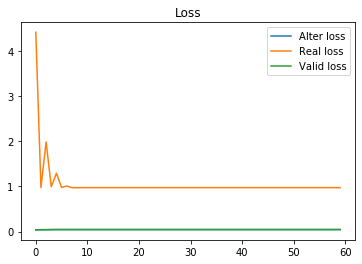

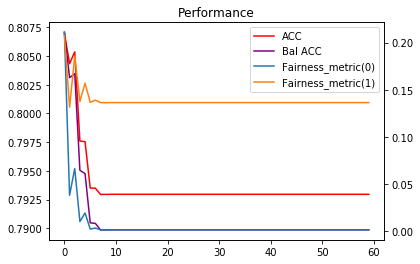

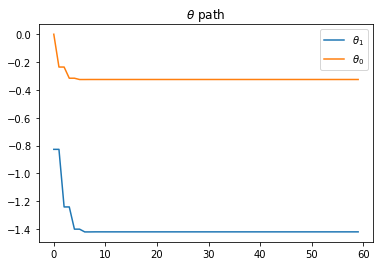

overall TPR : 0.874
priv TPR : 0.846
unpriv TPR : 0.881
Eq. Opp : 0.035

overall FPR : 0.249
priv FPR : 0.197
unpriv FPR : 0.326
diff FPR : 0.129

overall ACC : 0.817
priv ACC : 0.815
unpriv ACC : 0.818
diff ACC : 0.003



overall TPR : 0.837
priv TPR : 0.644
unpriv TPR : 0.881
Eq. Opp : 0.237

overall FPR : 0.195
priv FPR : 0.104
unpriv FPR : 0.326
diff FPR : 0.222

overall ACC : 0.822
priv ACC : 0.830
unpriv ACC : 0.818
diff ACC : 0.012



result celebA 
 0.4591088794869335 0.4669184778639178 0.8223958333333333 
 0.16435362066860906 0.3455795657300266 0.8166666666666667
[[0.]
 [0.]]
0
best theta saved [[-0.82745053]
 [ 0.        ]]
[[-0.82745053]
 [ 0.        ]]
[[-0.82745053]
 [-0.23707157]]
[[-1.24361609]
 [-0.23707157]]
[[-1.24361609]
 [-0.32055386]]
[[-1.4097651 ]
 [-0.32055386]]
[[-1.4097651 ]
 [-0.33224592]]
[[-1.43454587]
 [-0.33224592]]
[[-1.43454587]
 [-0.33227921]]
[[-1.43461714]
 [-0.33227921]]
[[-1.43461714]
 [-0.33227851]]
[[-1.43461564]
 [-0.33227851]]
[[-1.43461564]
 [

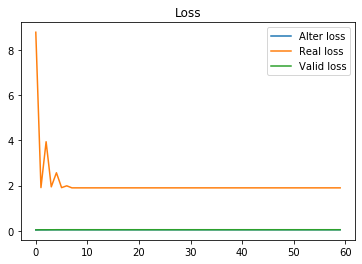

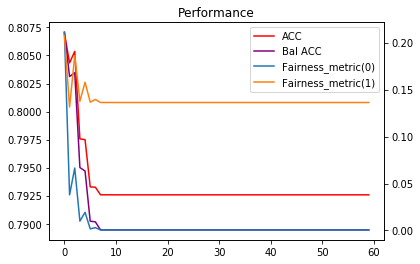

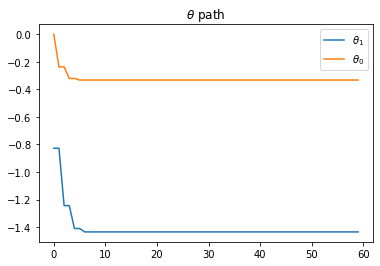

overall TPR : 0.874
priv TPR : 0.846
unpriv TPR : 0.881
Eq. Opp : 0.035

overall FPR : 0.249
priv FPR : 0.197
unpriv FPR : 0.326
diff FPR : 0.129

overall ACC : 0.817
priv ACC : 0.815
unpriv ACC : 0.818
diff ACC : 0.003



overall TPR : 0.837
priv TPR : 0.644
unpriv TPR : 0.881
Eq. Opp : 0.237

overall FPR : 0.195
priv FPR : 0.104
unpriv FPR : 0.326
diff FPR : 0.222

overall ACC : 0.822
priv ACC : 0.830
unpriv ACC : 0.818
diff ACC : 0.012



result celebA 
 0.4591088794869335 0.4669184778639178 0.8223958333333333 
 0.16435362066860906 0.3455795657300266 0.8166666666666667
{'n00': 884, 'n01': 1311, 'n10': 1785, 'n11': 500}


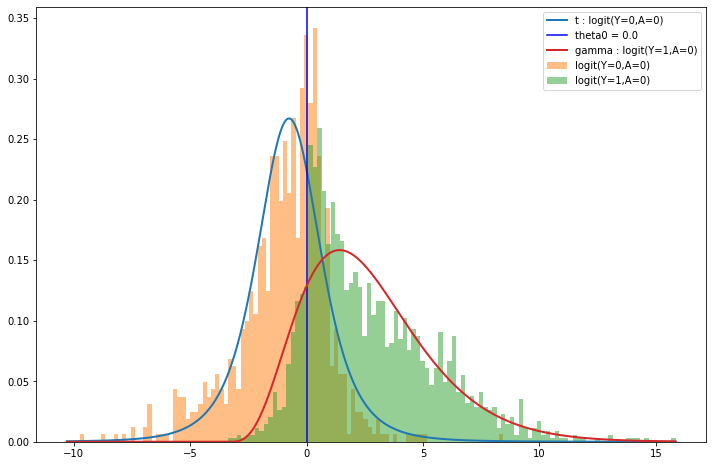

estimated distribution


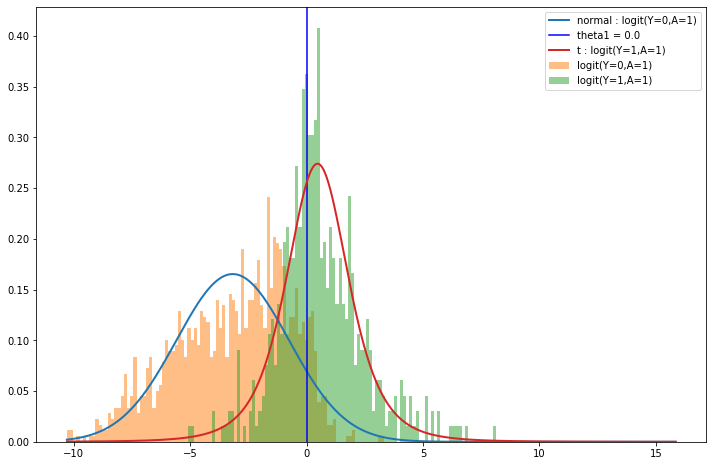

estimated distribution
{'n00': 375, 'n01': 545, 'n10': 796, 'n11': 204}


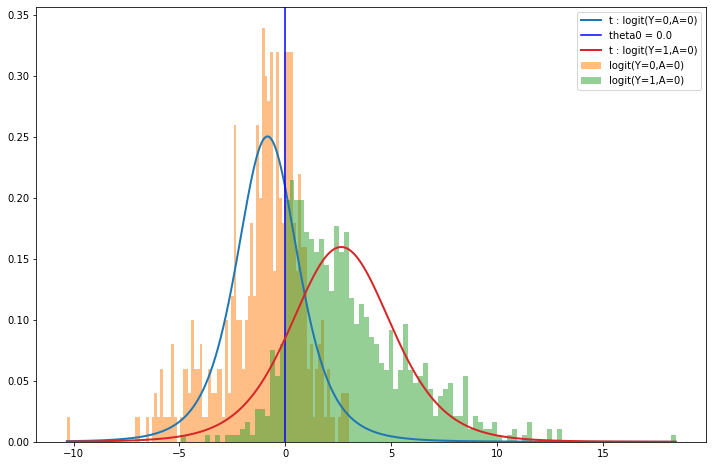

estimated distribution


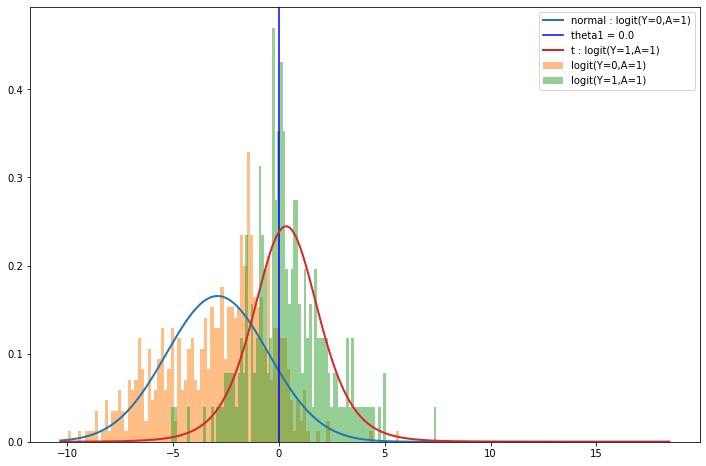

estimated distribution
[[0.]
 [0.]]
0
best theta saved [[-23.91984494]
 [  0.        ]]
[[-23.91984494]
 [  0.        ]]
[[-2.39198449e+01]
 [-1.10509449e+06]]
[[-1300603.73322609]
 [-1105094.48993777]]
[[-1.30060373e+06]
 [-6.26990705e+30]]
[[-6.26990705e+30]
 [-6.26990705e+30]]
[[-6.26990705e+030]
 [-5.84139928e+159]]
[[-5.84139928e+159]
 [-5.84139928e+159]]
[[-5.84139928e+159]
 [             nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [na

/home/taeuk/anaconda3/envs/aif/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:5750: RuntimeWarning: overflow encountered in square
  Px /= np.sqrt(r*np.pi)*(1+(x**2)/r)**((r+1)/2)
/home/taeuk/anaconda3/envs/aif/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:180: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C


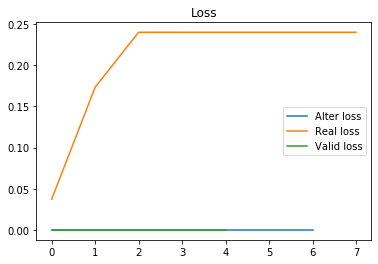

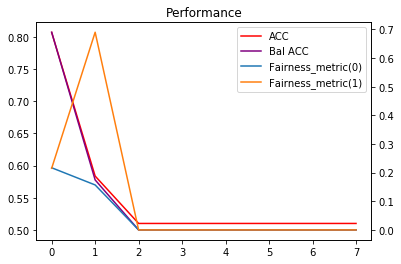

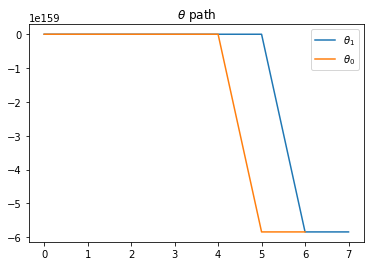

overall TPR : 0.926
priv TPR : 1.000
unpriv TPR : 0.907
Eq. Opp : 0.093

overall FPR : 0.718
priv FPR : 1.000
unpriv FPR : 0.309
diff FPR : 0.691

overall ACC : 0.617
priv ACC : 0.272
unpriv ACC : 0.838
diff ACC : 0.565



overall TPR : 0.841
priv TPR : 0.583
unpriv TPR : 0.907
Eq. Opp : 0.324

overall FPR : 0.182
priv FPR : 0.094
unpriv FPR : 0.309
diff FPR : 0.216

overall ACC : 0.830
priv ACC : 0.818
unpriv ACC : 0.838
diff ACC : 0.019



result celebA 
 0.5394571942280211 0.48865837626941244 0.8302083333333333 
 0.7836314907872696 0.28437233134073436 0.6171875
[[0.]
 [0.]]
0
best theta saved [[-1.07938072]
 [ 0.        ]]
[[-1.07938072]
 [ 0.        ]]
[[-1.07938072]
 [ 1.58301389]]
[[2.37941753]
 [1.58301389]]
[[ 2.37941753]
 [-4.90428503]]
[[-7.8760988 ]
 [-4.90428503]]
2
best theta saved [[-7.8760988 ]
 [61.99312993]]
[[-7.8760988 ]
 [61.99312993]]
[[89.07993687]
 [61.99312993]]
[[ 8.90799369e+01]
 [-1.22871252e+08]]
[[-2.90270860e+08]
 [-1.22871252e+08]]
[[-2.90270860e+08]
 [-1

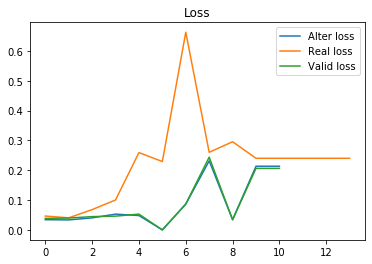

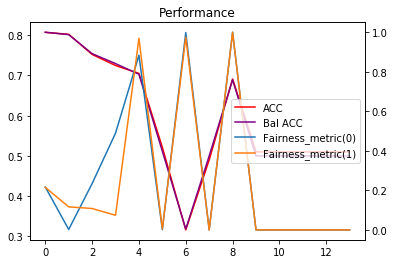

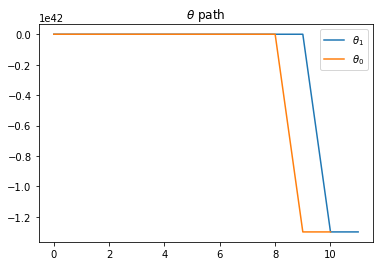

overall TPR : 0.204
priv TPR : 1.000
unpriv TPR : 0.000
Eq. Opp : 1.000

overall FPR : 0.576
priv FPR : 0.972
unpriv FPR : 0.000
diff FPR : 0.972

overall ACC : 0.309
priv ACC : 0.292
unpriv ACC : 0.320
diff ACC : 0.028



overall TPR : 0.841
priv TPR : 0.583
unpriv TPR : 0.907
Eq. Opp : 0.324

overall FPR : 0.182
priv FPR : 0.094
unpriv FPR : 0.309
diff FPR : 0.216

overall ACC : 0.830
priv ACC : 0.818
unpriv ACC : 0.838
diff ACC : 0.019



result celebA 
 0.5394571942280211 0.48865837626941244 0.8302083333333333 
 1.9724770642201834 0.9799732977303071 0.309375
[[0.]
 [0.]]
0
best theta saved [[-0.89689142]
 [ 0.        ]]
[[-0.89689142]
 [ 0.        ]]
[[-0.89689142]
 [ 0.02342707]]
[[-0.85440535]
 [ 0.02342707]]
[[-0.85440535]
 [ 0.00135421]]
[[-0.8939315 ]
 [ 0.00135421]]
[[-0.8939315 ]
 [ 0.02129813]]
[[-0.85779713]
 [ 0.02129813]]
[[-0.85779713]
 [ 0.00255414]]
[[-0.89139362]
 [ 0.00255414]]
[[-0.89139362]
 [ 0.01955423]]
[[-0.86061796]
 [ 0.01955423]]
[[-0.86061796]
 [ 0.0036121

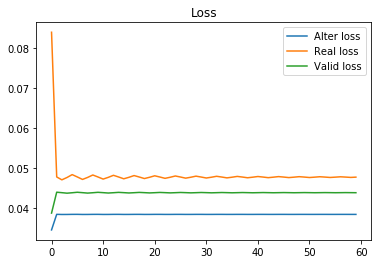

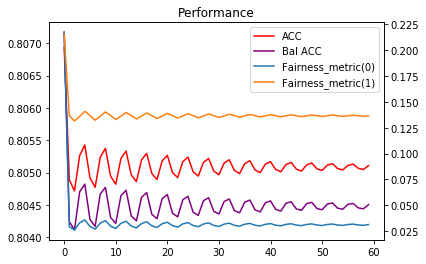

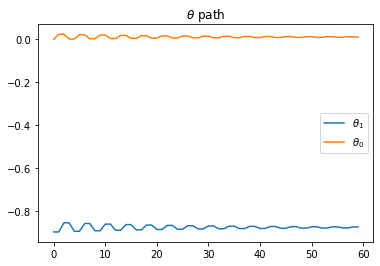

overall TPR : 0.886
priv TPR : 0.804
unpriv TPR : 0.907
Eq. Opp : 0.103

overall FPR : 0.254
priv FPR : 0.217
unpriv FPR : 0.309
diff FPR : 0.093

overall ACC : 0.819
priv ACC : 0.789
unpriv ACC : 0.838
diff ACC : 0.049



overall TPR : 0.841
priv TPR : 0.583
unpriv TPR : 0.907
Eq. Opp : 0.324

overall FPR : 0.182
priv FPR : 0.094
unpriv FPR : 0.309
diff FPR : 0.216

overall ACC : 0.830
priv ACC : 0.818
unpriv ACC : 0.838
diff ACC : 0.019



result celebA 
 0.5394571942280211 0.48865837626941244 0.8302083333333333 
 0.1959331791173895 0.33912566598903865 0.81875
[[0.]
 [0.]]
0
best theta saved [[-0.87387502]
 [ 0.        ]]
[[-0.87387502]
 [ 0.        ]]
[[-0.87387502]
 [-0.10802635]]
[[-1.0665488 ]
 [-0.10802635]]
[[-1.0665488 ]
 [-0.05779822]]
[[-0.97169685]
 [-0.05779822]]
[[-0.97169685]
 [-0.09243017]]
[[-1.03516713]
 [-0.09243017]]
[[-1.03516713]
 [-0.0722662 ]]
[[-0.99748384]
 [-0.0722662 ]]
[[-0.99748384]
 [-0.0854793 ]]
[[-1.02188713]
 [-0.0854793 ]]
[[-1.02188713]
 [-0.0773875

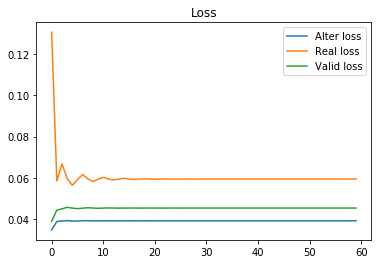

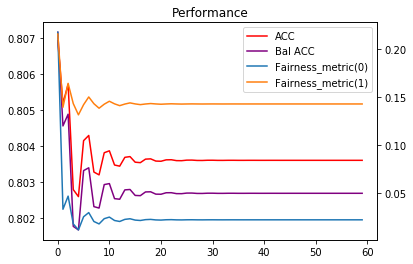

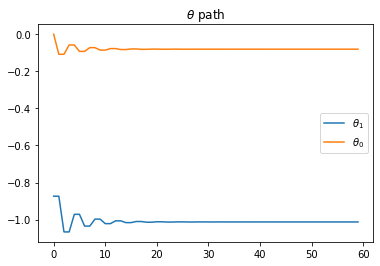

overall TPR : 0.884
priv TPR : 0.794
unpriv TPR : 0.907
Eq. Opp : 0.113

overall FPR : 0.253
priv FPR : 0.215
unpriv FPR : 0.309
diff FPR : 0.095

overall ACC : 0.818
priv ACC : 0.788
unpriv ACC : 0.838
diff ACC : 0.050



overall TPR : 0.841
priv TPR : 0.583
unpriv TPR : 0.907
Eq. Opp : 0.324

overall FPR : 0.182
priv FPR : 0.094
unpriv FPR : 0.309
diff FPR : 0.216

overall ACC : 0.830
priv ACC : 0.818
unpriv ACC : 0.838
diff ACC : 0.019



result celebA 
 0.5394571942280211 0.48865837626941244 0.8302083333333333 
 0.20757196307133816 0.3431310064429772 0.8182291666666667
[[0.]
 [0.]]
0
best theta saved [[-0.85542873]
 [ 0.        ]]
[[-0.85542873]
 [ 0.        ]]
[[-0.85542873]
 [-0.20280753]]
[[-1.21277255]
 [-0.20280753]]
[[-1.21277255]
 [-0.22984362]]
[[-1.26560311]
 [-0.22984362]]
[[-1.26560311]
 [-0.22505043]]
[[-1.25606259]
 [-0.22505043]]
[[-1.25606259]
 [-0.22618054]]
[[-1.25830436]
 [-0.22618054]]
[[-1.25830436]
 [-0.22592628]]
[[-1.25779959]
 [-0.22592628]]
[[-1.25779959]
 

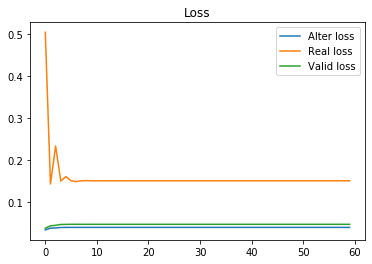

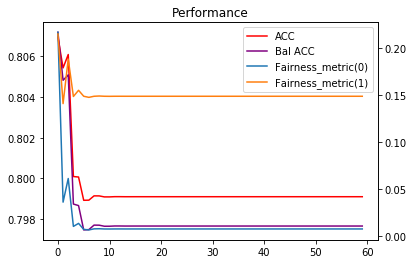

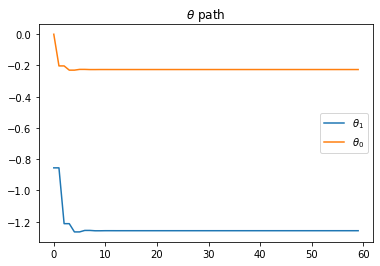

overall TPR : 0.881
priv TPR : 0.779
unpriv TPR : 0.907
Eq. Opp : 0.128

overall FPR : 0.248
priv FPR : 0.206
unpriv FPR : 0.309
diff FPR : 0.104

overall ACC : 0.819
priv ACC : 0.790
unpriv ACC : 0.838
diff ACC : 0.047



overall TPR : 0.841
priv TPR : 0.583
unpriv TPR : 0.907
Eq. Opp : 0.324

overall FPR : 0.182
priv FPR : 0.094
unpriv FPR : 0.309
diff FPR : 0.216

overall ACC : 0.830
priv ACC : 0.818
unpriv ACC : 0.838
diff ACC : 0.019



result celebA 
 0.5394571942280211 0.48865837626941244 0.8302083333333333 
 0.23145215735088479 0.35381191432014686 0.8192708333333333
[[0.]
 [0.]]
0
best theta saved [[-0.85312087]
 [ 0.        ]]
[[-0.85312087]
 [ 0.        ]]
[[-0.85312087]
 [-0.21401905]]
[[-1.22967049]
 [-0.21401905]]
[[-1.22967049]
 [-0.26221362]]
[[-1.32419197]
 [-0.26221362]]
[[-1.32419197]
 [-0.26016094]]
[[-1.32002901]
 [-0.26016094]]
[[-1.32002901]
 [-0.26044135]]
[[-1.32059681]
 [-0.26044135]]
[[-1.32059681]
 [-0.26040427]]
[[-1.32052173]
 [-0.26040427]]
[[-1.32052173]


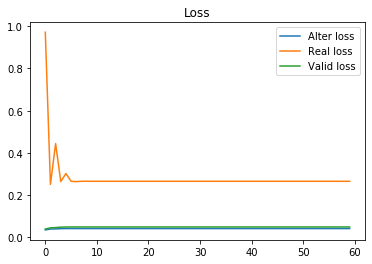

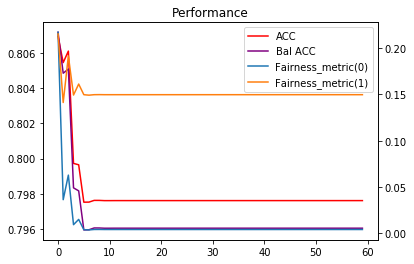

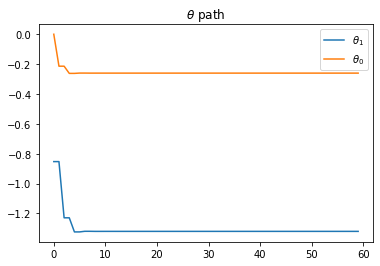

overall TPR : 0.881
priv TPR : 0.779
unpriv TPR : 0.907
Eq. Opp : 0.128

overall FPR : 0.248
priv FPR : 0.206
unpriv FPR : 0.309
diff FPR : 0.104

overall ACC : 0.819
priv ACC : 0.790
unpriv ACC : 0.838
diff ACC : 0.047



overall TPR : 0.841
priv TPR : 0.583
unpriv TPR : 0.907
Eq. Opp : 0.324

overall FPR : 0.182
priv FPR : 0.094
unpriv FPR : 0.309
diff FPR : 0.216

overall ACC : 0.830
priv ACC : 0.818
unpriv ACC : 0.838
diff ACC : 0.019



result celebA 
 0.5394571942280211 0.48865837626941244 0.8302083333333333 
 0.23145215735088479 0.35381191432014686 0.8192708333333333
[[0.]
 [0.]]
0
best theta saved [[-0.85127425]
 [ 0.        ]]
[[-0.85127425]
 [ 0.        ]]
[[-0.85127425]
 [-0.2228877 ]]
[[-1.242975 ]
 [-0.2228877]]
[[-1.242975  ]
 [-0.29016047]]
[[-1.37528686]
 [-0.29016047]]
[[-1.37528686]
 [-0.29616666]]
[[-1.38767424]
 [-0.29616666]]
[[-1.38767424]
 [-0.29604536]]
[[-1.38742289]
 [-0.29604536]]
[[-1.38742289]
 [-0.29604921]]
[[-1.38743086]
 [-0.29604921]]
[[-1.38743086]
 [

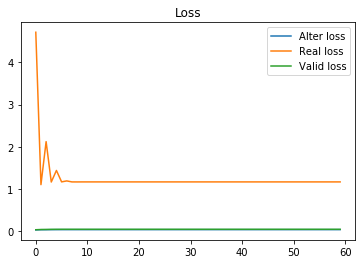

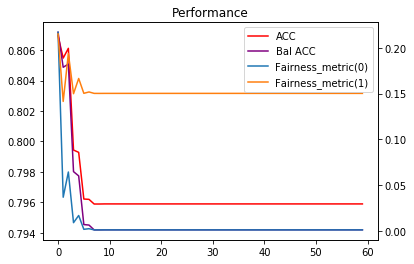

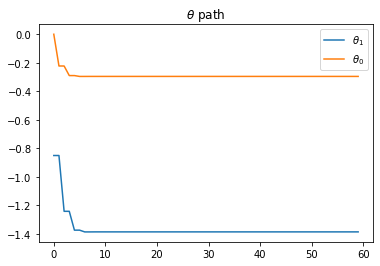

overall TPR : 0.881
priv TPR : 0.779
unpriv TPR : 0.907
Eq. Opp : 0.128

overall FPR : 0.248
priv FPR : 0.206
unpriv FPR : 0.309
diff FPR : 0.104

overall ACC : 0.819
priv ACC : 0.790
unpriv ACC : 0.838
diff ACC : 0.047



overall TPR : 0.841
priv TPR : 0.583
unpriv TPR : 0.907
Eq. Opp : 0.324

overall FPR : 0.182
priv FPR : 0.094
unpriv FPR : 0.309
diff FPR : 0.216

overall ACC : 0.830
priv ACC : 0.818
unpriv ACC : 0.838
diff ACC : 0.019



result celebA 
 0.5394571942280211 0.48865837626941244 0.8302083333333333 
 0.23145215735088479 0.35381191432014686 0.8192708333333333
[[0.]
 [0.]]
0
best theta saved [[-0.8510434]
 [ 0.       ]]
[[-0.8510434]
 [ 0.       ]]
[[-0.8510434 ]
 [-0.22399002]]
[[-1.24462479]
 [-0.22399002]]
[[-1.24462479]
 [-0.2937863 ]]
[[-1.38194748]
 [-0.2937863 ]]
[[-1.38194748]
 [-0.3012953 ]]
[[-1.39746871]
 [-0.3012953 ]]
[[-1.39746871]
 [-0.3012792 ]]
[[-1.39743525]
 [-0.3012792 ]]
[[-1.39743525]
 [-0.30127946]]
[[-1.39743579]
 [-0.30127946]]
[[-1.39743579]
 [-0

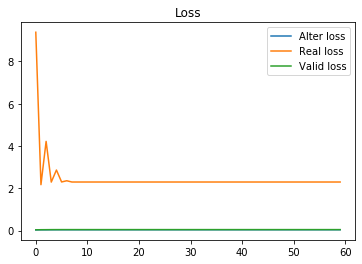

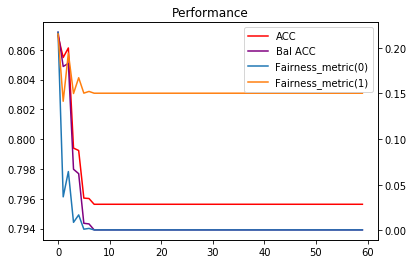

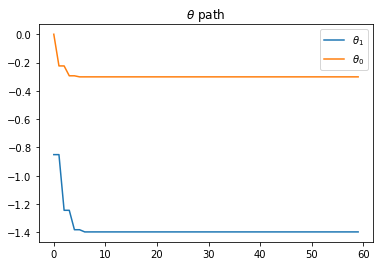

overall TPR : 0.881
priv TPR : 0.779
unpriv TPR : 0.907
Eq. Opp : 0.128

overall FPR : 0.248
priv FPR : 0.206
unpriv FPR : 0.309
diff FPR : 0.104

overall ACC : 0.819
priv ACC : 0.790
unpriv ACC : 0.838
diff ACC : 0.047



overall TPR : 0.841
priv TPR : 0.583
unpriv TPR : 0.907
Eq. Opp : 0.324

overall FPR : 0.182
priv FPR : 0.094
unpriv FPR : 0.309
diff FPR : 0.216

overall ACC : 0.830
priv ACC : 0.818
unpriv ACC : 0.838
diff ACC : 0.019



result celebA 
 0.5394571942280211 0.48865837626941244 0.8302083333333333 
 0.23145215735088479 0.35381191432014686 0.8192708333333333
{'n00': 846, 'n01': 1333, 'n10': 1811, 'n11': 490}


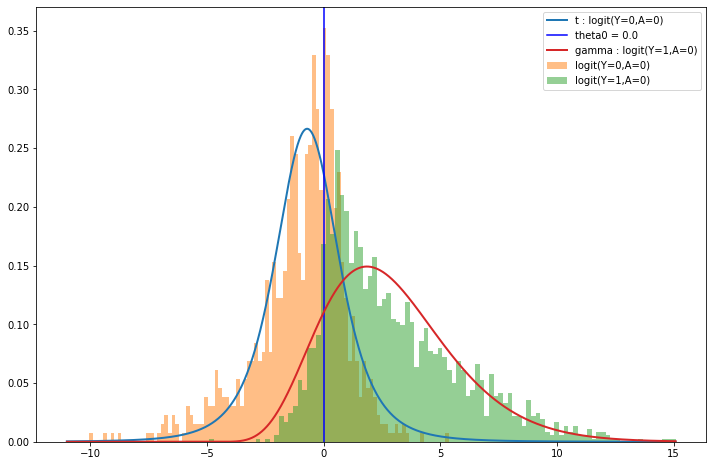

estimated distribution


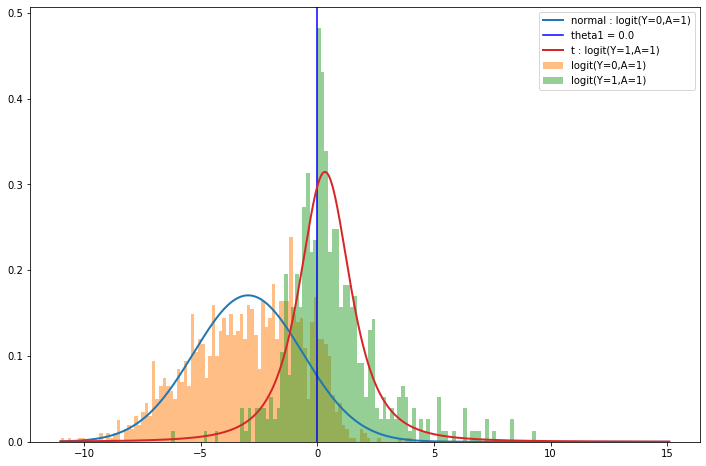

estimated distribution
{'n00': 382, 'n01': 552, 'n10': 798, 'n11': 188}


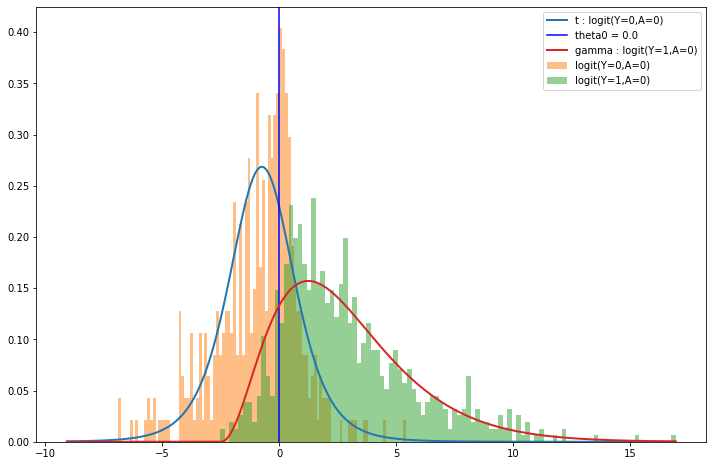

estimated distribution


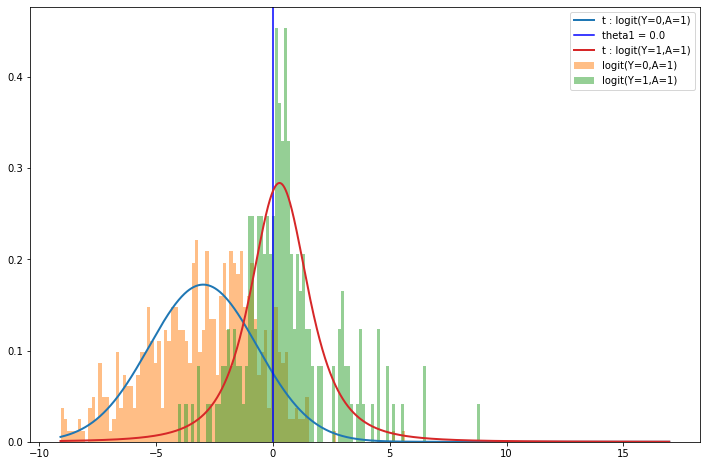

estimated distribution
[[0.]
 [0.]]
0
best theta saved [[-19.82167678]
 [  0.        ]]
[[-19.82167678]
 [  0.        ]]
[[-1.98216768e+01]
 [-6.17578712e+04]]
[[-72038.11518802]
 [-61757.87120754]]
[[-7.20381152e+04]
 [-3.32474603e+17]]
[[-3.32474603e+17]
 [-3.32474603e+17]]
[[-3.32474603e+17]
 [-4.80603280e+62]]
[[-4.8060328e+62]
 [-4.8060328e+62]]
[[-4.8060328e+62]
 [          -inf]]
[[-inf]
 [-inf]]
[[-inf]
 [ nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]

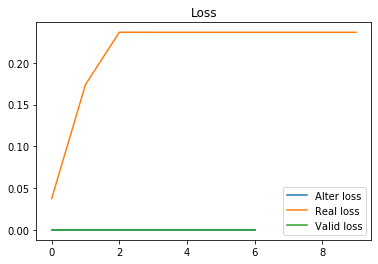

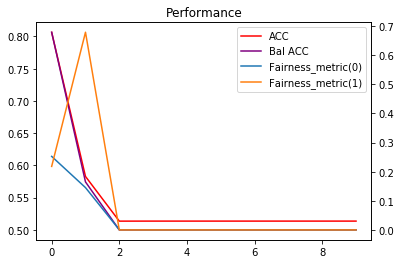

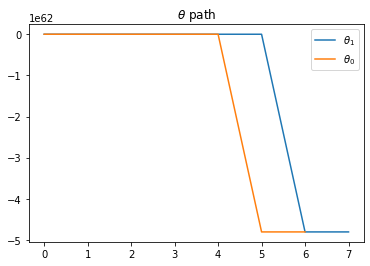

overall TPR : 0.911
priv TPR : 1.000
unpriv TPR : 0.890
Eq. Opp : 0.110

overall FPR : 0.730
priv FPR : 1.000
unpriv FPR : 0.340
diff FPR : 0.660

overall ACC : 0.599
priv ACC : 0.254
unpriv ACC : 0.815
diff ACC : 0.561



overall TPR : 0.838
priv TPR : 0.617
unpriv TPR : 0.890
Eq. Opp : 0.273

overall FPR : 0.202
priv FPR : 0.107
unpriv FPR : 0.340
diff FPR : 0.233

overall ACC : 0.818
priv ACC : 0.823
unpriv ACC : 0.815
diff ACC : 0.008



result celebA 
 0.5061331123358376 0.4753779202931745 0.8182291666666667 
 0.7699615530974032 0.288135593220339 0.5989583333333334
[[0.]
 [0.]]
0
best theta saved [[-1.05183368]
 [ 0.        ]]
[[-1.05183368]
 [ 0.        ]]
[[-1.05183368]
 [ 1.56938407]]
[[2.08243913]
 [1.56938407]]
[[ 2.08243913]
 [-4.99914235]]
[[-8.05904254]
 [-4.99914235]]
2
best theta saved [[-8.05904254]
 [99.0300856 ]]
[[-8.05904254]
 [99.0300856 ]]
[[149.81946003]
 [ 99.0300856 ]]
[[ 1.49819460e+02]
 [-1.01623175e+07]]
[[-23990474.31950711]
 [-10162317.53657735]]
[[-2.3990

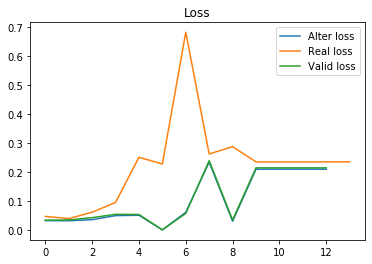

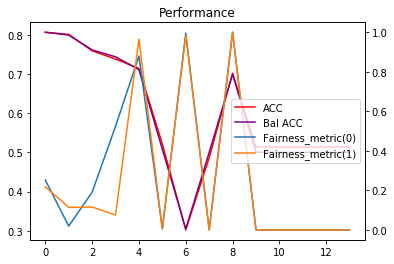

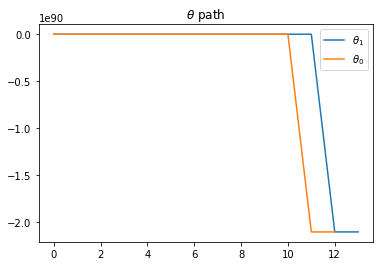

overall TPR : 0.191
priv TPR : 1.000
unpriv TPR : 0.000
Eq. Opp : 1.000

overall FPR : 0.579
priv FPR : 0.980
unpriv FPR : 0.000
diff FPR : 0.980

overall ACC : 0.303
priv ACC : 0.269
unpriv ACC : 0.324
diff ACC : 0.055



overall TPR : 0.838
priv TPR : 0.617
unpriv TPR : 0.890
Eq. Opp : 0.273

overall FPR : 0.202
priv FPR : 0.107
unpriv FPR : 0.340
diff FPR : 0.233

overall ACC : 0.818
priv ACC : 0.823
unpriv ACC : 0.815
diff ACC : 0.008



result celebA 
 0.5061331123358376 0.4753779202931745 0.8182291666666667 
 1.980072463768116 0.9851351351351351 0.3026041666666667
[[0.]
 [0.]]
0
best theta saved [[-0.89019094]
 [ 0.        ]]
[[-0.89019094]
 [ 0.        ]]
[[-0.89019094]
 [-0.03221222]]
[[-0.94339795]
 [-0.03221222]]
[[-0.94339795]
 [ 0.00200019]]
[[-0.88592452]
 [ 0.00200019]]
[[-0.88592452]
 [-0.03565566]]
[[-0.94803291]
 [-0.03565566]]
[[-0.94803291]
 [ 0.00421289]]
[[-0.88096685]
 [ 0.00421289]]
[[-0.88096685]
 [-0.03979189]]
[[-0.95342334]
 [-0.03979189]]
[[-0.95342334]
 [ 0

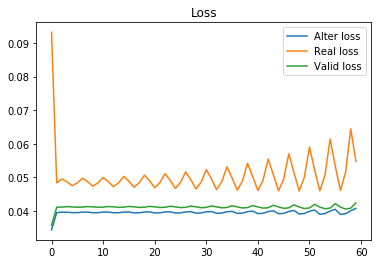

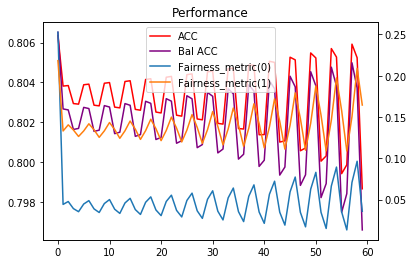

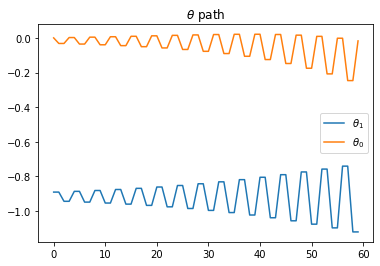

overall TPR : 0.873
priv TPR : 0.803
unpriv TPR : 0.890
Eq. Opp : 0.087

overall FPR : 0.255
priv FPR : 0.196
unpriv FPR : 0.340
diff FPR : 0.145

overall ACC : 0.811
priv ACC : 0.804
unpriv ACC : 0.815
diff ACC : 0.011



overall TPR : 0.838
priv TPR : 0.617
unpriv TPR : 0.890
Eq. Opp : 0.273

overall FPR : 0.202
priv FPR : 0.107
unpriv FPR : 0.340
diff FPR : 0.233

overall ACC : 0.818
priv ACC : 0.823
unpriv ACC : 0.815
diff ACC : 0.008



result celebA 
 0.5061331123358376 0.4753779202931745 0.8182291666666667 
 0.23119478362785117 0.36186440677966103 0.8109375
[[0.]
 [0.]]
0
best theta saved [[-0.86978963]
 [ 0.        ]]
[[-0.86978963]
 [ 0.        ]]
[[-0.86978963]
 [-0.17220132]]
[[-1.15013588]
 [-0.17220132]]
[[-1.15013588]
 [-0.08206326]]
[[-0.98991249]
 [-0.08206326]]
[[-0.98991249]
 [-0.16133792]]
[[-1.1233736 ]
 [-0.16133792]]
[[-1.1233736 ]
 [-0.10572751]]
[[-1.02557084]
 [-0.10572751]]
[[-1.02557084]
 [-0.15346483]]
[[-1.10679905]
 [-0.15346483]]
[[-1.10679905]
 [-0.11767

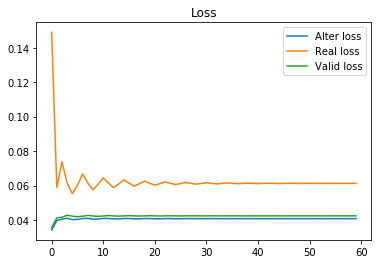

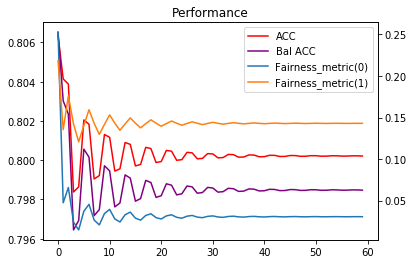

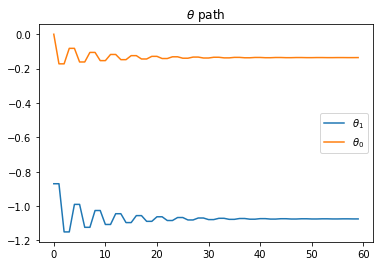

overall TPR : 0.870
priv TPR : 0.787
unpriv TPR : 0.890
Eq. Opp : 0.102

overall FPR : 0.251
priv FPR : 0.188
unpriv FPR : 0.340
diff FPR : 0.152

overall ACC : 0.811
priv ACC : 0.805
unpriv ACC : 0.815
diff ACC : 0.010



overall TPR : 0.838
priv TPR : 0.617
unpriv TPR : 0.890
Eq. Opp : 0.273

overall FPR : 0.202
priv FPR : 0.107
unpriv FPR : 0.340
diff FPR : 0.233

overall ACC : 0.818
priv ACC : 0.823
unpriv ACC : 0.815
diff ACC : 0.008



result celebA 
 0.5061331123358376 0.4753779202931745 0.8182291666666667 
 0.25439860724795593 0.37132386623912045 0.8114583333333333
[[0.]
 [0.]]
0
best theta saved [[-0.8534369]
 [ 0.       ]]
[[-0.8534369]
 [ 0.       ]]
[[-0.8534369 ]
 [-0.27356166]]
[[-1.29423943]
 [-0.27356166]]
[[-1.29423943]
 [-0.33527803]]
[[-1.40806747]
 [-0.33527803]]
[[-1.40806747]
 [-0.32015433]]
[[-1.37894749]
 [-0.32015433]]
[[-1.37894749]
 [-0.32617128]]
[[-1.39040098]
 [-0.32617128]]
[[-1.39040098]
 [-0.32401478]]
[[-1.38627765]
 [-0.32401478]]
[[-1.38627765]
 [-0.

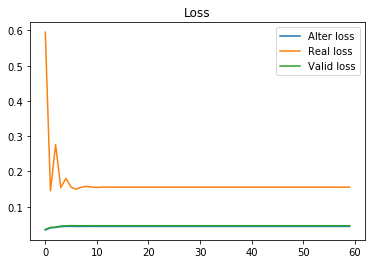

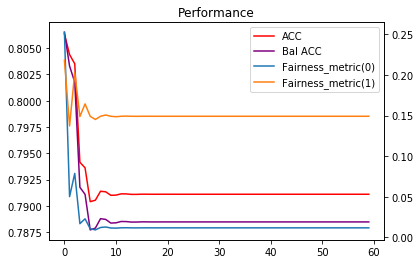

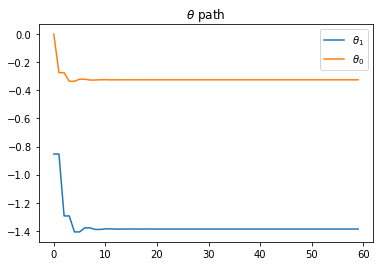

overall TPR : 0.870
priv TPR : 0.787
unpriv TPR : 0.890
Eq. Opp : 0.102

overall FPR : 0.251
priv FPR : 0.188
unpriv FPR : 0.340
diff FPR : 0.152

overall ACC : 0.811
priv ACC : 0.805
unpriv ACC : 0.815
diff ACC : 0.010



overall TPR : 0.838
priv TPR : 0.617
unpriv TPR : 0.890
Eq. Opp : 0.273

overall FPR : 0.202
priv FPR : 0.107
unpriv FPR : 0.340
diff FPR : 0.233

overall ACC : 0.818
priv ACC : 0.823
unpriv ACC : 0.815
diff ACC : 0.008



result celebA 
 0.5061331123358376 0.4753779202931745 0.8182291666666667 
 0.25439860724795593 0.37132386623912045 0.8114583333333333
[[0.]
 [0.]]
0
best theta saved [[-0.85139082]
 [ 0.        ]]
[[-0.85139082]
 [ 0.        ]]
[[-0.85139082]
 [-0.28557381]]
[[-1.3109904 ]
 [-0.28557381]]
[[-1.3109904 ]
 [-0.38450333]]
[[-1.49420553]
 [-0.38450333]]
[[-1.49420553]
 [-0.3818795 ]]
[[-1.48899241]
 [-0.3818795 ]]
[[-1.48899241]
 [-0.38253144]]
[[-1.49028493]
 [-0.38253144]]
[[-1.49028493]
 [-0.38237388]]
[[-1.4899724 ]
 [-0.38237388]]
[[-1.4899724 ]
 

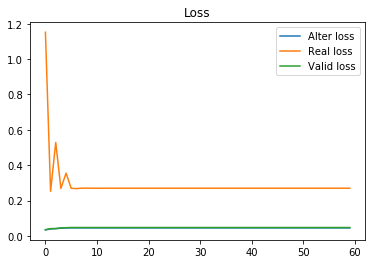

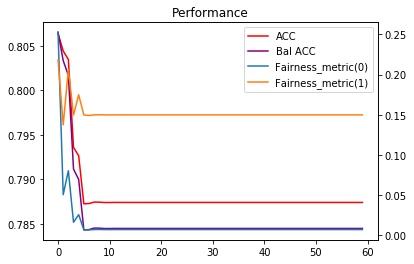

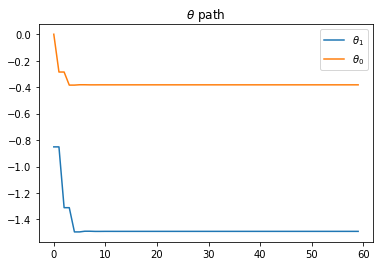

overall TPR : 0.870
priv TPR : 0.787
unpriv TPR : 0.890
Eq. Opp : 0.102

overall FPR : 0.251
priv FPR : 0.188
unpriv FPR : 0.340
diff FPR : 0.152

overall ACC : 0.811
priv ACC : 0.805
unpriv ACC : 0.815
diff ACC : 0.010



overall TPR : 0.838
priv TPR : 0.617
unpriv TPR : 0.890
Eq. Opp : 0.273

overall FPR : 0.202
priv FPR : 0.107
unpriv FPR : 0.340
diff FPR : 0.233

overall ACC : 0.818
priv ACC : 0.823
unpriv ACC : 0.815
diff ACC : 0.008



result celebA 
 0.5061331123358376 0.4753779202931745 0.8182291666666667 
 0.25439860724795593 0.37132386623912045 0.8114583333333333
[[0.]
 [0.]]
0
best theta saved [[-0.84975365]
 [ 0.        ]]
[[-0.84975365]
 [ 0.        ]]
[[-0.84975365]
 [-0.29507905]]
[[-1.32419459]
 [-0.29507905]]
[[-1.32419459]
 [-0.42738097]]
[[-1.57000286]
 [-0.42738097]]
[[-1.57000286]
 [-0.45499215]]
[[-1.62643109]
 [-0.45499215]]
[[-1.62643109]
 [-0.45474686]]
[[-1.6259175 ]
 [-0.45474686]]
[[-1.6259175 ]
 [-0.45476411]]
[[-1.62595362]
 [-0.45476411]]
[[-1.62595362]
 

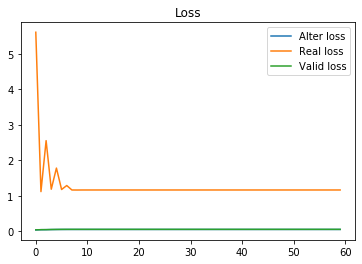

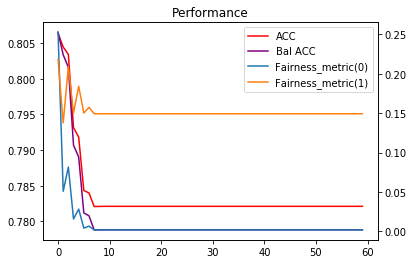

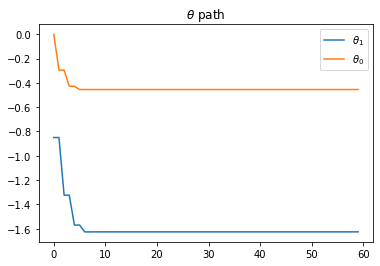

overall TPR : 0.870
priv TPR : 0.787
unpriv TPR : 0.890
Eq. Opp : 0.102

overall FPR : 0.251
priv FPR : 0.188
unpriv FPR : 0.340
diff FPR : 0.152

overall ACC : 0.811
priv ACC : 0.805
unpriv ACC : 0.815
diff ACC : 0.010



overall TPR : 0.838
priv TPR : 0.617
unpriv TPR : 0.890
Eq. Opp : 0.273

overall FPR : 0.202
priv FPR : 0.107
unpriv FPR : 0.340
diff FPR : 0.233

overall ACC : 0.818
priv ACC : 0.823
unpriv ACC : 0.815
diff ACC : 0.008



result celebA 
 0.5061331123358376 0.4753779202931745 0.8182291666666667 
 0.25439860724795593 0.37132386623912045 0.8114583333333333
[[0.]
 [0.]]
0
best theta saved [[-0.84954898]
 [ 0.        ]]
[[-0.84954898]
 [ 0.        ]]
[[-0.84954898]
 [-0.29626069]]
[[-1.32583289]
 [-0.29626069]]
[[-1.32583289]
 [-0.43296946]]
[[-1.57992951]
 [-0.43296946]]
[[-1.57992951]
 [-0.46619359]]
[[-1.64808175]
 [-0.46619359]]
[[-1.64808175]
 [-0.46737346]]
[[-1.65057423]
 [-0.46737346]]
[[-1.65057423]
 [-0.46733259]]
[[-1.6504878 ]
 [-0.46733259]]
[[-1.6504878 ]
 

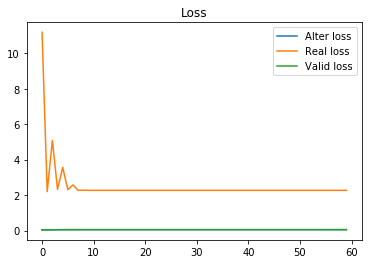

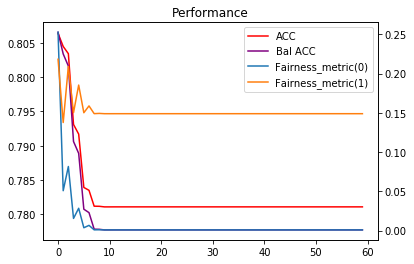

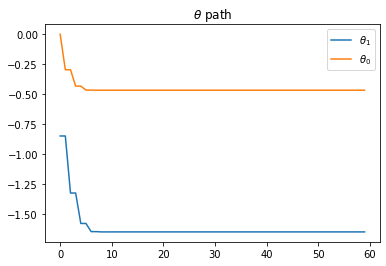

overall TPR : 0.870
priv TPR : 0.787
unpriv TPR : 0.890
Eq. Opp : 0.102

overall FPR : 0.251
priv FPR : 0.188
unpriv FPR : 0.340
diff FPR : 0.152

overall ACC : 0.811
priv ACC : 0.805
unpriv ACC : 0.815
diff ACC : 0.010



overall TPR : 0.838
priv TPR : 0.617
unpriv TPR : 0.890
Eq. Opp : 0.273

overall FPR : 0.202
priv FPR : 0.107
unpriv FPR : 0.340
diff FPR : 0.233

overall ACC : 0.818
priv ACC : 0.823
unpriv ACC : 0.815
diff ACC : 0.008



result celebA 
 0.5061331123358376 0.4753779202931745 0.8182291666666667 
 0.25439860724795593 0.37132386623912045 0.8114583333333333
{'n00': 814, 'n01': 1329, 'n10': 1799, 'n11': 538}


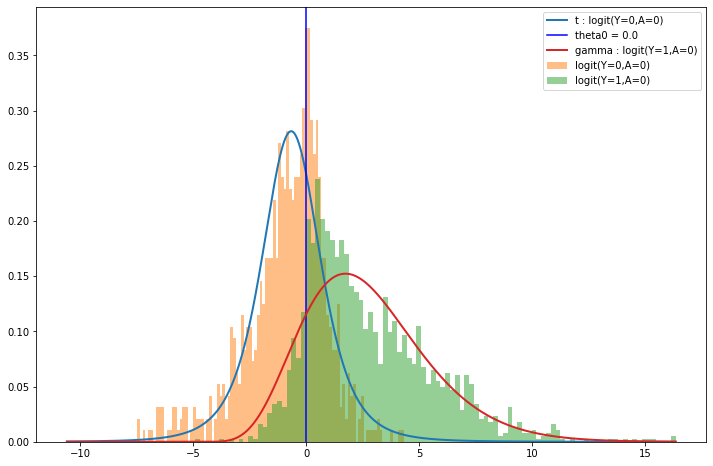

estimated distribution


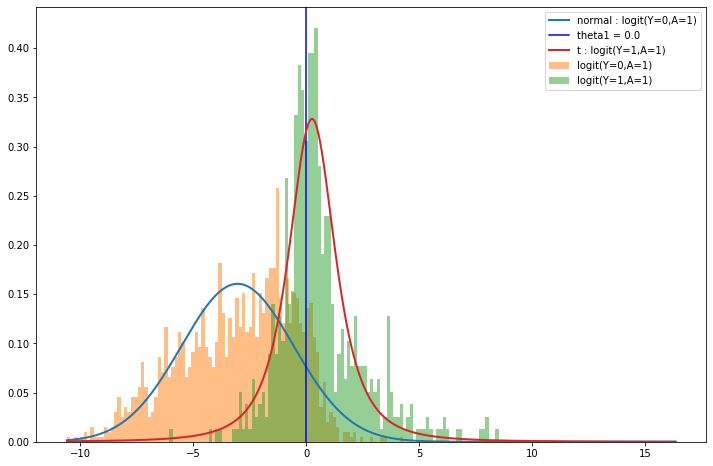

estimated distribution
{'n00': 391, 'n01': 496, 'n10': 833, 'n11': 200}


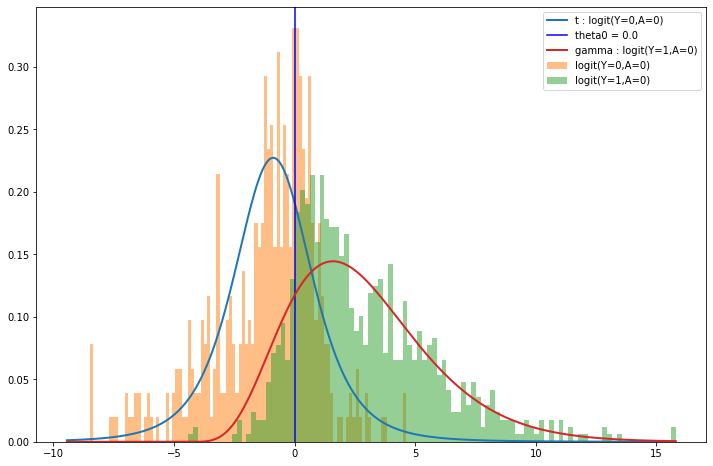

estimated distribution


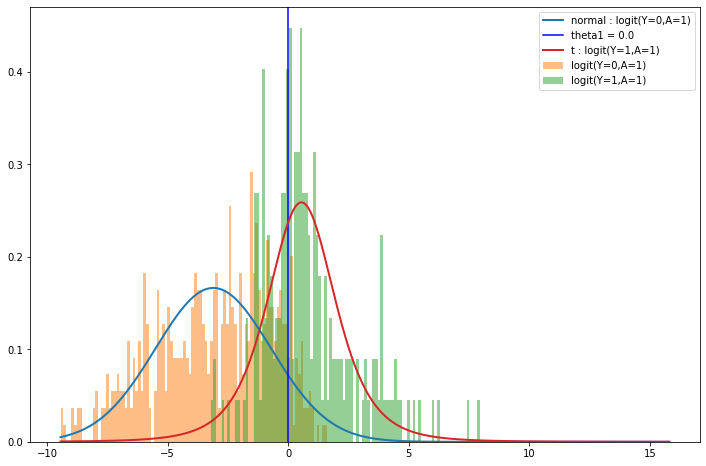

estimated distribution
[[0.]
 [0.]]
0
best theta saved [[-13.31560553]
 [  0.        ]]
[[-13.31560553]
 [  0.        ]]
[[-1.33156055e+01]
 [-1.82565672e+04]]
[[-20936.03212328]
 [-18256.56717656]]
[[-2.09360321e+04]
 [-1.19171390e+15]]
[[-1.1917139e+15]
 [-1.1917139e+15]]
[[-1.19171390e+15]
 [-7.79939588e+51]]
[[-7.79939588e+51]
 [-7.79939588e+51]]
[[-7.79939588e+51]
 [           -inf]]
[[-inf]
 [-inf]]
[[-inf]
 [ nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[na

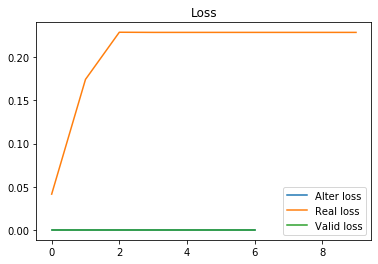

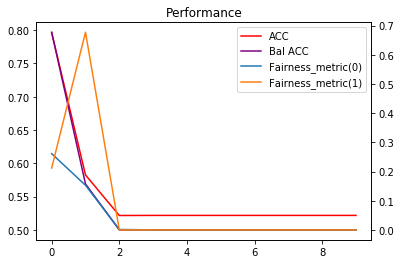

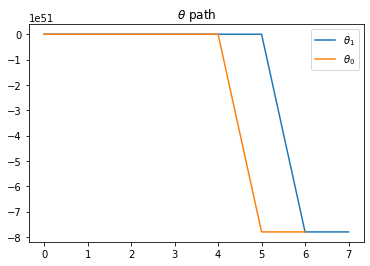

overall TPR : 0.904
priv TPR : 1.000
unpriv TPR : 0.881
Eq. Opp : 0.119

overall FPR : 0.706
priv FPR : 1.000
unpriv FPR : 0.332
diff FPR : 0.668

overall ACC : 0.622
priv ACC : 0.287
unpriv ACC : 0.813
diff ACC : 0.526



overall TPR : 0.833
priv TPR : 0.635
unpriv TPR : 0.881
Eq. Opp : 0.246

overall FPR : 0.195
priv FPR : 0.087
unpriv FPR : 0.332
diff FPR : 0.246

overall ACC : 0.820
priv ACC : 0.833
unpriv ACC : 0.813
diff ACC : 0.020



result celebA 
 0.49193973101161903 0.461629479377958 0.8203125 
 0.7863667206012841 0.2941176470588236 0.6223958333333334
[[0.]
 [0.]]
0
best theta saved [[-1.11434771]
 [ 0.        ]]
[[-1.11434771]
 [ 0.        ]]
0
best theta saved [[-1.11434771]
 [ 1.62269637]]
[[-1.11434771]
 [ 1.62269637]]
[[2.25417552]
 [1.62269637]]
[[ 2.25417552]
 [-7.09638805]]
[[-11.44352865]
 [ -7.09638805]]
[[ -11.44352865]
 [1635.82281677]]
3
best theta saved [[3866.92550483]
 [1635.82281677]]
[[3866.92550483]
 [1635.82281677]]
[[ 3.8669255e+03]
 [-5.0498976e+11]]
[[

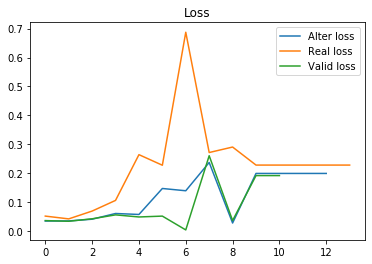

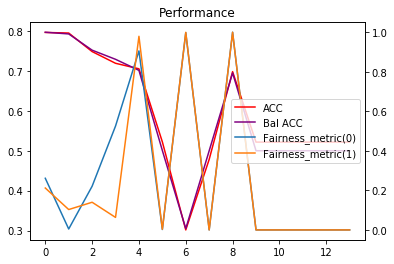

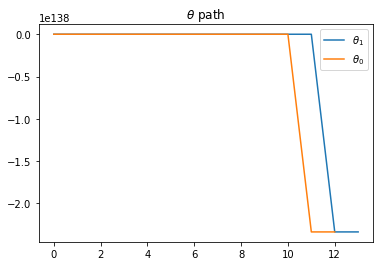

overall TPR : 0.000
priv TPR : 0.000
unpriv TPR : 0.000
Eq. Opp : 0.000

overall FPR : 0.000
priv FPR : 0.000
unpriv FPR : 0.000
diff FPR : 0.000

overall ACC : 0.462
priv ACC : 0.713
unpriv ACC : 0.319
diff ACC : 0.393



overall TPR : 0.833
priv TPR : 0.635
unpriv TPR : 0.881
Eq. Opp : 0.246

overall FPR : 0.195
priv FPR : 0.087
unpriv FPR : 0.332
diff FPR : 0.246

overall ACC : 0.820
priv ACC : 0.833
unpriv ACC : 0.813
diff ACC : 0.020



result celebA 
 0.49193973101161903 0.461629479377958 0.8203125 
 0.0 0.0 0.46197916666666666
[[0.]
 [0.]]
0
best theta saved [[-0.88623792]
 [ 0.        ]]
[[-0.88623792]
 [ 0.        ]]
[[-0.88623792]
 [-0.07300074]]
[[-1.00668491]
 [-0.07300074]]
[[-1.00668491e+00]
 [ 5.69488551e-04]]
[[-8.80075211e-01]
 [ 5.69488551e-04]]
[[-0.88007521]
 [-0.08117955]]
[[-1.01459258]
 [-0.08117955]]
[[-1.01459258e+00]
 [ 7.86840989e-04]]
[[-8.73236161e-01]
 [ 7.86840989e-04]]
[[-0.87323616]
 [-0.09083371]]
[[-1.02353615]
 [-0.09083371]]
[[-1.02353615e+00]
 [ 5.

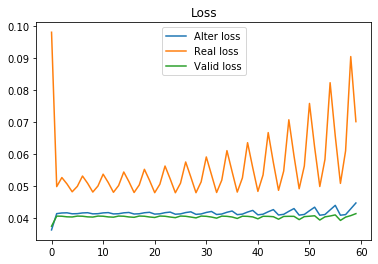

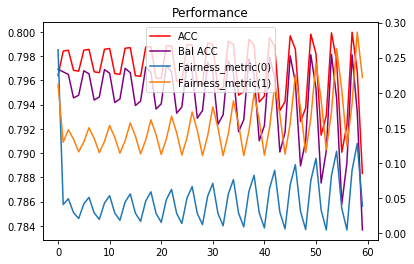

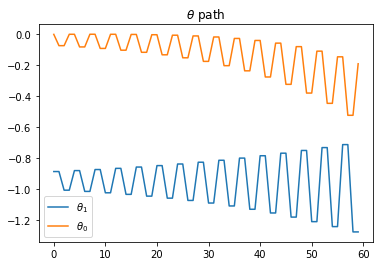

overall TPR : 0.871
priv TPR : 0.830
unpriv TPR : 0.881
Eq. Opp : 0.051

overall FPR : 0.266
priv FPR : 0.214
unpriv FPR : 0.332
diff FPR : 0.119

overall ACC : 0.808
priv ACC : 0.799
unpriv ACC : 0.813
diff ACC : 0.014



overall TPR : 0.833
priv TPR : 0.635
unpriv TPR : 0.881
Eq. Opp : 0.246

overall FPR : 0.195
priv FPR : 0.087
unpriv FPR : 0.332
diff FPR : 0.246

overall ACC : 0.820
priv ACC : 0.833
unpriv ACC : 0.813
diff ACC : 0.020



result celebA 
 0.49193973101161903 0.461629479377958 0.8203125 
 0.16992360197936104 0.31507775524002696 0.8078125
[[0.]
 [0.]]
0
best theta saved [[-0.85712308]
 [ 0.        ]]
[[-0.85712308]
 [ 0.        ]]
[[-0.85712308]
 [-0.18473623]]
[[-1.15677542]
 [-0.18473623]]
[[-1.15677542]
 [-0.10656141]]
[[-1.01648325]
 [-0.10656141]]
[[-1.01648325]
 [-0.17261432]]
[[-1.12900262]
 [-0.17261432]]
[[-1.12900262]
 [-0.12822197]]
[[-1.0502576 ]
 [-0.12822197]]
[[-1.0502576 ]
 [-0.16452775]]
[[-1.11280958]
 [-0.16452775]]
[[-1.11280958]
 [-0.13837282]]
[[-

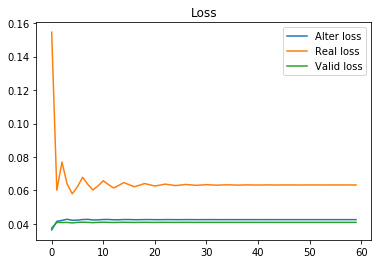

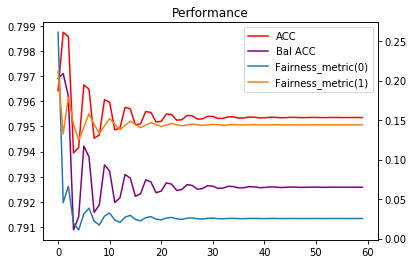

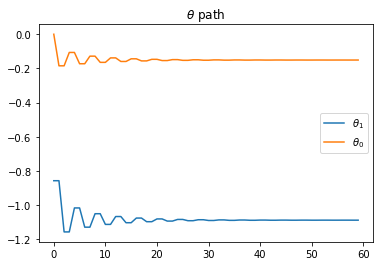

overall TPR : 0.868
priv TPR : 0.815
unpriv TPR : 0.881
Eq. Opp : 0.066

overall FPR : 0.263
priv FPR : 0.208
unpriv FPR : 0.332
diff FPR : 0.125

overall ACC : 0.808
priv ACC : 0.799
unpriv ACC : 0.813
diff ACC : 0.014



overall TPR : 0.833
priv TPR : 0.635
unpriv TPR : 0.881
Eq. Opp : 0.246

overall FPR : 0.195
priv FPR : 0.087
unpriv FPR : 0.332
diff FPR : 0.246

overall ACC : 0.820
priv ACC : 0.833
unpriv ACC : 0.813
diff ACC : 0.020



result celebA 
 0.49193973101161903 0.461629479377958 0.8203125 
 0.19097198907613536 0.3236984448951994 0.8078125
[[0.]
 [0.]]
0
best theta saved [[-0.83373281]
 [ 0.        ]]
[[-0.83373281]
 [ 0.        ]]
[[-0.83373281]
 [-0.25995504]]
[[-1.25021958]
 [-0.25995504]]
[[-1.25021958]
 [-0.32451043]]
[[-1.3685496 ]
 [-0.32451043]]
[[-1.3685496 ]
 [-0.31305092]]
[[-1.3465293 ]
 [-0.31305092]]
[[-1.3465293 ]
 [-0.31690995]]
[[-1.353877  ]
 [-0.31690995]]
[[-1.353877  ]
 [-0.31572758]]
[[-1.35161888]
 [-0.31572758]]
[[-1.35161888]
 [-0.3161018 ]]
[[-1

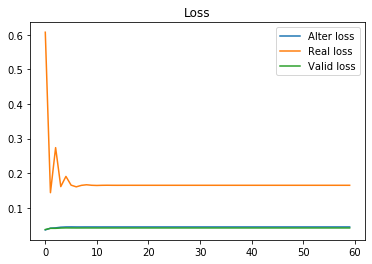

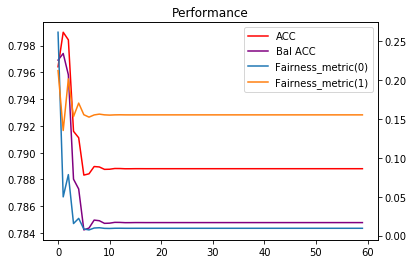

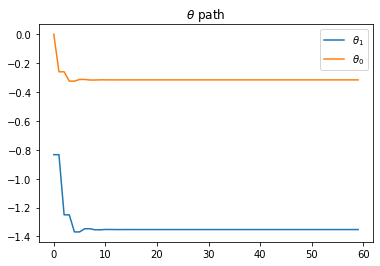

overall TPR : 0.868
priv TPR : 0.815
unpriv TPR : 0.881
Eq. Opp : 0.066

overall FPR : 0.258
priv FPR : 0.200
unpriv FPR : 0.332
diff FPR : 0.133

overall ACC : 0.810
priv ACC : 0.805
unpriv ACC : 0.813
diff ACC : 0.008



overall TPR : 0.833
priv TPR : 0.635
unpriv TPR : 0.881
Eq. Opp : 0.246

overall FPR : 0.195
priv FPR : 0.087
unpriv FPR : 0.332
diff FPR : 0.246

overall ACC : 0.820
priv ACC : 0.833
unpriv ACC : 0.813
diff ACC : 0.020



result celebA 
 0.49193973101161903 0.461629479377958 0.8203125 
 0.1990365052051676 0.32944557133198094 0.8098958333333334
[[0.]
 [0.]]
0
best theta saved [[-0.83080285]
 [ 0.        ]]
[[-0.83080285]
 [ 0.        ]]
[[-0.83080285]
 [-0.26851975]]
[[-1.26037823]
 [-0.26851975]]
[[-1.26037823]
 [-0.36133445]]
[[-1.43083965]
 [-0.36133445]]
[[-1.43083965]
 [-0.36209474]]
[[-1.43233499]
 [-0.36209474]]
[[-1.43233499]
 [-0.36194755]]
[[-1.4320453 ]
 [-0.36194755]]
[[-1.4320453 ]
 [-0.36197633]]
[[-1.43210194]
 [-0.36197633]]
[[-1.43210194]
 [-0.361970

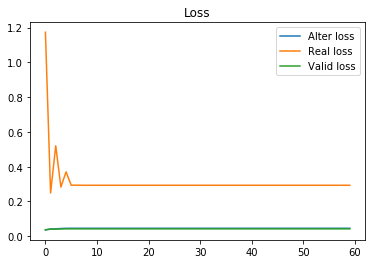

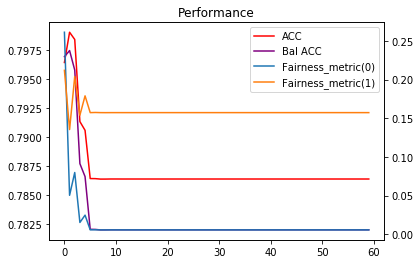

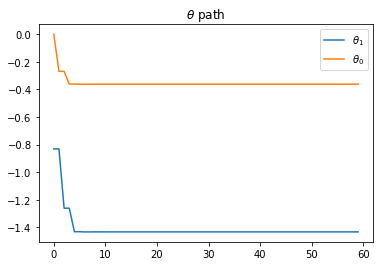

overall TPR : 0.868
priv TPR : 0.815
unpriv TPR : 0.881
Eq. Opp : 0.066

overall FPR : 0.258
priv FPR : 0.200
unpriv FPR : 0.332
diff FPR : 0.133

overall ACC : 0.810
priv ACC : 0.805
unpriv ACC : 0.813
diff ACC : 0.008



overall TPR : 0.833
priv TPR : 0.635
unpriv TPR : 0.881
Eq. Opp : 0.246

overall FPR : 0.195
priv FPR : 0.087
unpriv FPR : 0.332
diff FPR : 0.246

overall ACC : 0.820
priv ACC : 0.833
unpriv ACC : 0.813
diff ACC : 0.020



result celebA 
 0.49193973101161903 0.461629479377958 0.8203125 
 0.1990365052051676 0.32944557133198094 0.8098958333333334
[[0.]
 [0.]]
0
best theta saved [[-0.82845789]
 [ 0.        ]]
[[-0.82845789]
 [ 0.        ]]
[[-0.82845789]
 [-0.2752416 ]]
[[-1.26827277]
 [-0.2752416 ]]
[[-1.26827277]
 [-0.39241523]]
[[-1.4837848 ]
 [-0.39241523]]
[[-1.4837848 ]
 [-0.41483456]]
[[-1.52876953]
 [-0.41483456]]
[[-1.52876953]
 [-0.41478412]]
[[-1.52866631]
 [-0.41478412]]
[[-1.52866631]
 [-0.41478669]]
[[-1.52867156]
 [-0.41478669]]
[[-1.52867156]
 [-0.414786

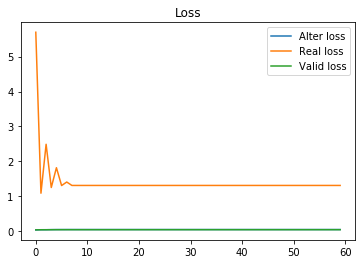

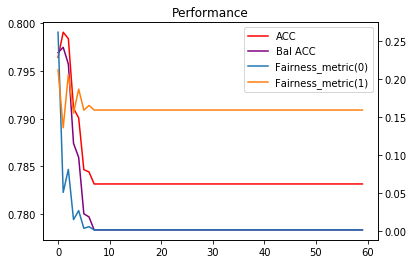

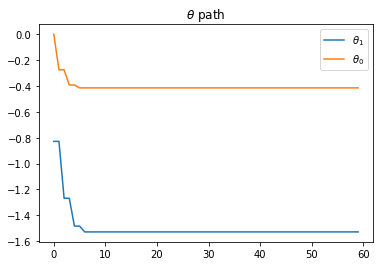

overall TPR : 0.868
priv TPR : 0.815
unpriv TPR : 0.881
Eq. Opp : 0.066

overall FPR : 0.257
priv FPR : 0.198
unpriv FPR : 0.332
diff FPR : 0.135

overall ACC : 0.810
priv ACC : 0.806
unpriv ACC : 0.813
diff ACC : 0.007



overall TPR : 0.833
priv TPR : 0.635
unpriv TPR : 0.881
Eq. Opp : 0.246

overall FPR : 0.195
priv FPR : 0.087
unpriv FPR : 0.332
diff FPR : 0.246

overall ACC : 0.820
priv ACC : 0.833
unpriv ACC : 0.813
diff ACC : 0.020



result celebA 
 0.49193973101161903 0.461629479377958 0.8203125 
 0.20105263423742573 0.33088235294117646 0.8104166666666667
[[0.]
 [0.]]
0
best theta saved [[-0.82816471]
 [ 0.        ]]
[[-0.82816471]
 [ 0.        ]]
[[-0.82816471]
 [-0.27607377]]
[[-1.26924519]
 [-0.27607377]]
[[-1.26924519]
 [-0.39640264]]
[[-1.49059938]
 [-0.39640264]]
[[-1.49059938]
 [-0.4224924 ]]
[[-1.54308417]
 [-0.4224924 ]]
[[-1.54308417]
 [-0.42326152]]
[[-1.54466789]
 [-0.42326152]]
[[-1.54466789]
 [-0.4232424 ]]
[[-1.54462849]
 [-0.4232424 ]]
[[-1.54462849]
 [-0.42324

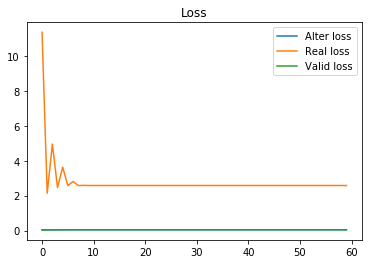

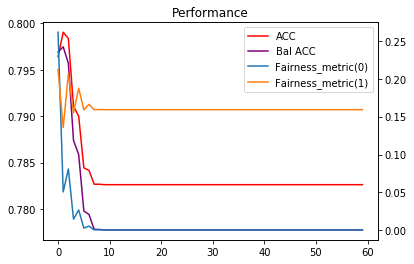

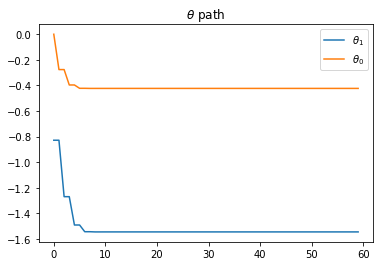

overall TPR : 0.868
priv TPR : 0.815
unpriv TPR : 0.881
Eq. Opp : 0.066

overall FPR : 0.257
priv FPR : 0.198
unpriv FPR : 0.332
diff FPR : 0.135

overall ACC : 0.810
priv ACC : 0.806
unpriv ACC : 0.813
diff ACC : 0.007



overall TPR : 0.833
priv TPR : 0.635
unpriv TPR : 0.881
Eq. Opp : 0.246

overall FPR : 0.195
priv FPR : 0.087
unpriv FPR : 0.332
diff FPR : 0.246

overall ACC : 0.820
priv ACC : 0.833
unpriv ACC : 0.813
diff ACC : 0.020



result celebA 
 0.49193973101161903 0.461629479377958 0.8203125 
 0.20105263423742573 0.33088235294117646 0.8104166666666667
{'n00': 814, 'n01': 1340, 'n10': 1807, 'n11': 519}


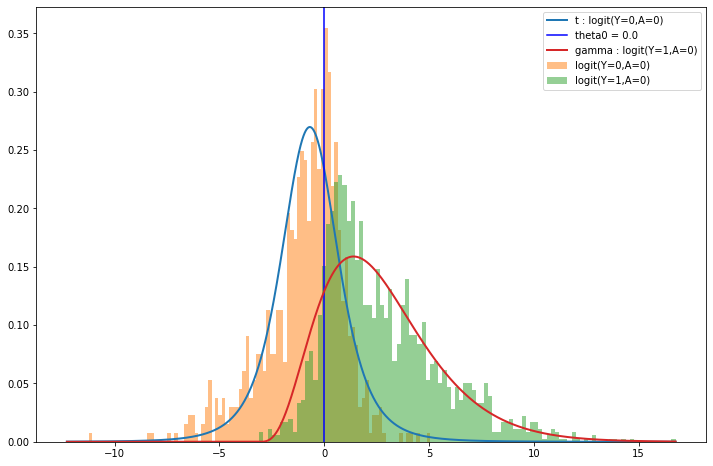

estimated distribution


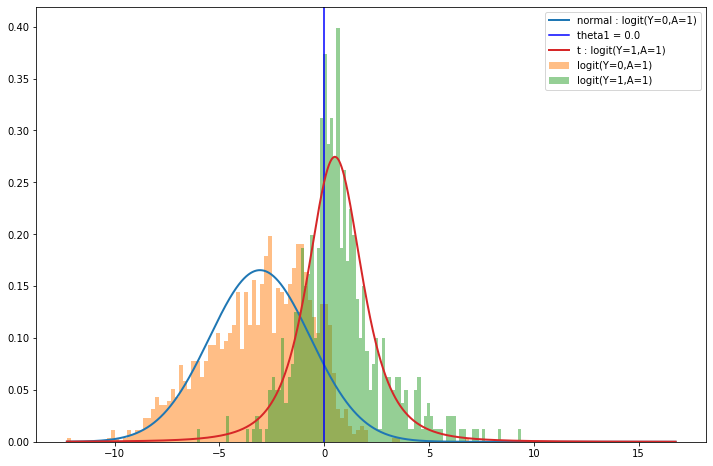

estimated distribution
{'n00': 364, 'n01': 520, 'n10': 813, 'n11': 223}


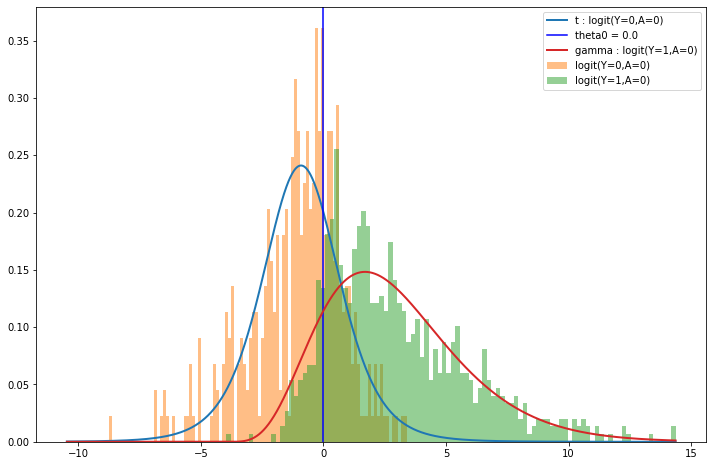

estimated distribution


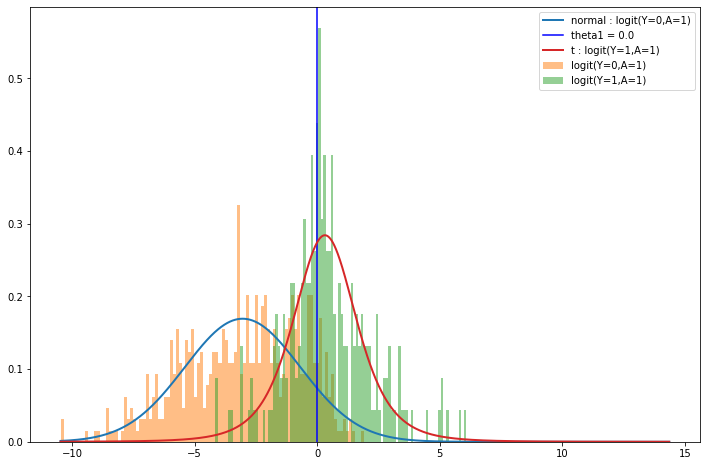

estimated distribution
[[0.]
 [0.]]
0
best theta saved [[-27.49090143]
 [  0.        ]]
[[-27.49090143]
 [  0.        ]]
[[-2.74909014e+01]
 [-4.55810948e+05]]
[[-522897.62587207]
 [-455810.94791343]]
[[-5.22897626e+05]
 [-9.39655682e+23]]
[[-9.39655682e+23]
 [-9.39655682e+23]]
[[-9.39655682e+023]
 [-1.04548586e+102]]
[[-1.04548586e+102]
 [-1.04548586e+102]]
[[-1.04548586e+102]
 [             nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]]
[[nan]
 [nan]

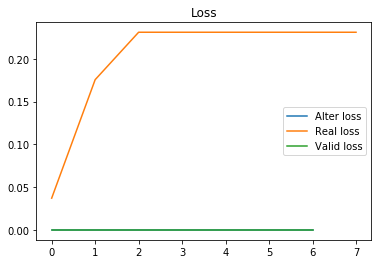

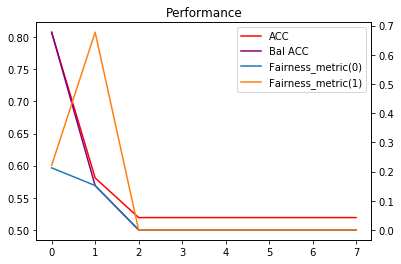

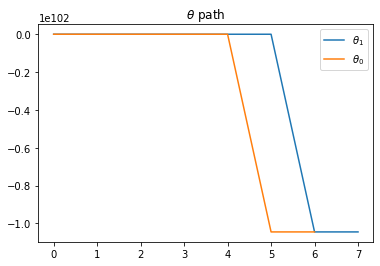

overall TPR : 0.910
priv TPR : 1.000
unpriv TPR : 0.886
Eq. Opp : 0.114

overall FPR : 0.709
priv FPR : 1.000
unpriv FPR : 0.294
diff FPR : 0.706

overall ACC : 0.625
priv ACC : 0.300
unpriv ACC : 0.830
diff ACC : 0.530



overall TPR : 0.823
priv TPR : 0.596
unpriv TPR : 0.886
Eq. Opp : 0.289

overall FPR : 0.174
priv FPR : 0.090
unpriv FPR : 0.294
diff FPR : 0.204

overall ACC : 0.824
priv ACC : 0.816
unpriv ACC : 0.830
diff ACC : 0.014



result celebA 
 0.4927677286061778 0.46037271114943096 0.8244791666666667 
 0.8204350999553951 0.2973661852166525 0.625
[[0.]
 [0.]]
0
best theta saved [[-1.05399913]
 [ 0.        ]]
[[-1.05399913]
 [ 0.        ]]
[[-1.05399913]
 [ 1.78677621]]
[[2.99769723]
 [1.78677621]]
[[ 2.99769723]
 [-9.80445382]]
[[-15.20779008]
 [ -9.80445382]]
[[  -15.20779008]
 [-5373.90130776]]
[[-5381.52754055]
 [-5373.90130776]]
[[-5.38152754e+03]
 [-3.53779011e+14]]
[[-3.53779011e+14]
 [-3.53779011e+14]]
[[-3.53779011e+14]
 [-6.30360961e+60]]
[[-6.30360961e+60]
 [-6.3

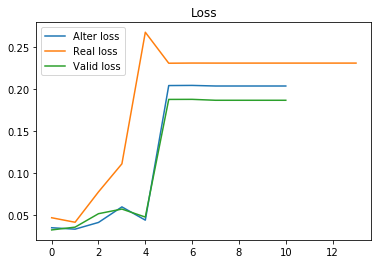

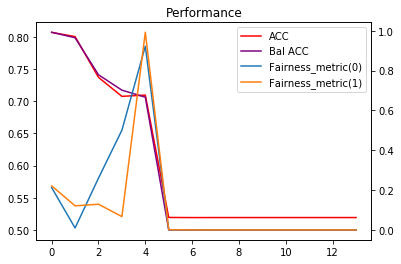

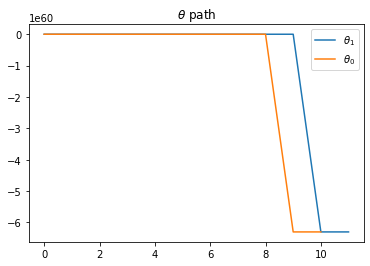

overall TPR : 0.878
priv TPR : 0.852
unpriv TPR : 0.886
Eq. Opp : 0.034

overall FPR : 0.271
priv FPR : 0.256
unpriv FPR : 0.294
diff FPR : 0.038

overall ACC : 0.809
priv ACC : 0.777
unpriv ACC : 0.830
diff ACC : 0.053



overall TPR : 0.823
priv TPR : 0.596
unpriv TPR : 0.886
Eq. Opp : 0.289

overall FPR : 0.174
priv FPR : 0.090
unpriv FPR : 0.294
diff FPR : 0.204

overall ACC : 0.824
priv ACC : 0.816
unpriv ACC : 0.830
diff ACC : 0.014



result celebA 
 0.4927677286061778 0.46037271114943096 0.8244791666666667 
 0.07177773205564325 0.2679097232624862 0.809375
[[0.]
 [0.]]
0
best theta saved [[-0.88900137]
 [ 0.        ]]
[[-0.88900137]
 [ 0.        ]]
[[-0.88900137]
 [ 0.05122433]]
[[-0.79340419]
 [ 0.05122433]]
[[-0.79340419]
 [-0.00566888]]
[[-0.89636564]
 [-0.00566888]]
[[-0.89636564]
 [ 0.05304773]]
[[-0.78656277]
 [ 0.05304773]]
[[-0.78656277]
 [-0.01252777]]
[[-0.90493647]
 [-0.01252777]]
[[-0.90493647]
 [ 0.05479569]]
[[-0.77874676]
 [ 0.05479569]]
[[-0.77874676]
 [-0.020872

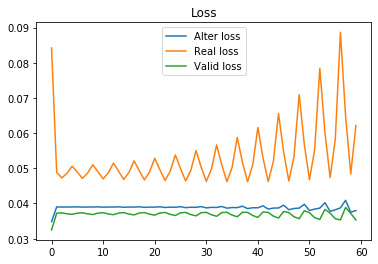

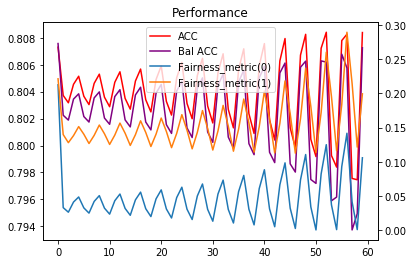

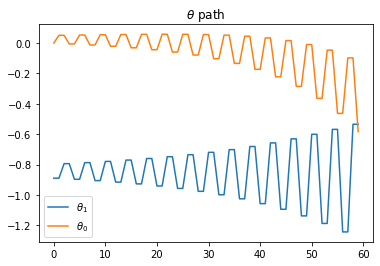

overall TPR : 0.870
priv TPR : 0.812
unpriv TPR : 0.886
Eq. Opp : 0.074

overall FPR : 0.252
priv FPR : 0.223
unpriv FPR : 0.294
diff FPR : 0.071

overall ACC : 0.814
priv ACC : 0.787
unpriv ACC : 0.830
diff ACC : 0.043



overall TPR : 0.823
priv TPR : 0.596
unpriv TPR : 0.886
Eq. Opp : 0.289

overall FPR : 0.174
priv FPR : 0.090
unpriv FPR : 0.294
diff FPR : 0.204

overall ACC : 0.824
priv ACC : 0.816
unpriv ACC : 0.830
diff ACC : 0.014



result celebA 
 0.4927677286061778 0.46037271114943096 0.8244791666666667 
 0.14482878414256964 0.30290299378738517 0.8135416666666667
[[0.]
 [0.]]
0
best theta saved [[-0.86823173]
 [ 0.        ]]
[[-0.86823173]
 [ 0.        ]]
[[-0.86823173]
 [-0.10907284]]
[[-1.06787916]
 [-0.10907284]]
[[-1.06787916]
 [-0.04375526]]
[[-0.94041671]
 [-0.04375526]]
[[-0.94041671]
 [-0.09859837]]
[[-1.04293184]
 [-0.09859837]]
[[-1.04293184]
 [-0.06054508]]
[[-0.96936643]
 [-0.06054508]]
[[-0.96936643]
 [-0.09154958]]
[[-1.02784029]
 [-0.09154958]]
[[-1.02784029]


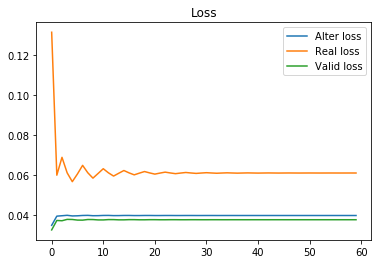

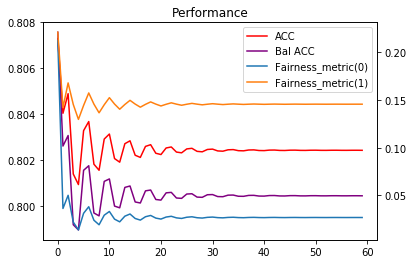

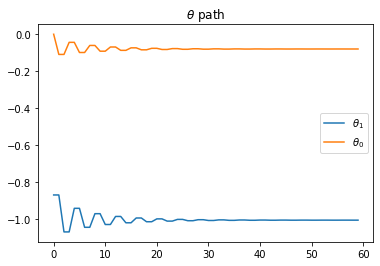

overall TPR : 0.869
priv TPR : 0.807
unpriv TPR : 0.886
Eq. Opp : 0.078

overall FPR : 0.250
priv FPR : 0.219
unpriv FPR : 0.294
diff FPR : 0.075

overall ACC : 0.814
priv ACC : 0.789
unpriv ACC : 0.830
diff ACC : 0.041



overall TPR : 0.823
priv TPR : 0.596
unpriv TPR : 0.886
Eq. Opp : 0.289

overall FPR : 0.174
priv FPR : 0.090
unpriv FPR : 0.294
diff FPR : 0.204

overall ACC : 0.824
priv ACC : 0.816
unpriv ACC : 0.830
diff ACC : 0.014



result celebA 
 0.4927677286061778 0.46037271114943096 0.8244791666666667 
 0.15315924292145894 0.30694067884795045 0.8140625
[[0.]
 [0.]]
0
best theta saved [[-0.85159264]
 [ 0.        ]]
[[-0.85159264]
 [ 0.        ]]
[[-0.85159264]
 [-0.22666996]]
[[-1.26061521]
 [-0.22666996]]
[[-1.26061521]
 [-0.26171928]]
[[-1.33239267]
 [-0.26171928]]
[[-1.33239267]
 [-0.252851  ]]
[[-1.31373786]
 [-0.252851  ]]
[[-1.31373786]
 [-0.25590186]]
[[-1.32010976]
 [-0.25590186]]
[[-1.32010976]
 [-0.25492577]]
[[-1.3180662 ]
 [-0.25492577]]
[[-1.3180662 ]
 [-0.2552

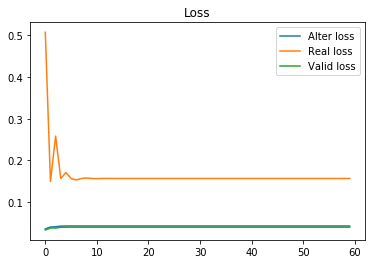

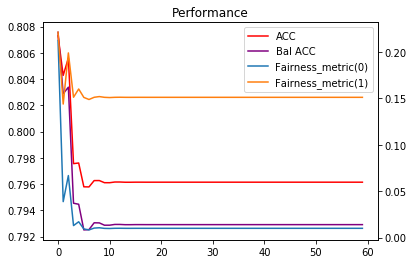

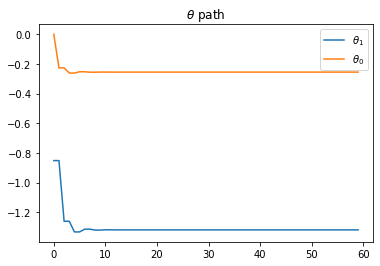

overall TPR : 0.867
priv TPR : 0.798
unpriv TPR : 0.886
Eq. Opp : 0.087

overall FPR : 0.248
priv FPR : 0.215
unpriv FPR : 0.294
diff FPR : 0.079

overall ACC : 0.814
priv ACC : 0.789
unpriv ACC : 0.830
diff ACC : 0.041



overall TPR : 0.823
priv TPR : 0.596
unpriv TPR : 0.886
Eq. Opp : 0.289

overall FPR : 0.174
priv FPR : 0.090
unpriv FPR : 0.294
diff FPR : 0.204

overall ACC : 0.824
priv ACC : 0.816
unpriv ACC : 0.830
diff ACC : 0.014



result celebA 
 0.4927677286061778 0.46037271114943096 0.8244791666666667 
 0.16597400663308365 0.31232425892870413 0.8140625
[[0.]
 [0.]]
0
best theta saved [[-0.8495113]
 [ 0.       ]]
[[-0.8495113]
 [ 0.       ]]
[[-0.8495113 ]
 [-0.24070373]]
[[-1.2831165 ]
 [-0.24070373]]
[[-1.2831165 ]
 [-0.30797331]]
[[-1.42155672]
 [-0.30797331]]
[[-1.42155672]
 [-0.30414889]]
[[-1.41326259]
 [-0.30414889]]
[[-1.41326259]
 [-0.30497034]]
[[-1.41503819]
 [-0.30497034]]
[[-1.41503819]
 [-0.30480227]]
[[-1.41467464]
 [-0.30480227]]
[[-1.41467464]
 [-0.30483702

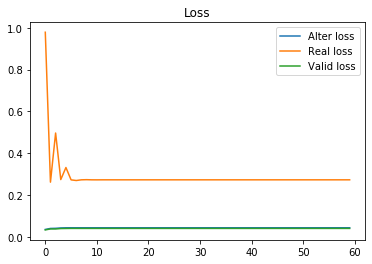

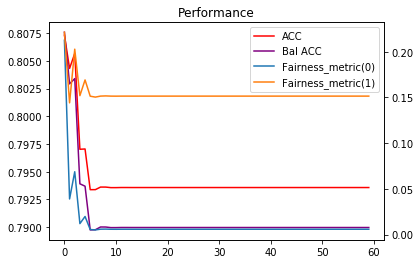

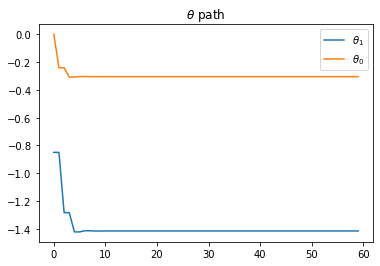

overall TPR : 0.867
priv TPR : 0.798
unpriv TPR : 0.886
Eq. Opp : 0.087

overall FPR : 0.248
priv FPR : 0.215
unpriv FPR : 0.294
diff FPR : 0.079

overall ACC : 0.814
priv ACC : 0.789
unpriv ACC : 0.830
diff ACC : 0.041



overall TPR : 0.823
priv TPR : 0.596
unpriv TPR : 0.886
Eq. Opp : 0.289

overall FPR : 0.174
priv FPR : 0.090
unpriv FPR : 0.294
diff FPR : 0.204

overall ACC : 0.824
priv ACC : 0.816
unpriv ACC : 0.830
diff ACC : 0.014



result celebA 
 0.4927677286061778 0.46037271114943096 0.8244791666666667 
 0.16597400663308365 0.31232425892870413 0.8140625
[[0.]
 [0.]]
0
best theta saved [[-0.84784598]
 [ 0.        ]]
[[-0.84784598]
 [ 0.        ]]
[[-0.84784598]
 [-0.25182441]]
[[-1.30086999]
 [-0.25182441]]
[[-1.30086999]
 [-0.34888718]]
[[-1.50136503]
 [-0.34888718]]
[[-1.50136503]
 [-0.36377411]]
[[-1.53456236]
 [-0.36377411]]
[[-1.53456236]
 [-0.36345432]]
[[-1.53383935]
 [-0.36345432]]
[[-1.53383935]
 [-0.36347229]]
[[-1.53387996]
 [-0.36347229]]
[[-1.53387996]
 [-0.3634

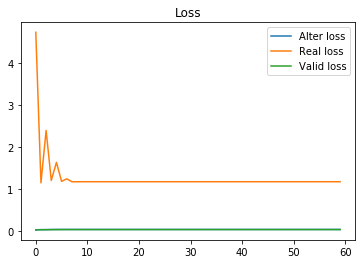

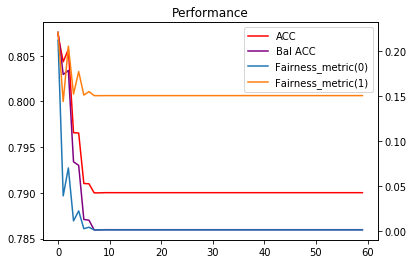

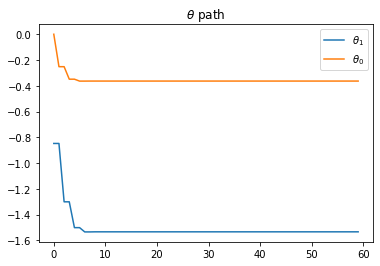

overall TPR : 0.867
priv TPR : 0.798
unpriv TPR : 0.886
Eq. Opp : 0.087

overall FPR : 0.248
priv FPR : 0.215
unpriv FPR : 0.294
diff FPR : 0.079

overall ACC : 0.814
priv ACC : 0.789
unpriv ACC : 0.830
diff ACC : 0.041



overall TPR : 0.823
priv TPR : 0.596
unpriv TPR : 0.886
Eq. Opp : 0.289

overall FPR : 0.174
priv FPR : 0.090
unpriv FPR : 0.294
diff FPR : 0.204

overall ACC : 0.824
priv ACC : 0.816
unpriv ACC : 0.830
diff ACC : 0.014



result celebA 
 0.4927677286061778 0.46037271114943096 0.8244791666666667 
 0.16597400663308365 0.31232425892870413 0.8140625
[[0.]
 [0.]]
0
best theta saved [[-0.8476378]
 [ 0.       ]]
[[-0.8476378]
 [ 0.       ]]
[[-0.8476378 ]
 [-0.25320785]]
[[-1.3030738 ]
 [-0.25320785]]
[[-1.3030738 ]
 [-0.35425902]]
[[-1.51190069]
 [-0.35425902]]
[[-1.51190069]
 [-0.37285279]]
[[-1.55351757]
 [-0.37285279]]
[[-1.55351757]
 [-0.37309539]]
[[-1.55407008]
 [-0.37309539]]
[[-1.55407008]
 [-0.37308845]]
[[-1.55405428]
 [-0.37308845]]
[[-1.55405428]
 [-0.37308865

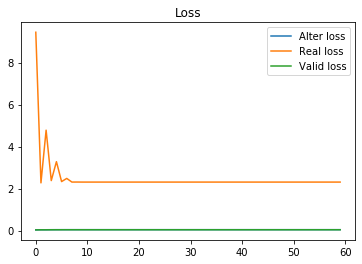

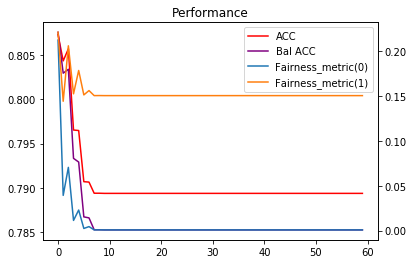

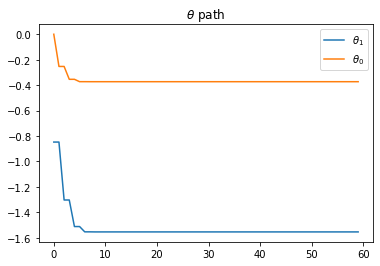

overall TPR : 0.867
priv TPR : 0.798
unpriv TPR : 0.886
Eq. Opp : 0.087

overall FPR : 0.248
priv FPR : 0.215
unpriv FPR : 0.294
diff FPR : 0.079

overall ACC : 0.814
priv ACC : 0.789
unpriv ACC : 0.830
diff ACC : 0.041



overall TPR : 0.823
priv TPR : 0.596
unpriv TPR : 0.886
Eq. Opp : 0.289

overall FPR : 0.174
priv FPR : 0.090
unpriv FPR : 0.294
diff FPR : 0.204

overall ACC : 0.824
priv ACC : 0.816
unpriv ACC : 0.830
diff ACC : 0.014



result celebA 
 0.4927677286061778 0.46037271114943096 0.8244791666666667 
 0.16597400663308365 0.31232425892870413 0.8140625


In [431]:
# lamda = 1e2

optim_dict = {'lr' : [2e-1, 1e-1, 5e-2, 1e-2, 1e-2, 5e-4], 'lamda' : [0, 1e-1, 5e-1, 1e0, 5, 1e1, 5e1, 1e2], \
             'epoch' : [1e4, 1e4, 2e4, 5e3, 1e4, 3e4]}


eval_dict = {}
lamda_hist = {}
eq_odd_hist = {}
eq_opp_hist = {}
dp_hist = {}
acc_hist = {}

repeat_num = 5
iter_num = 30

for repeat in range(repeat_num):
    train_logit, train_sens, train_label, valid_logit, valid_sens, valid_label, \
    test_logit, test_sens, test_label = gen_samples(trainloader_GSTAR, validloader_GSTAR, testloader_GSTAR)
    
    logit_shape = True
    
    A_config, sample_config, dist_config = gen_config(train_logit, train_sens, train_label, verbose = False, save_fig = False)
    A_config_valid, sample_valid, dist_valid = gen_config(valid_logit, valid_sens, valid_label, verbose = False, save_fig = False)

    for cnst_name in ['eod']:
        if cnst_name == 'eod':
            A = A_config['A_EOd']
            A_valid = A_config_valid['A_EOd']
        
        elif cnst_name == 'dp':
            A = A_config['A_DP']
            A_valid = A_config_valid['A_DP']
            
        elif cnst_name =='dp+eod':
            A = A_config['EOd']
            A_valid = A_config_valid['EOd']
            
        elif cnst_name == 'eop':
            A = A_config['A_EOp']
            A_valid = A_config_valid['A_EOp']

        train_config = {'A' : A, 'sample_config' : sample_config, 'dist_config' : dist_config}
        valid_config = {'A' : A_valid, 'sample_config' : sample_valid, 'dist_config' : dist_valid}

        for i in range(len(optim_dict['lamda'])):
                lamda = optim_dict['lamda'][i]

                if repeat == 0:
                    lamda_hist[lamda] = []
                    eq_odd_hist[lamda] = []
                    eq_opp_hist[lamda] = []
                    dp_hist[lamda] = []
                    acc_hist[lamda] = []

                theta_best, theta_end = alternative_train(theta_0.copy(), train_config, valid_config, c, lamda, iter_num, verbose_iter, verbose = True)

                z, ACC = evaluate(valid_logit, valid_label, valid_sens, theta_best, verbose = True, logit_form = logit_shape)

                if logit_shape:
                    z_orig, ACC_orig =  evaluate(valid_logit, valid_label, valid_sens, np.zeros((2,1)), verbose = True, logit_form = logit_shape)
                else:
                    z_orig, ACC_orig =  evaluate(valid_logit, valid_label, valid_sens, np.zeros((2,1))+0.5, verbose = True, logit_form = logit_shape)

                ###### z[0+2]/(z[1+2]+z[0+2]) = z[0+2]/n11?
                eq_opps = abs(z[0+2]/(z[1+2]+z[0+2]) - z[0+2+4]/(z[1+2+4]+z[0+2+4]))
                eq_opps_orig = abs(z_orig[0+2]/(z_orig[1+2]+z_orig[0+2]) - z_orig[0+2+4]/(z_orig[1+2+4]+z_orig[0+2+4]))
                dist = abs(z[0+2]/(z[1+2]+z[0+2]) - z[0+2+4]/(z[1+2+4]+z[0+2+4])) + abs(z[0]/(z[1]+z[0]) - z[0+4]/(z[1+4]+z[0+4]))
                dist_orig = abs(z_orig[0+2]/(z_orig[1+2]+z_orig[0+2]) - z_orig[0+2+4]/(z_orig[1+2+4]+z_orig[0+2+4])) + abs(z_orig[0]/(z_orig[1]+z_orig[0]) - z_orig[0+4]/(z_orig[1+4]+z_orig[0+4]))
                dp = abs(((z[0] + z[2])/(sum(z[0:4])) - (z[0+4] + z[2+4])/(sum(z[4:8]))))
                dp_orig = abs(((z_orig[0] + z_orig[2])/(sum(z_orig[0:4])) - (z_orig[0+4] + z_orig[2+4])/(sum(z_orig[4:8]))))

                eval_dict[cnst_name] = dist.item(), dp.item(), ACC
                eval_dict['orig'] = dist_orig.item(), dp_orig.item(), ACC_orig

                print('result', DATANAME, '\n', dist_orig.item(), dp_orig.item(), ACC_orig,'\n', dist.item(), dp.item(), ACC)

                lamda_hist[lamda].append(lamda)
                eq_odd_hist[lamda].append(dist.item())
                eq_opp_hist[lamda].append(eq_opps.item())
                dp_hist[lamda].append(dp.item())

                acc_hist[lamda].append(ACC)

In [430]:
abs(-np.inf)

inf

In [422]:
theta_end

array([[-1.2993096],
       [-0.3066142]])

In [212]:
lamda_hist

{0: [0, 0, 0],
 0.01: [0.01, 0.01, 0.01],
 0.1: [0.1, 0.1, 0.1],
 0.5: [0.5, 0.5, 0.5],
 1: [1, 1, 1],
 10.0: [10.0, 10.0, 10.0]}

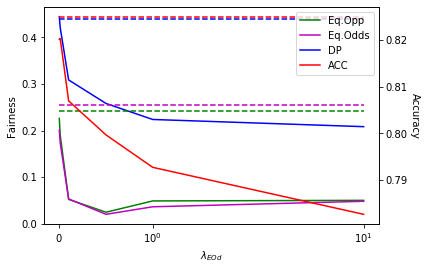

In [248]:
_, ax = plt.subplots()
pt = ax.plot(optim_dict['lamda'], [np.mean(eq_opp_hist[k]) for k in eq_opp_hist.keys()], label = 'Eq.Opp', c = 'g')
pt += ax.plot(optim_dict['lamda'], [np.mean(eq_odd_hist[k])/2 for k in eq_odd_hist.keys()], label = 'Eq.Odds', c = 'm')
pt += ax.plot(optim_dict['lamda'], [np.mean(dp_hist[k]) for k in dp_hist.keys()], label = 'DP', c = 'b')

pt2 = ax.plot(optim_dict['lamda'], [eq_opps_orig for k in eq_opp_hist.keys()], label = 'Eq.Opp', ls = '--', c = 'g', )
pt2 += ax.plot(optim_dict['lamda'], [dist_orig/2 for k in eq_odd_hist.keys()], label = 'Eq.Odds', ls = '--', c = 'm', )
pt2 += ax.plot(optim_dict['lamda'], [dp_orig - 0.05 for k in dp_hist.keys()], label = 'DP', ls = '--', c = 'b', )

ax.set_xscale('symlog')
ax.set_ylabel('Fairness')

ax2 = ax.twinx()

pt += ax2.plot(optim_dict['lamda'], [np.mean(acc_hist[k]) for k in acc_hist.keys()], label = 'ACC', c = 'r')
pt2 += ax2.plot(optim_dict['lamda'], [ACC_orig for k in acc_hist.keys()], label = 'ACC', c = 'r', ls = '--', )

ax2.set_ylabel('Accuracy', rotation = 270, labelpad = 12)

ax.set_xlabel('$\lambda_{EOd}$')
plt.legend(pt, [l.get_label() for l in pt], loc = 1)
plt.show()
# plt

[0/2000] loss : 0.934, dldt norm : 1.007
[[-0.03383831]
 [ 0.03748221]]
[[ 0.67676617]
 [-0.74542052]]



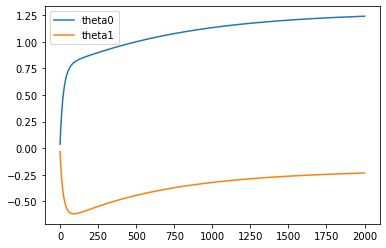

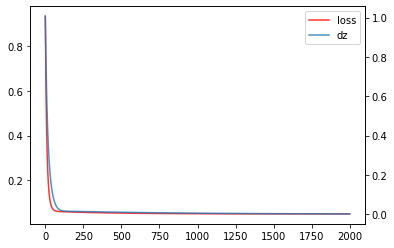

overall TPR : 0.654
priv TPR : 0.699
unpriv TPR : 0.645
Eq. Opp : 0.054

overall FPR : 0.092
priv FPR : 0.108
unpriv FPR : 0.071
diff FPR : 0.036

overall ACC : 0.772
priv ACC : 0.843
unpriv ACC : 0.732
diff ACC : 0.110



A_EOd : [0.18154567]
overall TPR : 0.834
priv TPR : 0.614
unpriv TPR : 0.879
Eq. Opp : 0.266

overall FPR : 0.185
priv FPR : 0.082
unpriv FPR : 0.325
diff FPR : 0.242

overall ACC : 0.825
priv ACC : 0.840
unpriv ACC : 0.817
diff ACC : 0.023



A_EOd : [0.75697339]
result celebA 
 0.2540506074097463 0.5878120298960441 0.825 
 0.0450282807621765 0.2895619908020178 0.771875


In [274]:


for cnst_name in ['eod']:
    
    lr = 5e-2
    iter_num = int(2e3)
    lamda = 1e1
    
    verbose_iter = 1e4
    if cnst_name == 'eod':
        A = A_EOd
    elif cnst_name == 'dp':
        A = A_DP
    elif cnst_name =='dp+eod':
        A = np.concatenate((A_EOd, A_DP), 1)
    elif cnst_name == 'eop':
        A = A_EOp
    
    theta, thet = train(theta_0.copy(), A, c, lamda, sample_config, dist_config, lr, iter_num, verbose_iter, verbose = True, show_fig = True)
    
    z, ACC, EOd = evaluate(valid_logit, valid_label, valid_sens, A, theta, verbose = True, logit_form = logit_shape)
    
    if logit_shape:
        z_orig, ACC_orig, EOd_orig =  evaluate(valid_logit, valid_label, valid_sens, A, np.zeros((2,1)), verbose = True, logit_form = logit_shape)
    else:
        z_orig, ACC_orig, EOd_orig =  evaluate(valid_logit, valid_label, valid_sens, A, np.zeros((2,1))+0.5, verbose = True, logit_form = logit_shape)

    ###### z[0+2]/(z[1+2]+z[0+2]) = z[0+2]/n11?
    eq_opp = abs(z[0+2]/(z[1+2]+z[0+2]) - z[0+2+4]/(z[1+2+4]+z[0+2+4]))
    dist = (abs(z[0+2]/(z[1+2]+z[0+2]) - z[0+2+4]/(z[1+2+4]+z[0+2+4])) + abs(z[0]/(z[1]+z[0]) - z[0+4]/(z[1+4]+z[0+4])))/2
    dist_orig = (abs(z_orig[0+2]/(z_orig[1+2]+z_orig[0+2]) - z_orig[0+2+4]/(z_orig[1+2+4]+z_orig[0+2+4])) + abs(z_orig[0]/(z_orig[1]+z_orig[0]) - z_orig[0+4]/(z_orig[1+4]+z_orig[0+4])))/2
    dp = abs(((z[0] + z[2])/(n11+n01) - (z[0+4] + z[2+4])/(n10+n00))*N)
    dp_orig = abs(((z_orig[0] + z_orig[2])/(n11+n01) - (z_orig[0+4] + z_orig[2+4])/(n10+n00))*N)

    eval_dict[cnst_name] = dist.item(), dp.item(), ACC
    eval_dict['orig'] = dist_orig.item(), dp_orig.item(), ACC_orig

    print('result', DATANAME, '\n', dist_orig.item(), dp_orig.item(), ACC_orig,'\n', dist.item(), dp.item(), ACC)
    



overall TPR : 0.837
priv TPR : 0.812
unpriv TPR : 0.847
Eq. Opp : 0.035

overall FPR : 0.217
priv FPR : 0.199
unpriv FPR : 0.256
diff FPR : 0.057

overall ACC : 0.809
priv ACC : 0.804
unpriv ACC : 0.814
diff ACC : 0.010



A_EOd : [0.2018034]


(array([[0.1078125 ],
        [0.025     ],
        [0.06927083],
        [0.2796875 ],
        [0.29895833],
        [0.05416667],
        [0.0421875 ],
        [0.12291667]]), 0.809375, array([0.2018034]))

In [ ]:

lr = 1e-4
iter_num = int(2e3)
lamda = 1e5

overall TPR : 0.561
priv TPR : 0.580
unpriv TPR : 0.557
Eq. Opp : 0.022

overall FPR : 0.054
priv FPR : 0.070
unpriv FPR : 0.032
diff FPR : 0.039

overall ACC : 0.740
priv ACC : 0.840
unpriv ACC : 0.684
diff ACC : 0.156


In [ ]:
lr = 5e-3
iter_num = int(1e4)
lamda = 3e0

theta = np.array([[-0.56660007],
       [ 0.85933595]])

overall TPR : 0.708
priv TPR : 0.750
unpriv TPR : 0.699
Eq. Opp : 0.051

overall FPR : 0.125
priv FPR : 0.141
unpriv FPR : 0.103
diff FPR : 0.038

overall ACC : 0.785
priv ACC : 0.831
unpriv ACC : 0.760
diff ACC : 0.071

In [ ]:

lr = 5e-3
iter_num = int(1e4)
lamda = 2e0

theta = np.array([[-0.61162298],
       [ 0.80412276]])

overall TPR : 0.717
priv TPR : 0.750
unpriv TPR : 0.711
Eq. Opp : 0.039

overall FPR : 0.131
priv FPR : 0.145
unpriv FPR : 0.113
diff FPR : 0.031

overall ACC : 0.787
priv ACC : 0.828
unpriv ACC : 0.765
diff ACC : 0.063

In [ ]:
lr = 1e-2
iter_num = int(1e4)
lamda = 5e-1

theta = np.array([[-0.65298021],
       [ 0.64752083]])

overall TPR : 0.746
priv TPR : 0.756
unpriv TPR : 0.744
Eq. Opp : 0.012

overall FPR : 0.152
priv FPR : 0.157
unpriv FPR : 0.145
diff FPR : 0.011

overall ACC : 0.793
priv ACC : 0.821
unpriv ACC : 0.778
diff ACC : 0.043


In [129]:
dist

array([0.06525933])

In [39]:
z, ACC, EOd = evaluate(valid_logit, valid_label, valid_sens, A, theta, verbose = True, logit_form = logit_shape)

if logit_shape:
    z_orig, ACC_orig, EOd_orig =  evaluate(valid_logit, valid_label, valid_sens, A, np.zeros((2,1)), verbose = True, logit_form = logit_shape)
else:
    z_orig, ACC_orig, EOd_orig =  evaluate(valid_logit, valid_label, valid_sens, A, np.zeros((2,1))+0.5, verbose = True, logit_form = logit_shape)

###### z[0+2]/(z[1+2]+z[0+2]) = z[0+2]/n11?
dist = abs(z[0+2]/(z[1+2]+z[0+2]) - z[0+2+4]/(z[1+2+4]+z[0+2+4])) + abs(z[0]/(z[1]+z[0]) - z[0+4]/(z[1+4]+z[0+4]))
dist_orig = abs(z_orig[0+2]/(z_orig[1+2]+z_orig[0+2]) - z_orig[0+2+4]/(z_orig[1+2+4]+z_orig[0+2+4])) + abs(z_orig[0]/(z_orig[1]+z_orig[0]) - z_orig[0+4]/(z_orig[1+4]+z_orig[0+4]))
dp = abs(((z[0] + z[2])/(n11+n01) - (z[0+4] + z[2+4])/(n10+n00))*N)
dp_orig = abs(((z_orig[0] + z_orig[2])/(n11+n01) - (z_orig[0+4] + z_orig[2+4])/(n10+n00))*N)

eval_dict[cnst_name] = dist.item(), dp.item(), ACC
eval_dict['orig'] = dist_orig.item(), dp_orig.item(), ACC_orig

print('result', DATANAME, '\n', dist_orig.item(), dp_orig.item(), ACC_orig,'\n', dist.item(), dp.item(), ACC)

overall TPR : 0.882
priv TPR : 0.637
unpriv TPR : 0.937
Eq. Opp : 0.300

overall FPR : 0.249
priv FPR : 0.107
unpriv FPR : 0.447
diff FPR : 0.340

overall ACC : 0.821
priv ACC : 0.824
unpriv ACC : 0.820
diff ACC : 0.004



A_EOd : [0.3625]
overall TPR : 0.884
priv TPR : 0.725
unpriv TPR : 0.920
Eq. Opp : 0.195

overall FPR : 0.260
priv FPR : 0.158
unpriv FPR : 0.401
diff FPR : 0.243

overall ACC : 0.818
priv ACC : 0.810
unpriv ACC : 0.822
diff ACC : 0.012



A_EOd : [0.25673516]
result celebA 
 0.4382690861800392 0.5084096662230225 0.8175 
 0.6393577225258629 0.5919843941647747 0.82125


In [136]:
a[1e-5]

KeyError: 1e-05